In [31]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt
import anndata as ad

# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import pypath
import seaborn as sns


# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [32]:
#load tcell data.
t_cell_re_clustered = '../t_cell_analysis/t_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
t_cell_data = ad.read_h5ad(t_cell_re_clustered)

Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results.

The current best practice to correct for this is using a pseudo-bulk approach (Squair J.W., et al 2021), which involves the following steps:

Subsetting the cell type(s) of interest to perform DEA.
Extracting their raw integer counts.
Summing their counts per gene into a single profile if they pass quality control.
Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).
We can pseudobulk using the function decoupler.get_pseudobulk. In this example, we are interested in summing the counts but other modes are available, for more information check its argument mode.

In [33]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    t_cell_data,
    sample_col='Sample',
    groups_col='T_cell_type_fine',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

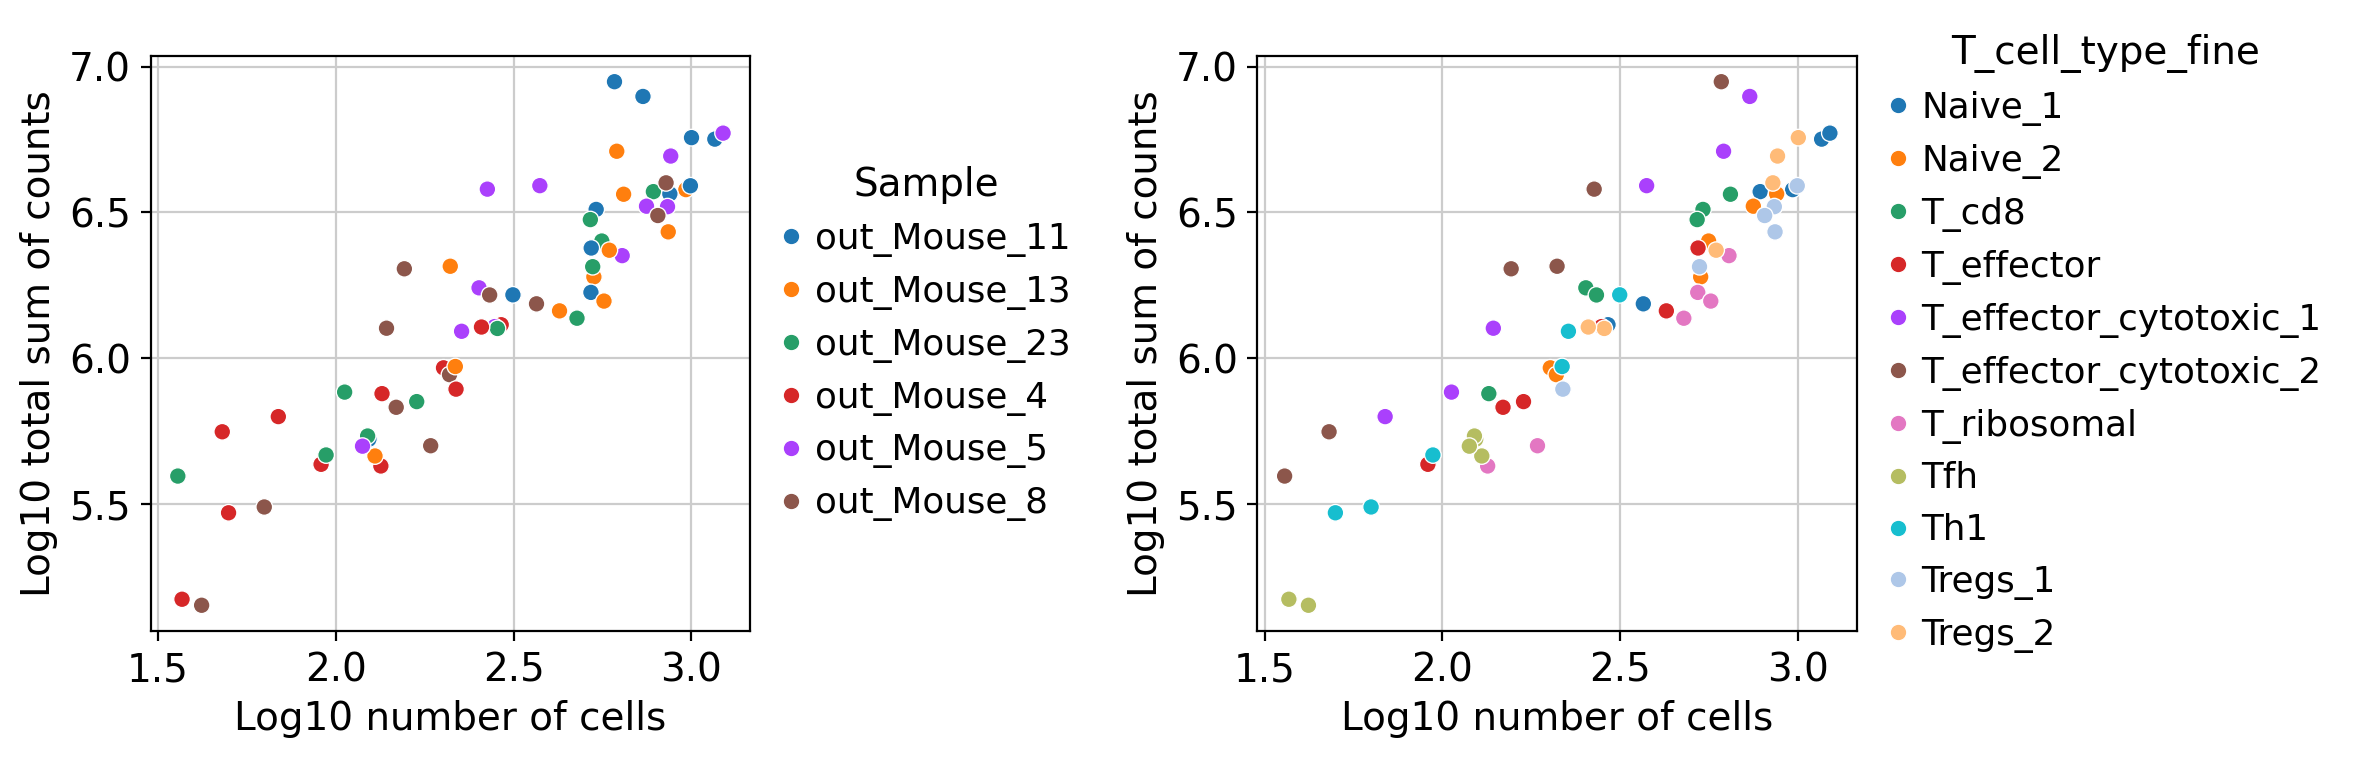

In [34]:
dc.plot_psbulk_samples(pdata, groupby=['Sample', 'T_cell_type_fine'], figsize=(12, 4))


In [35]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


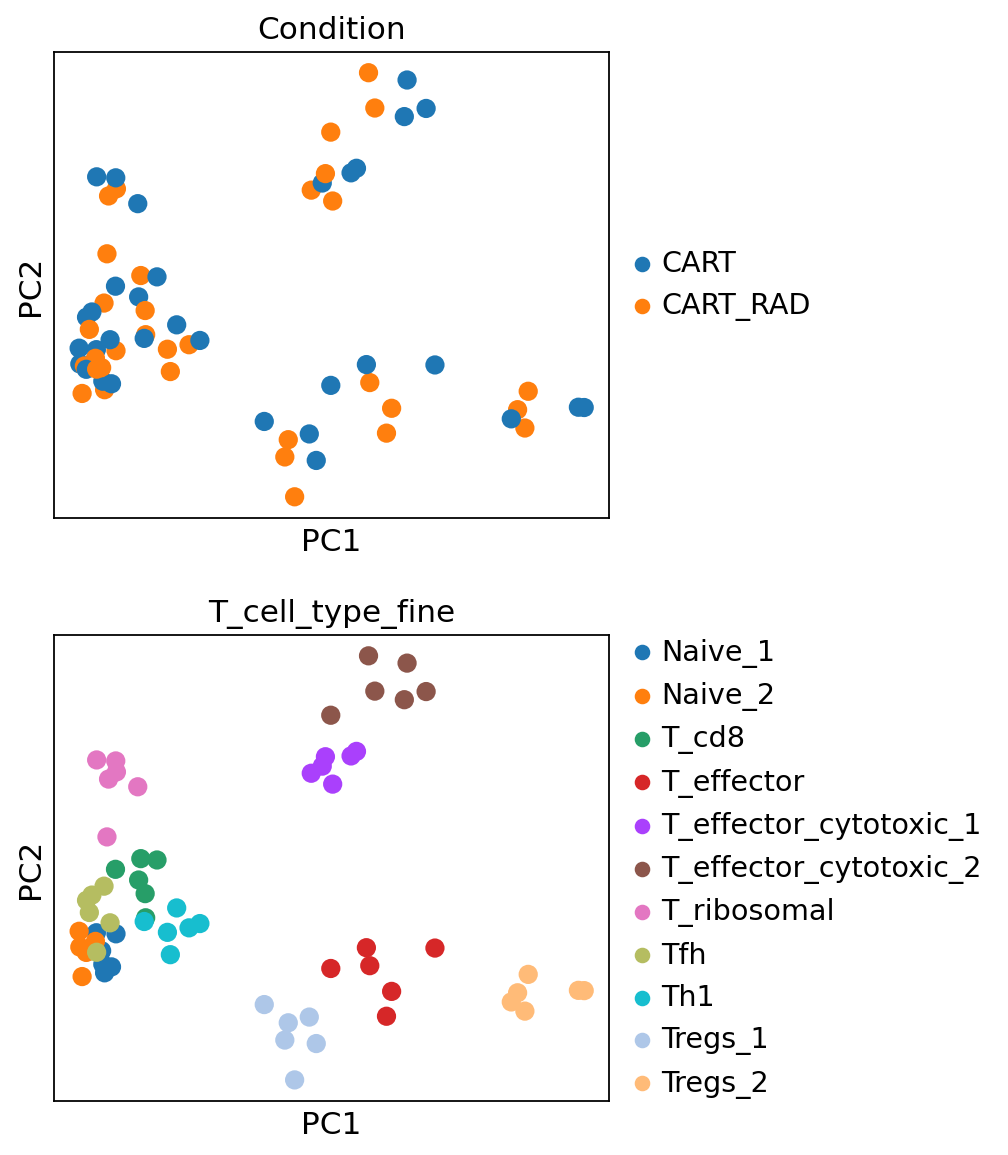

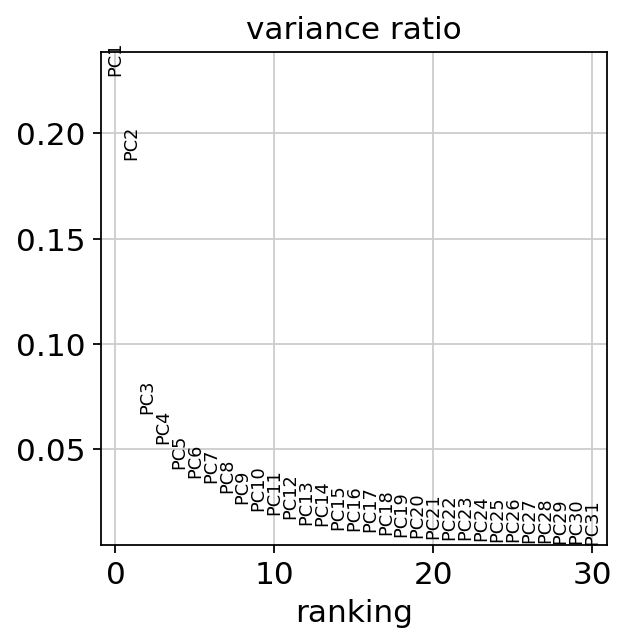

In [36]:
sc.pl.pca(pdata, color=['Condition', 'T_cell_type_fine'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

Pseudo-bulk profile gene filtering

Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

To filter genes, we will follow the strategy implemented in the function filterByExpr from edgeR. It keeps genes that have a minimum total number of reads across samples (min_total_count), and that have a minimum number of counts in a number of samples (min_count).

We can plot how many genes do we keep, you can play with the min_count and min_total_count to check how many genes would be kept when changed:

Contrast between conditions

Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the python implementation of the framework DESeq2, but we could have used any other one (limma or edgeR for example). For a better understanding how it works, check DESeq2’s documentation. Note that more complex experimental designs can be used by adding more factors to the design_factors argument.

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.91 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 1.97 seconds.

Fitting LFCs...
... done in 1.14 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.22 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik     8.832375       -0.104890  0.527928 -0.198683  0.842511   
0610009B22Rik    10.147758       -0.228560  0.459585 -0.497317  0.618965   
0610009E02Rik    11.987475       -0.737608  0.371411 -1.985959  0.047038   
0610010F05Rik    23.835657        0.635722  0.433133  1.467730  0.142178   
0610010K14Rik   134.567612        0.382858  0.198726  1.926563  0.054034   
...                    ...             ...       ...       ...       ...   
mt-Nd3          720.329895       -0.404107  0.534536 -0.755995  0.449652   
mt-Nd4         4621.552246       -0.035810  0.114352 -0.313154  0.754163   
mt-Nd4l         452.054108       -0.236809  0.253887 -0.932735  0.350957   
mt-Nd5         1652.712036       -0.060194  0.102556 -0.586939  0.557245   
mt-Nd6          228.508362        0.334796  0.239986  1.395066  0.162996   

                   pad

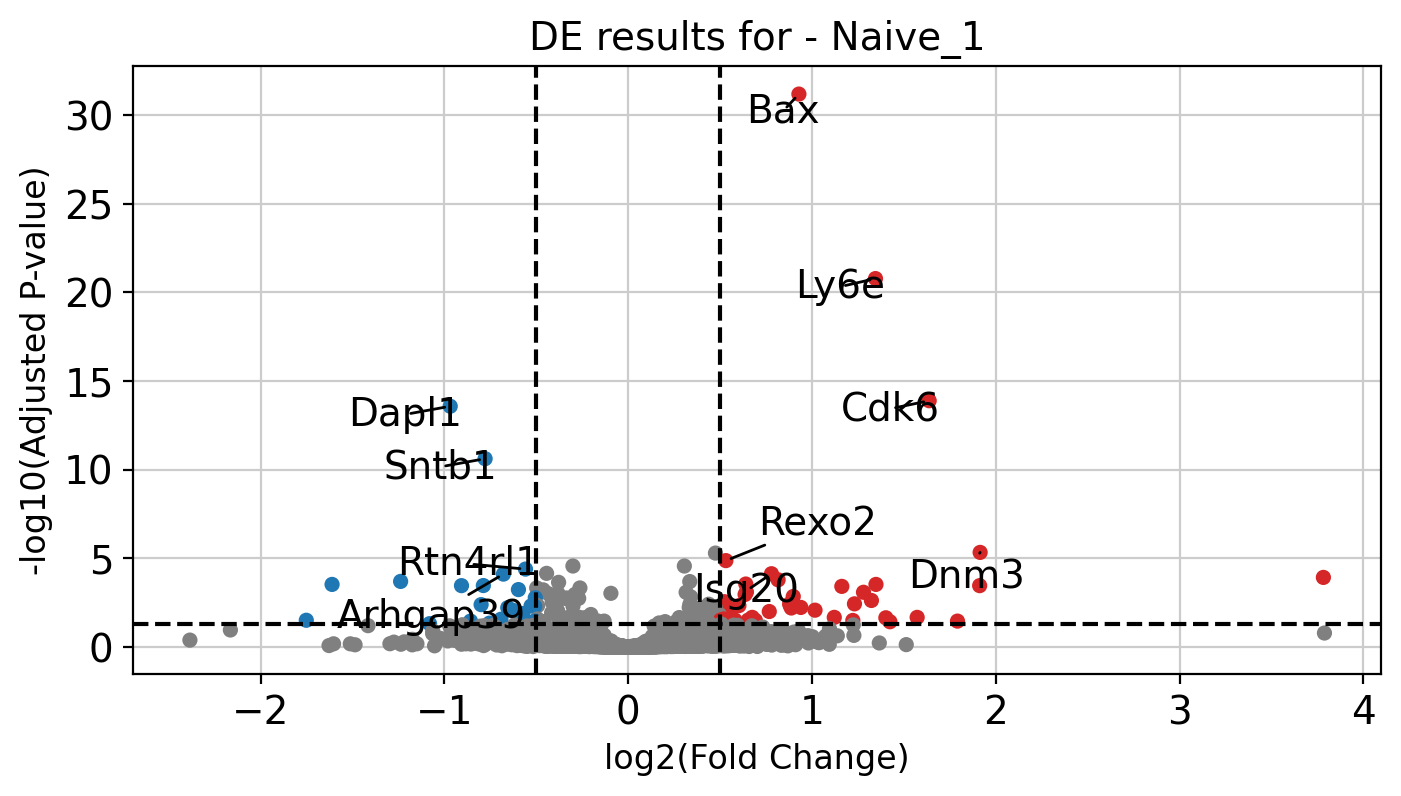

Fitting dispersions...
... done in 1.81 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.



<Figure size 960x640 with 0 Axes>

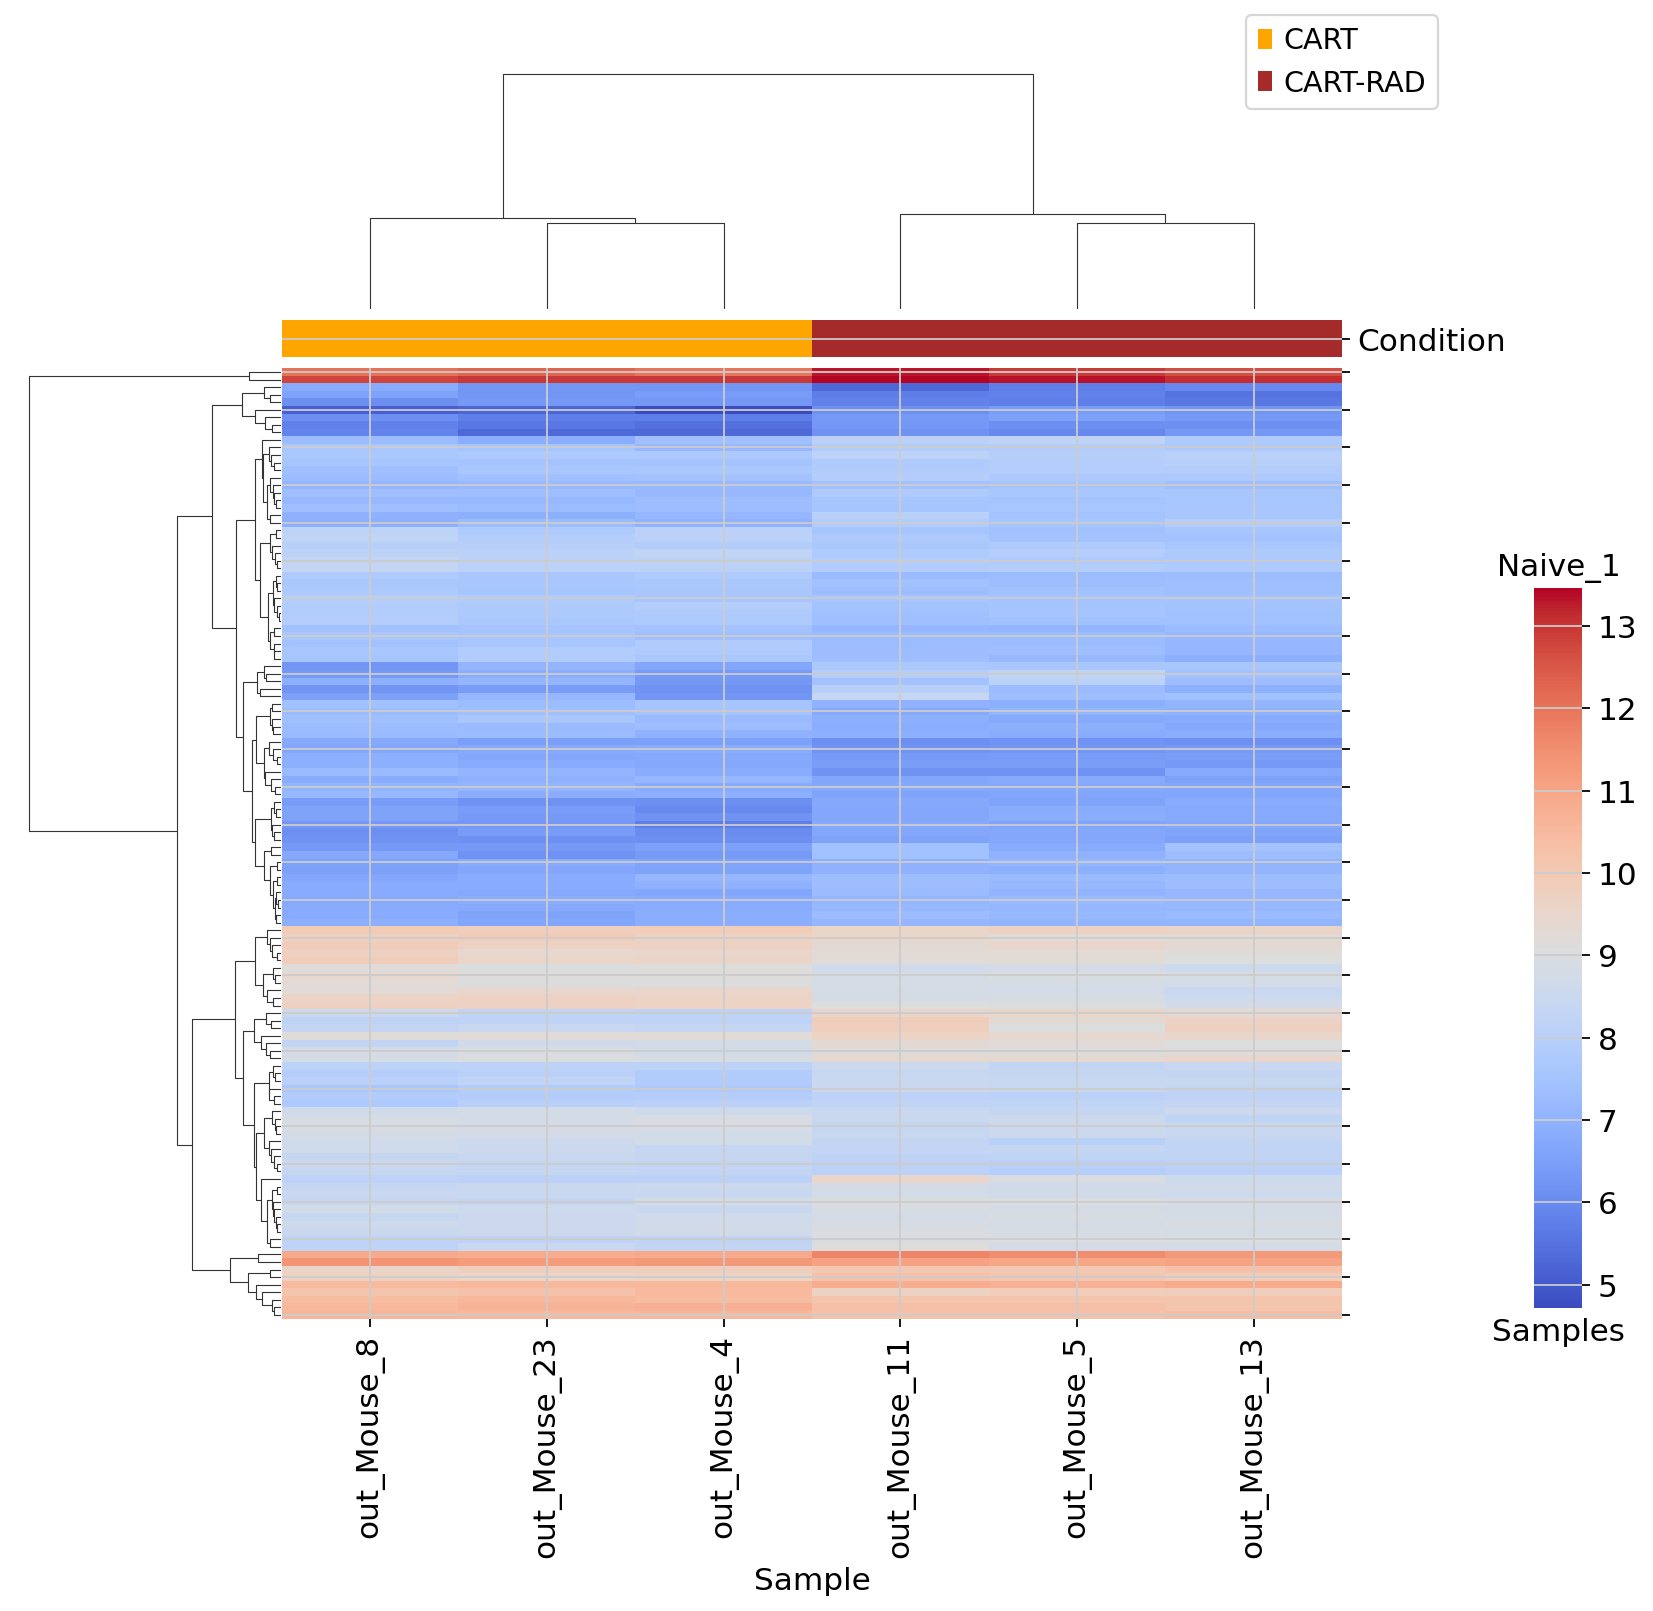

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.73 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 1.62 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.02 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    11.416203       -0.664260  0.551650 -1.204133  0.228538   
0610010F05Rik    11.875476        0.417516  0.580311  0.719470  0.471852   
0610010K14Rik    63.014637       -0.184015  0.218352 -0.842743  0.399372   
0610012G03Rik    71.718010        0.099777  0.214223  0.465762  0.641386   
0610030E20Rik    35.301006       -0.358357  0.193034 -1.856449  0.063390   
...                    ...             ...       ...       ...       ...   
mt-Nd3          429.511871       -0.540910  0.510761 -1.059026  0.289588   
mt-Nd4         2792.808350       -0.052544  0.144931 -0.362543  0.716946   
mt-Nd4l         271.119965       -0.193043  0.256015 -0.754031  0.450830   
mt-Nd5         1016.877502       -0.016935  0.119984 -0.141141  0.887758   
mt-Nd6          145.765762        0.065311  0.281366  0.232123  0.816442   

                   pad

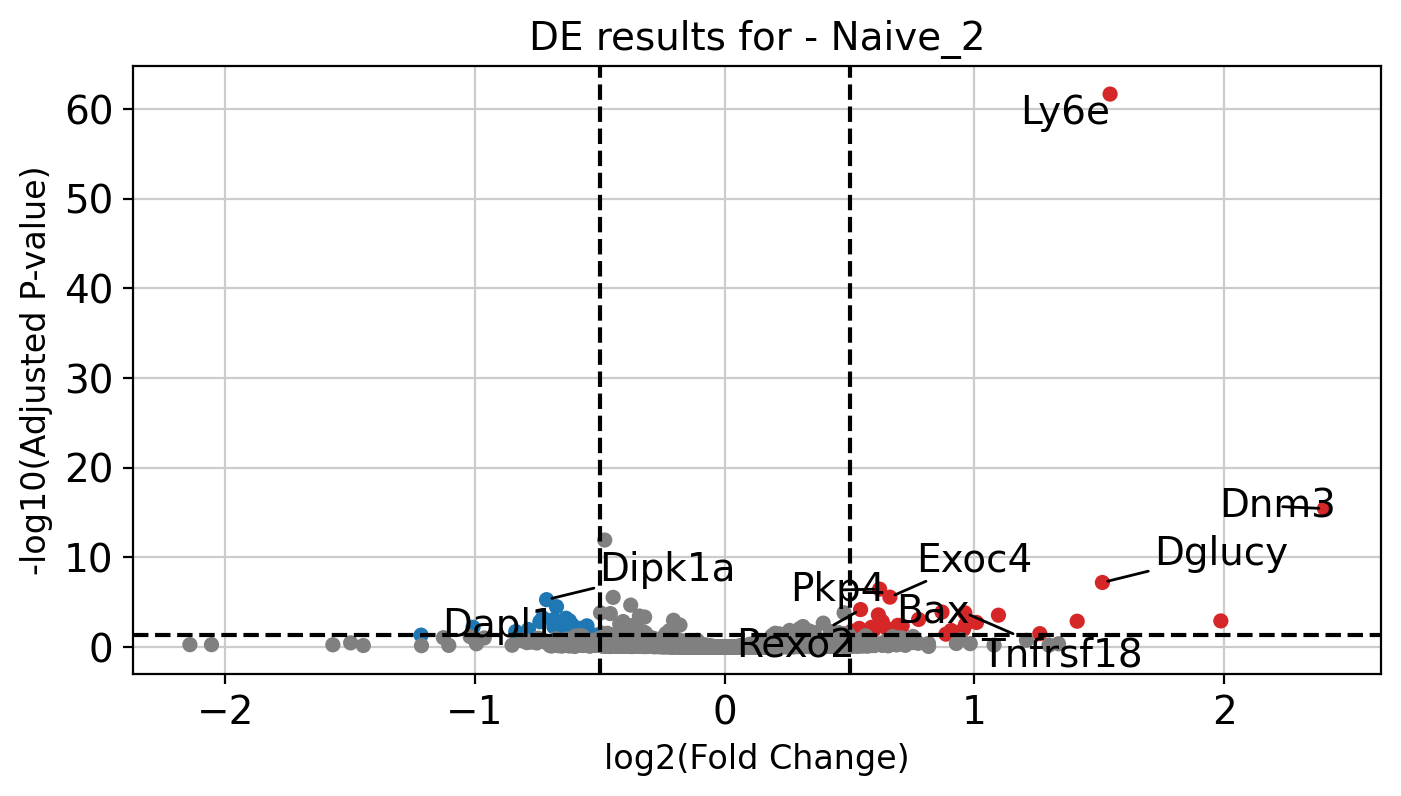

Fitting dispersions...
... done in 1.71 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.



<Figure size 960x640 with 0 Axes>

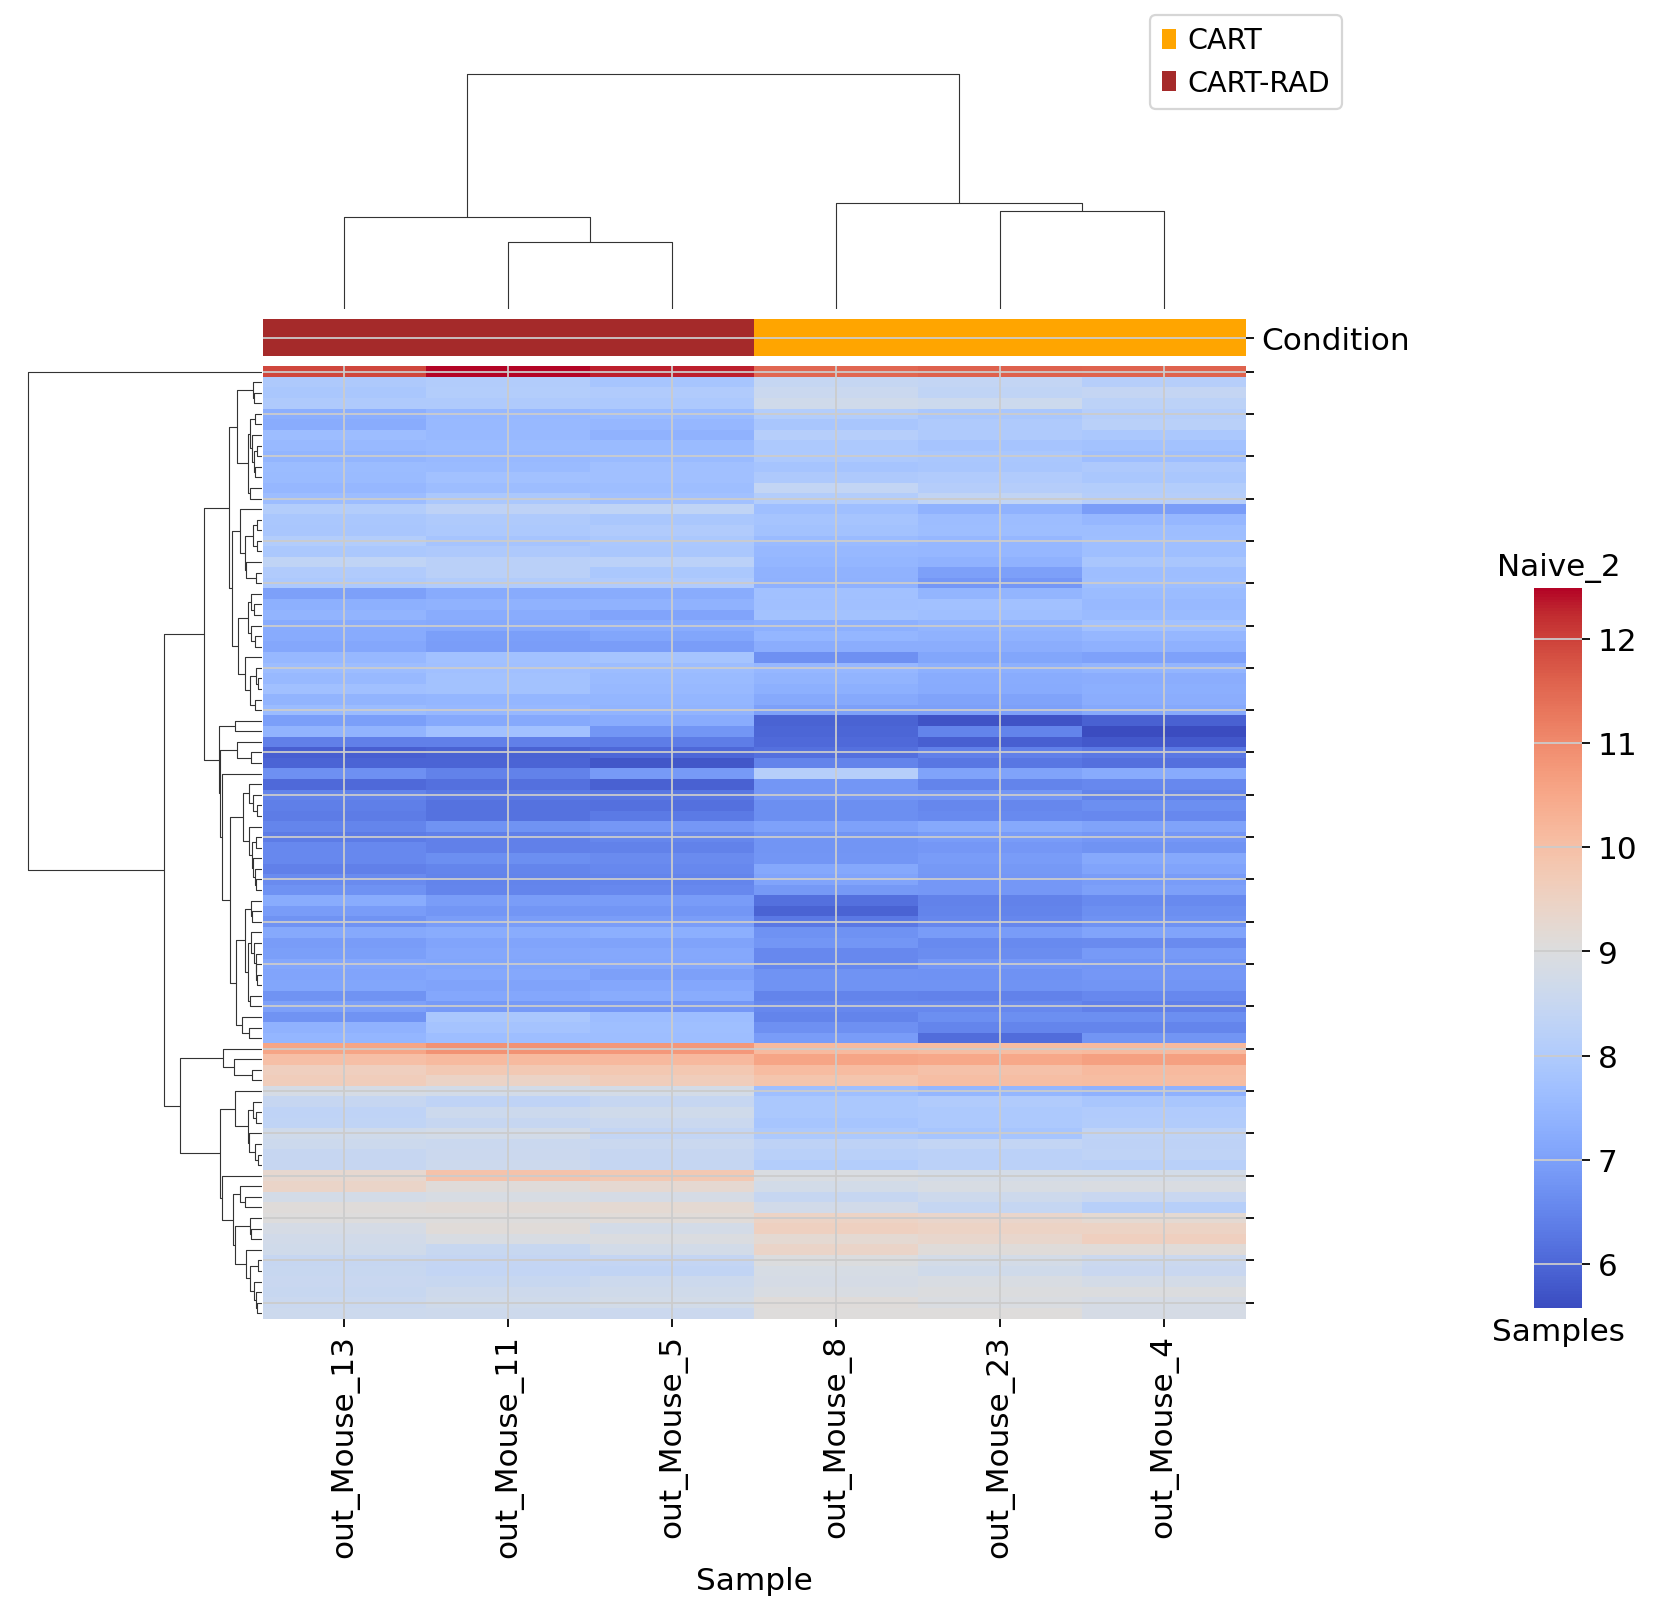

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.72 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 1.67 seconds.

Fitting LFCs...
... done in 1.16 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.90 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    10.806851       -0.358871  0.329425 -1.089389  0.275983   
0610010F05Rik    22.956781       -0.106989  0.237198 -0.451051  0.651953   
0610010K14Rik    89.264404        0.066724  0.130738  0.510363  0.609797   
0610012G03Rik    98.212425       -0.044434  0.246501 -0.180260  0.856948   
0610030E20Rik    34.923553       -0.068710  0.193200 -0.355641  0.722109   
...                    ...             ...       ...       ...       ...   
mt-Nd3          595.237793       -0.380171  0.445247 -0.853844  0.393192   
mt-Nd4         3636.049805        0.029112  0.137185  0.212207  0.831945   
mt-Nd4l         360.703827       -0.252737  0.206776 -1.222273  0.221604   
mt-Nd5         1214.812988        0.031263  0.095490  0.327397  0.743367   
mt-Nd6          151.319321        0.302963  0.235171  1.288266  0.197654   

                   pad

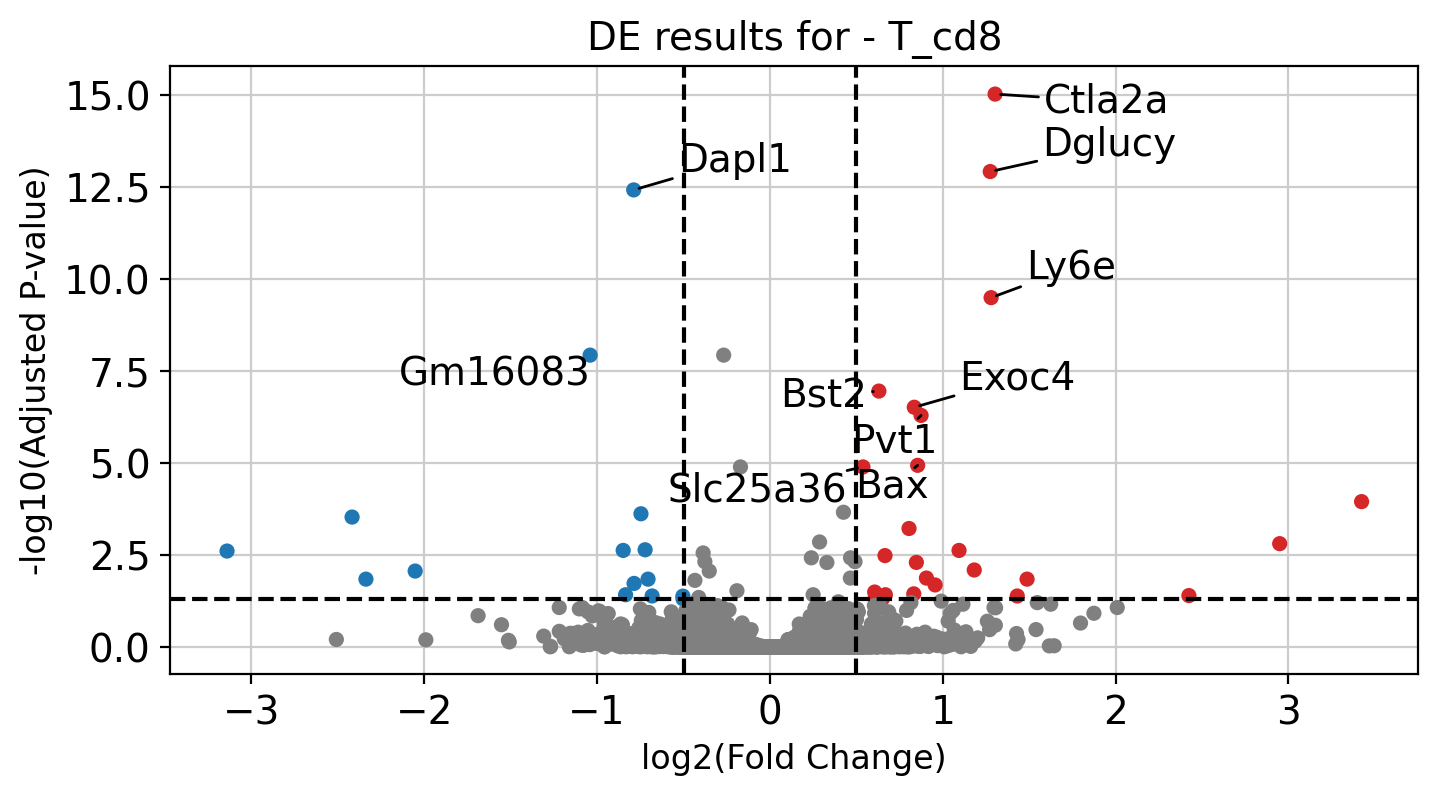

Fitting dispersions...
... done in 1.96 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.



<Figure size 960x640 with 0 Axes>

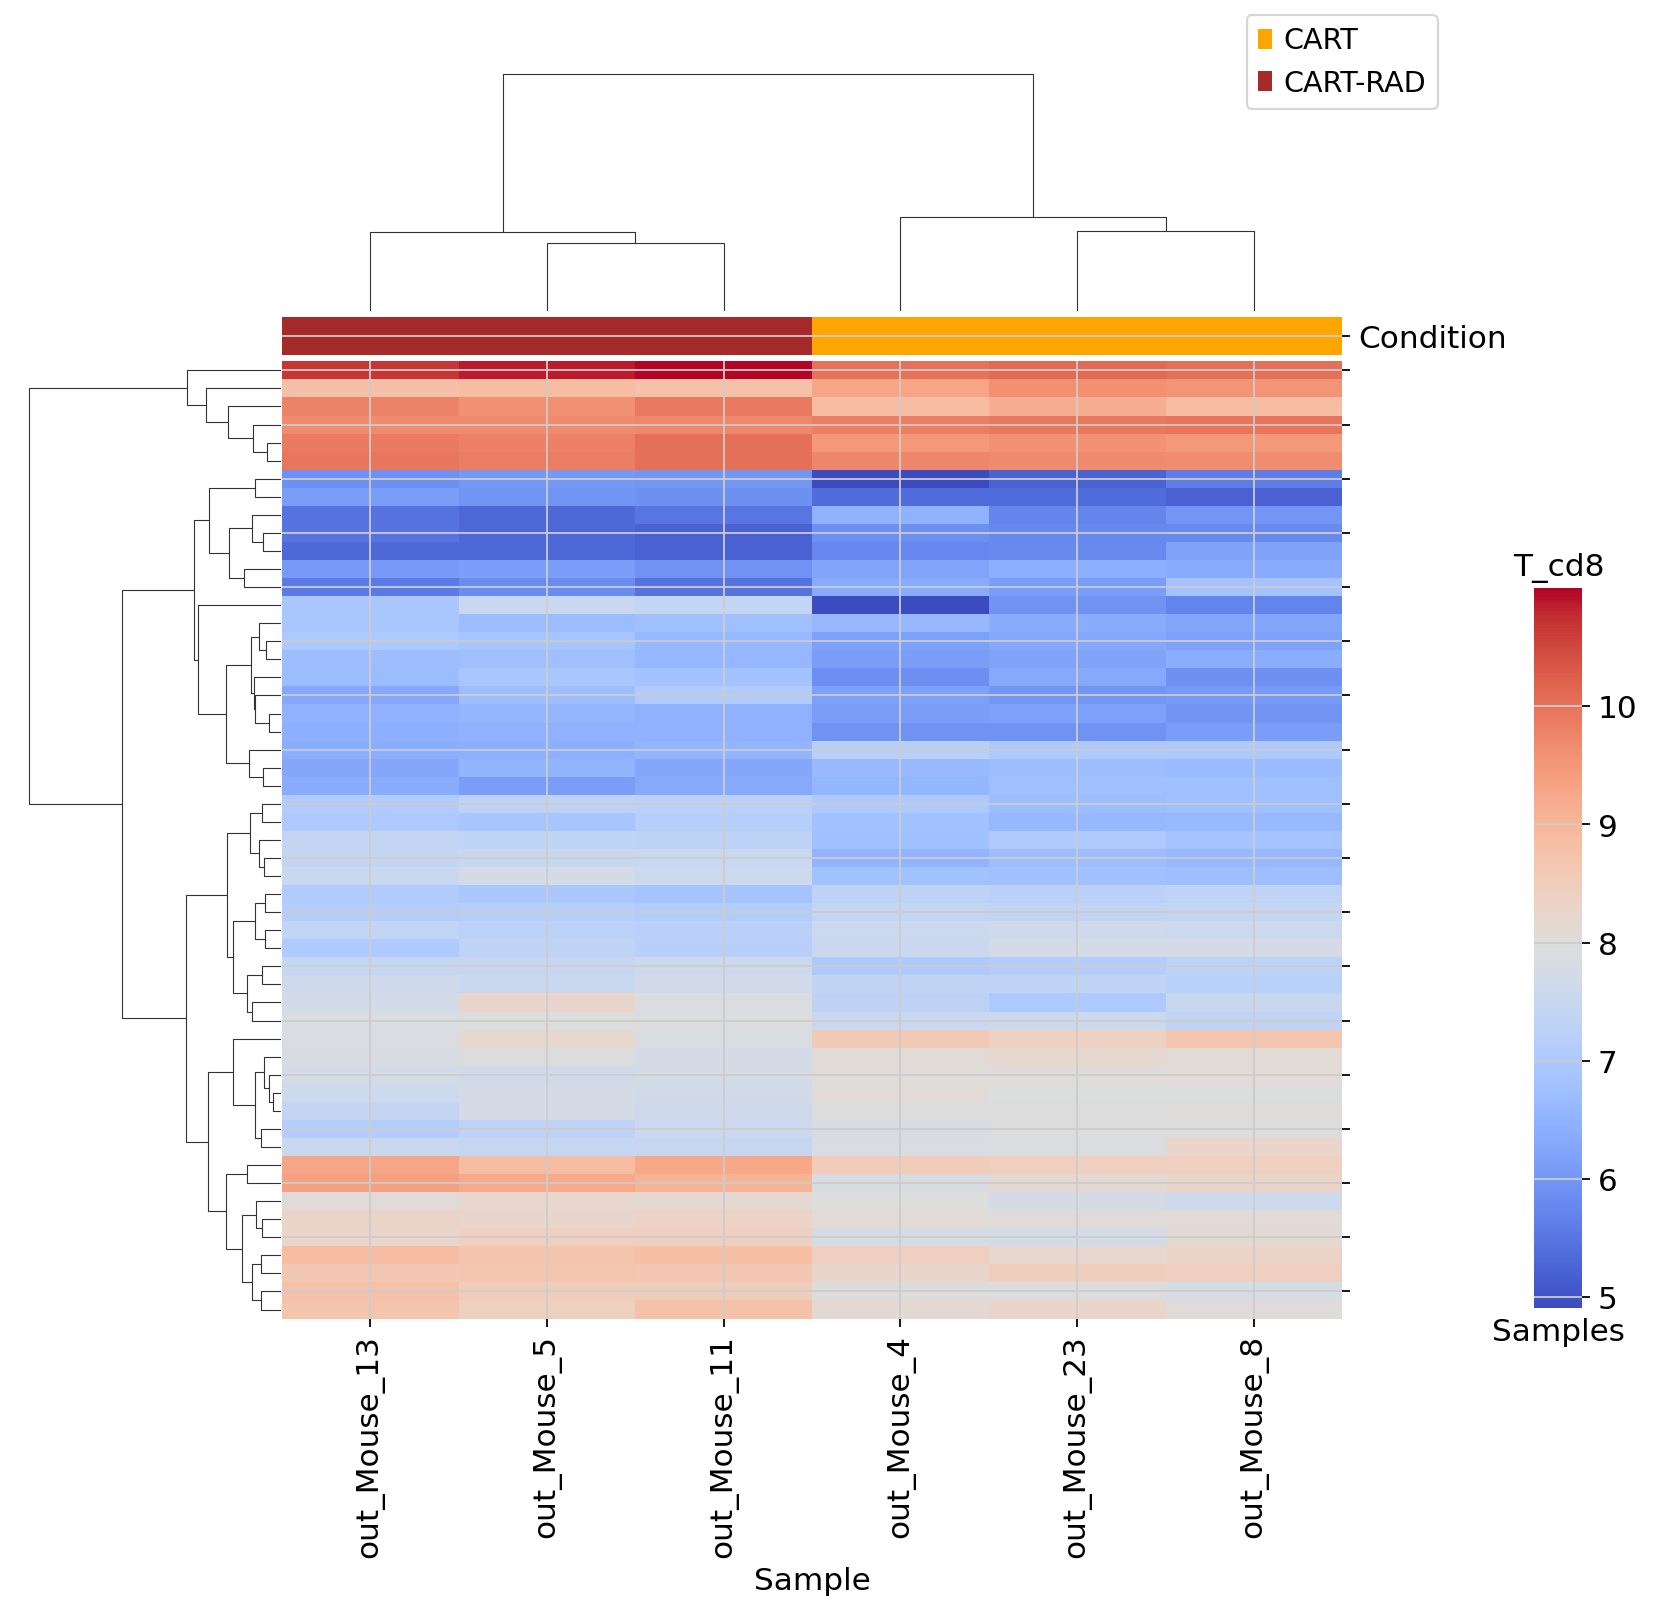

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.53 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 1.43 seconds.

Fitting LFCs...
... done in 1.16 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.90 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010F05Rik     9.958245        0.762638  0.473272  1.611414  0.107089   
0610010K14Rik    40.118690       -0.084064  0.213693 -0.393386  0.694034   
0610012G03Rik    30.155136        0.033918  0.296503  0.114393  0.908926   
0610030E20Rik    15.841370       -0.213452  0.382709 -0.557741  0.577022   
0610040B10Rik     9.697477        0.200288  0.563251  0.355592  0.722146   
...                    ...             ...       ...       ...       ...   
mt-Nd3          253.039246       -0.279423  0.481910 -0.579825  0.562033   
mt-Nd4         1442.922974        0.080520  0.117211  0.686966  0.492104   
mt-Nd4l         138.317795       -0.128944  0.222460 -0.579627  0.562166   
mt-Nd5          478.568481        0.087339  0.129164  0.676190  0.498920   
mt-Nd6           72.095970        0.393126  0.427343  0.919932  0.357608   

                   pad

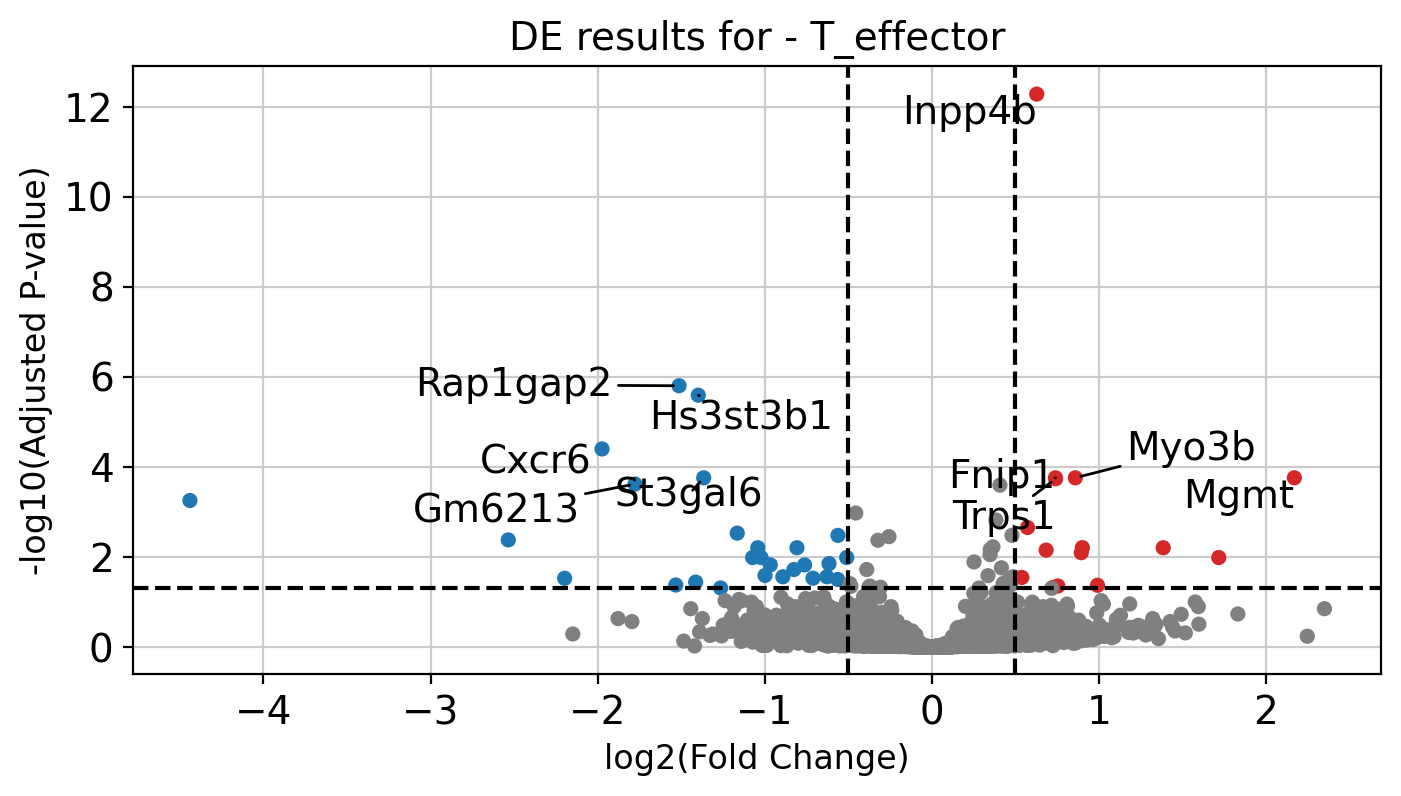

Fitting dispersions...
... done in 1.54 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.



<Figure size 960x640 with 0 Axes>

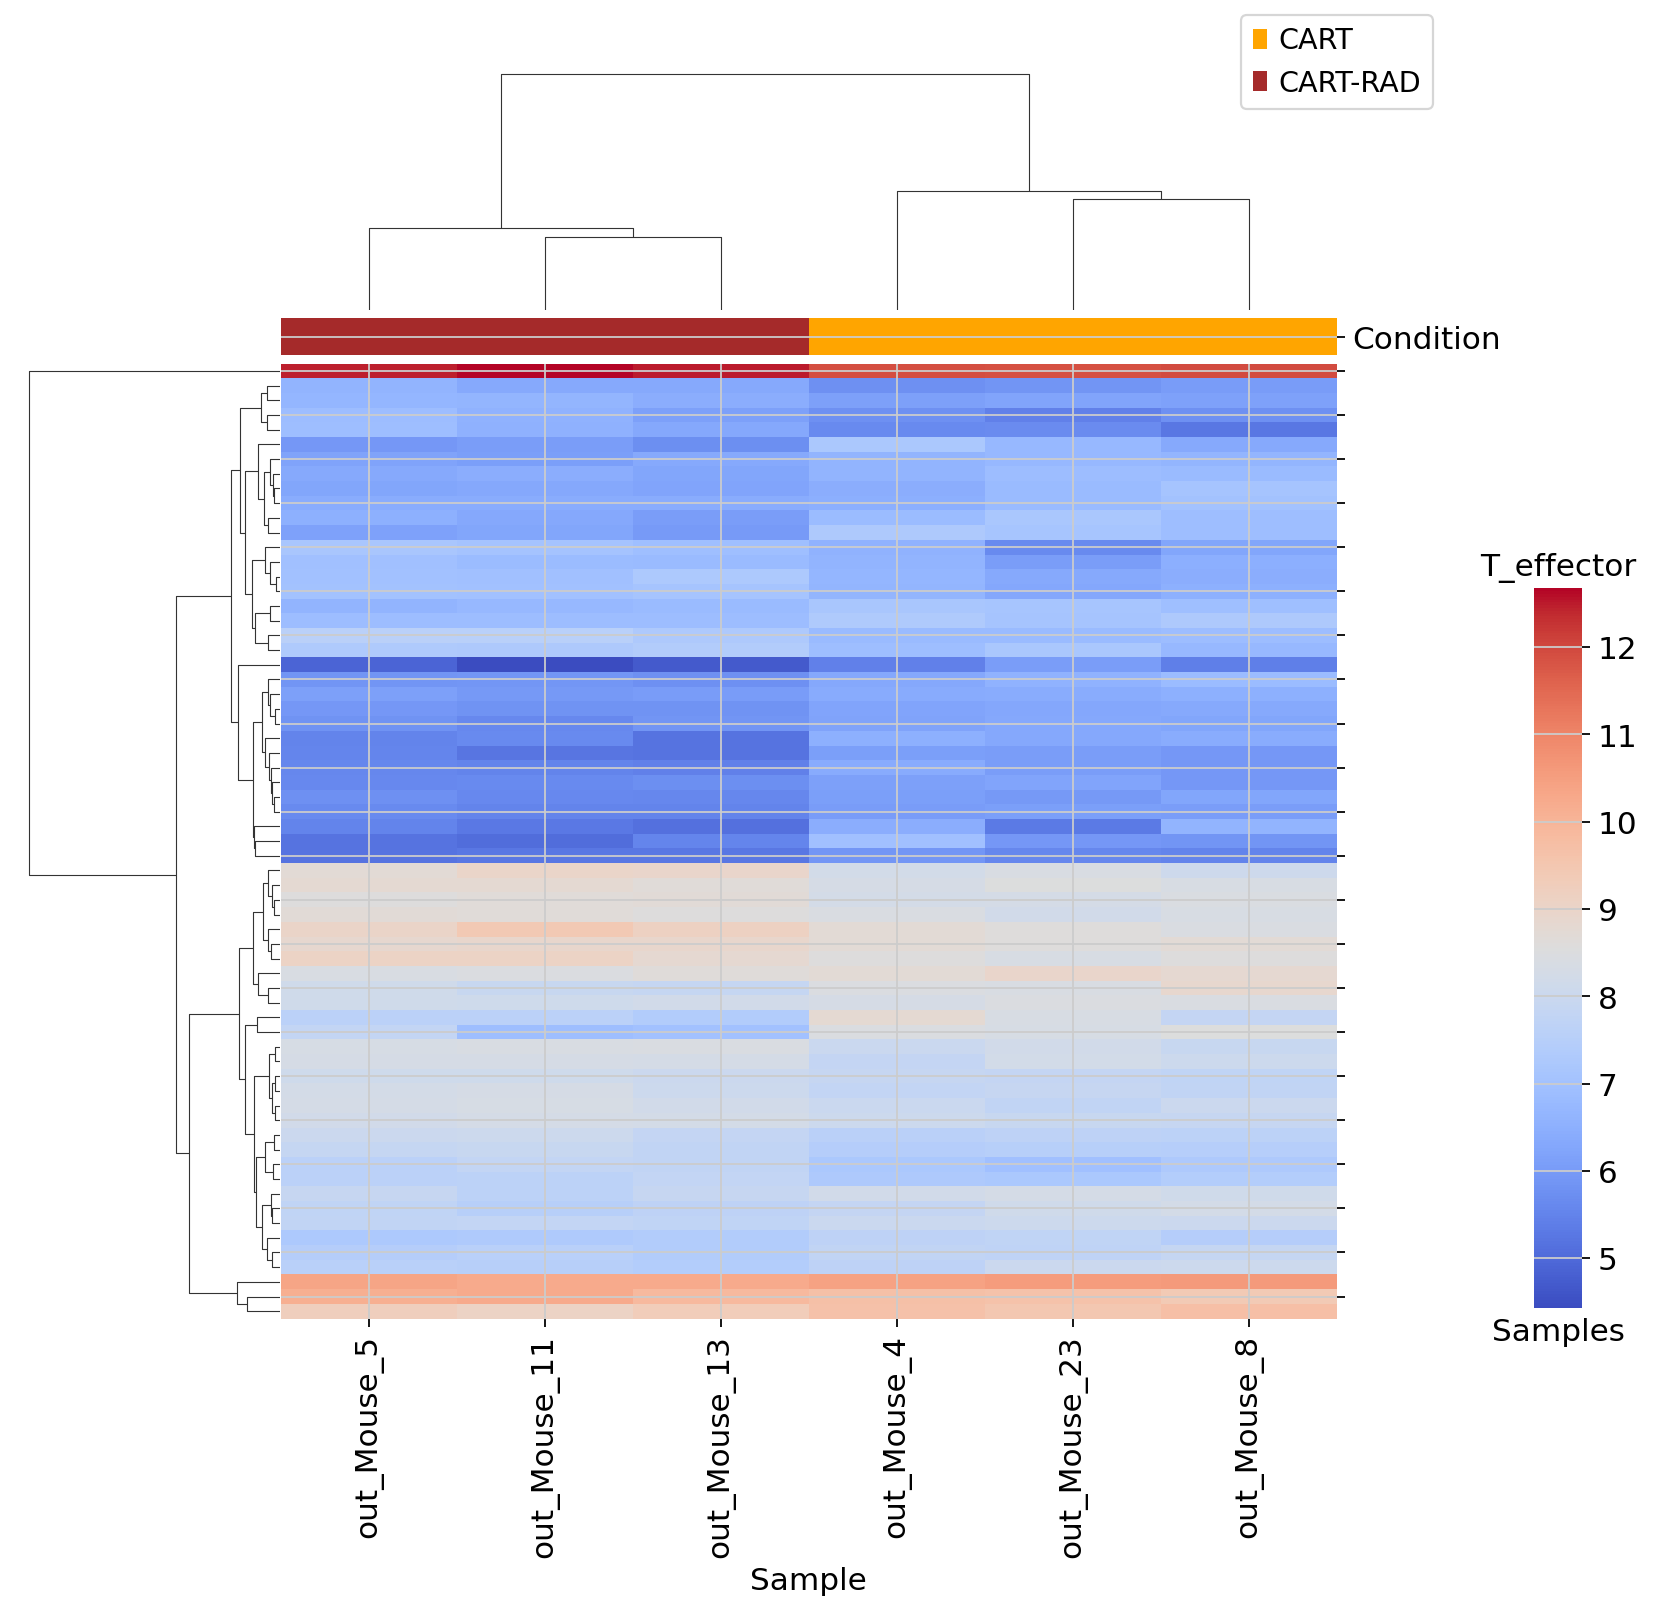

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.79 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 1.85 seconds.

Fitting LFCs...
... done in 1.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.19 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    22.315697       -0.679520  0.268830 -2.527691  0.011482   
0610010F05Rik    15.101646        0.098941  0.435388  0.227248  0.820231   
0610010K14Rik   141.301315        0.033310  0.149312  0.223087  0.823468   
0610012G03Rik   140.035690        0.048348  0.206630  0.233981  0.815000   
0610030E20Rik    52.112915       -0.334385  0.183473 -1.822533  0.068374   
...                    ...             ...       ...       ...       ...   
mt-Nd3          536.442505       -0.244549  0.434376 -0.562990  0.573442   
mt-Nd4         3636.988281        0.120907  0.112528  1.074459  0.282617   
mt-Nd4l         366.093719       -0.117481  0.212810 -0.552046  0.580917   
mt-Nd5         1237.328003        0.055032  0.103587  0.531266  0.595234   
mt-Nd6          163.579834        0.219466  0.278925  0.786830  0.431381   

                   pad

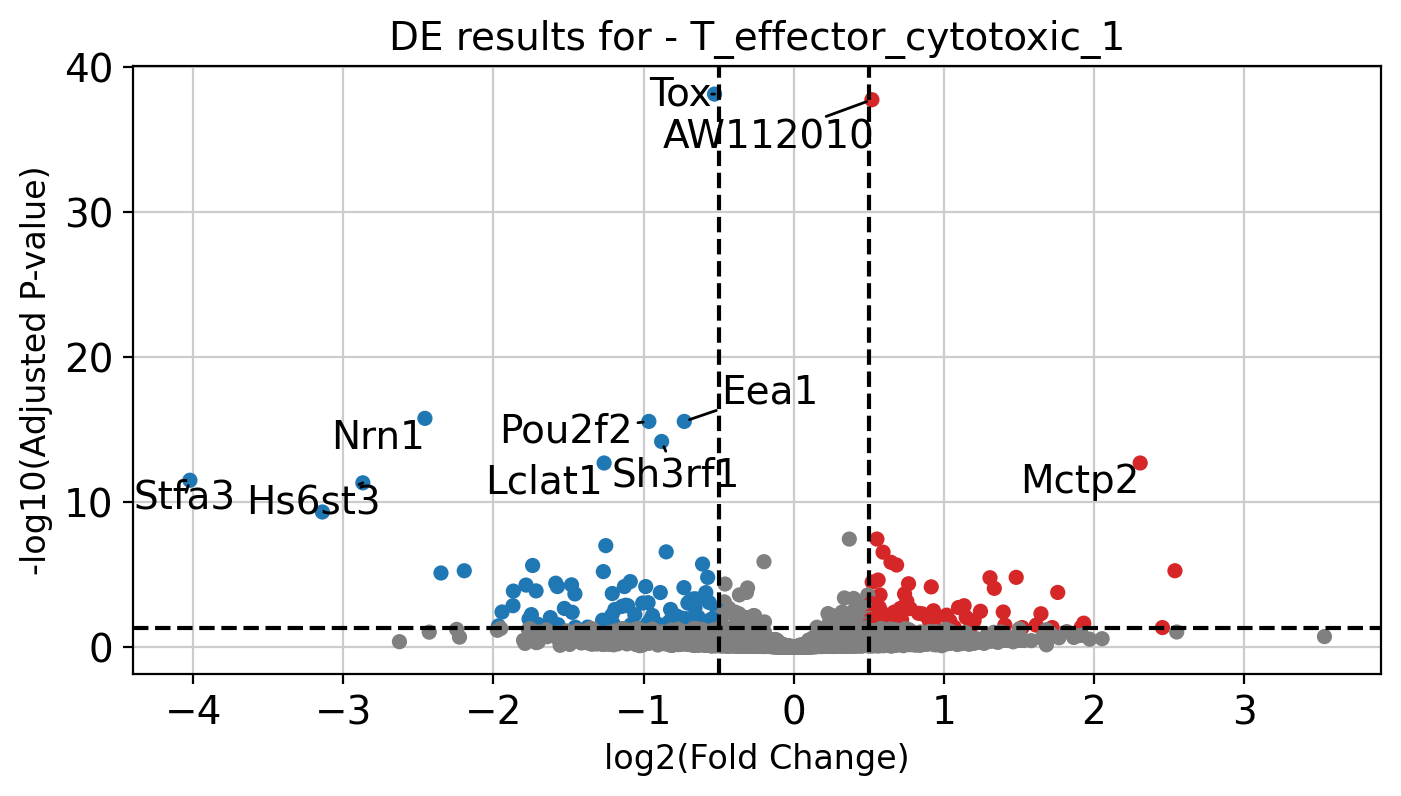

Fitting dispersions...
... done in 1.74 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.



<Figure size 960x640 with 0 Axes>

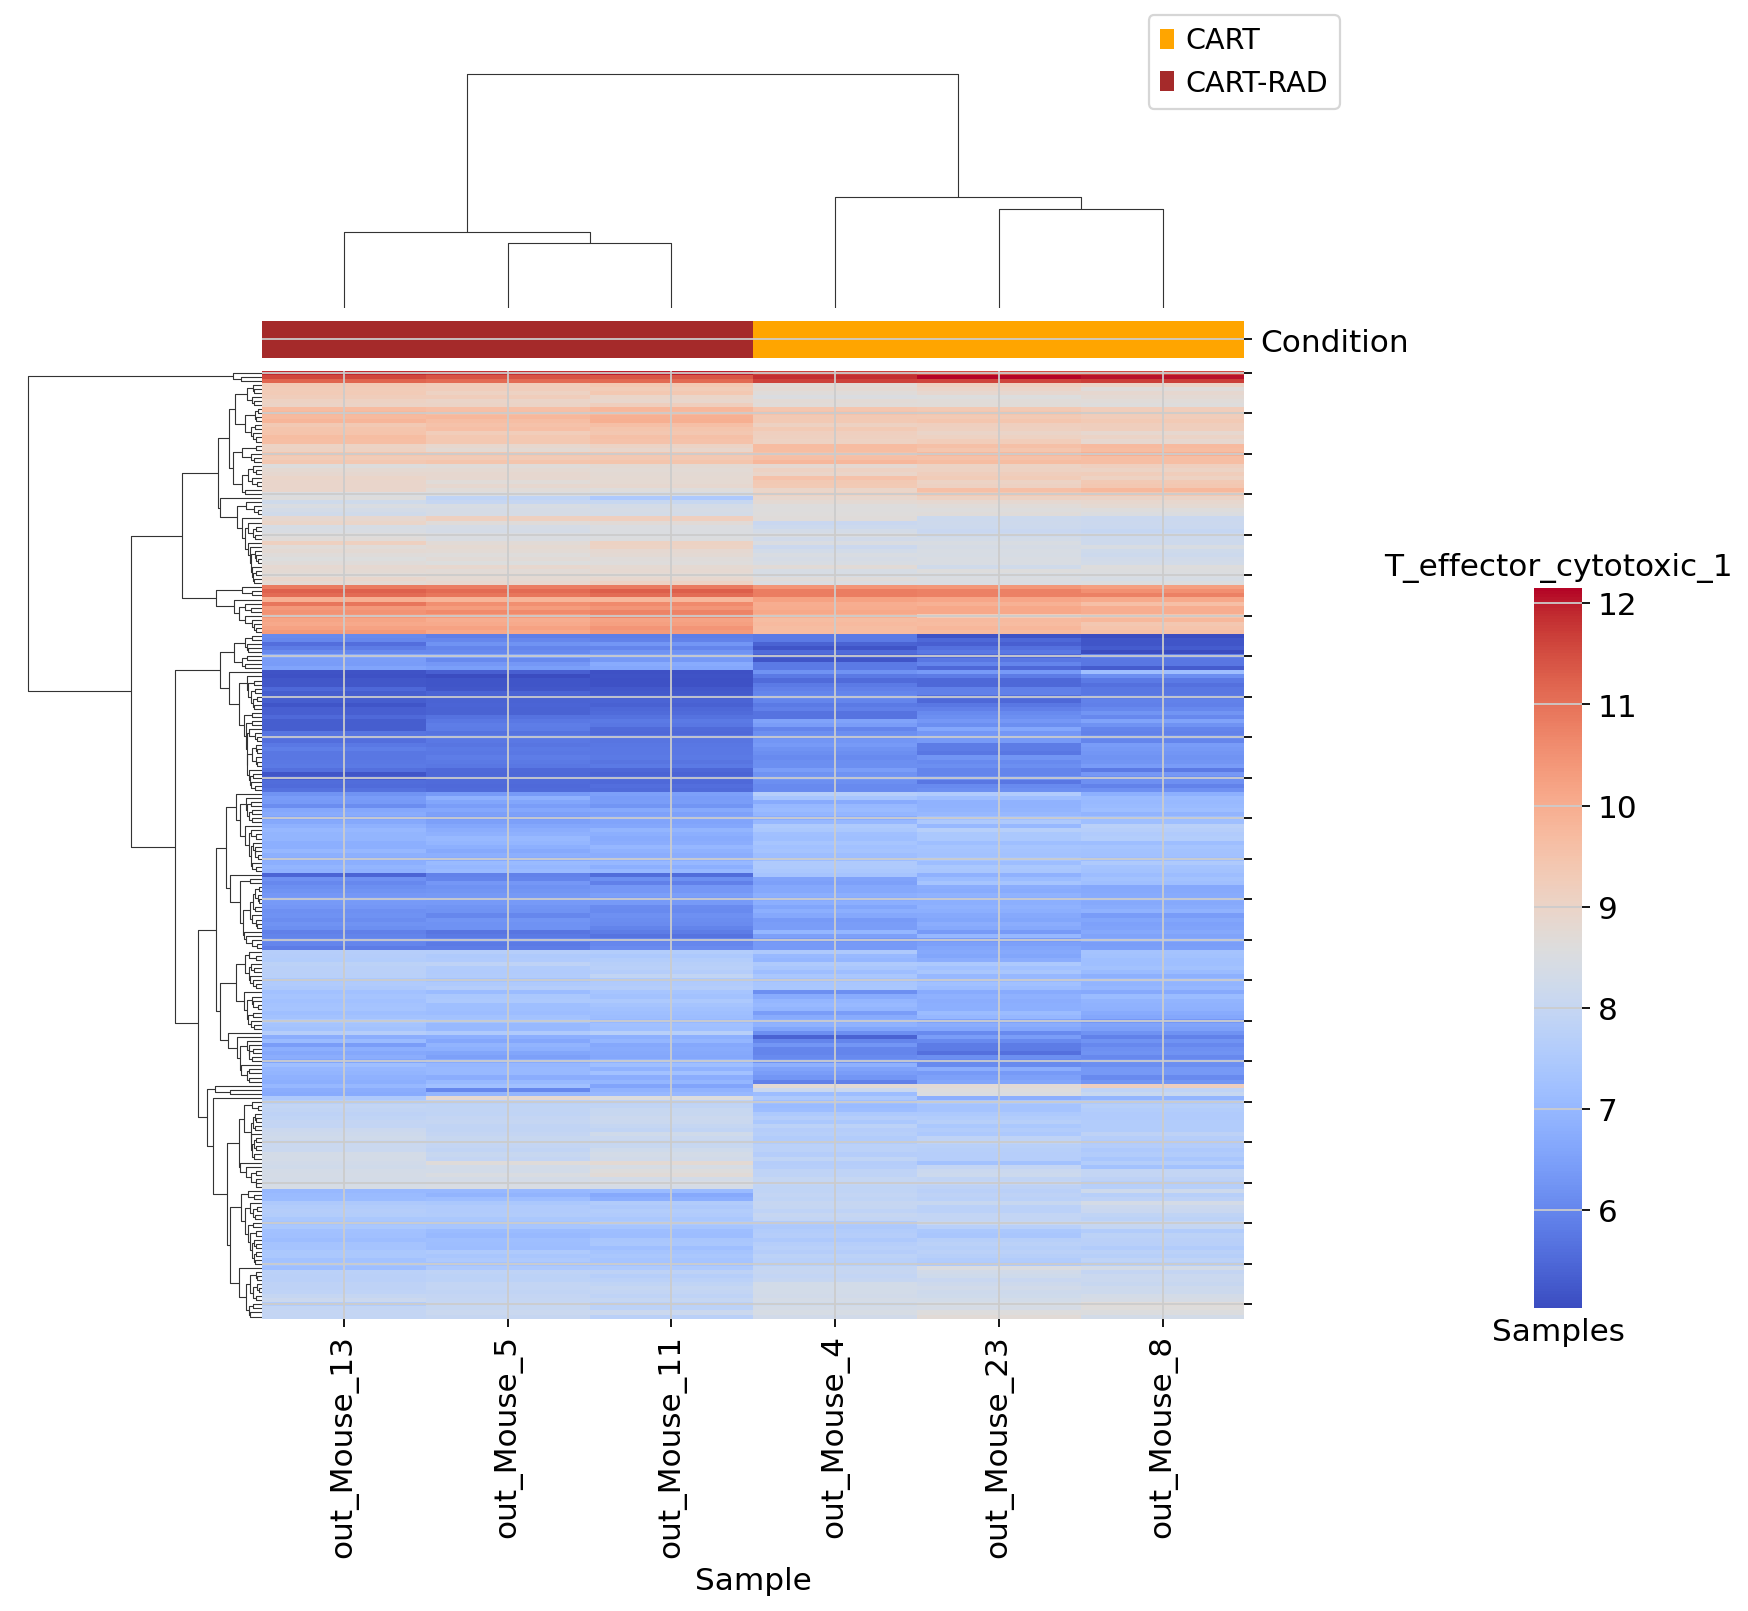

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.68 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 1.63 seconds.

Fitting LFCs...
... done in 1.17 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    24.892548       -0.445504  0.326750 -1.363443  0.172743   
0610010F05Rik    19.239431        0.212096  0.438422  0.483771  0.628548   
0610010K14Rik   164.660965        0.051756  0.120251  0.430398  0.666906   
0610012G03Rik   114.148560        0.386378  0.201157  1.920782  0.054759   
0610030E20Rik    39.981129       -0.258494  0.292698 -0.883141  0.377160   
...                    ...             ...       ...       ...       ...   
mt-Nd3          447.767914       -0.333780  0.346627 -0.962938  0.335579   
mt-Nd4         2657.927246        0.106374  0.092033  1.155819  0.247755   
mt-Nd4l         307.869324       -0.108723  0.292369 -0.371868  0.709991   
mt-Nd5          888.708801        0.161696  0.101327  1.595779  0.110538   
mt-Nd6          115.457634        0.194261  0.302348  0.642508  0.520543   

                   pad

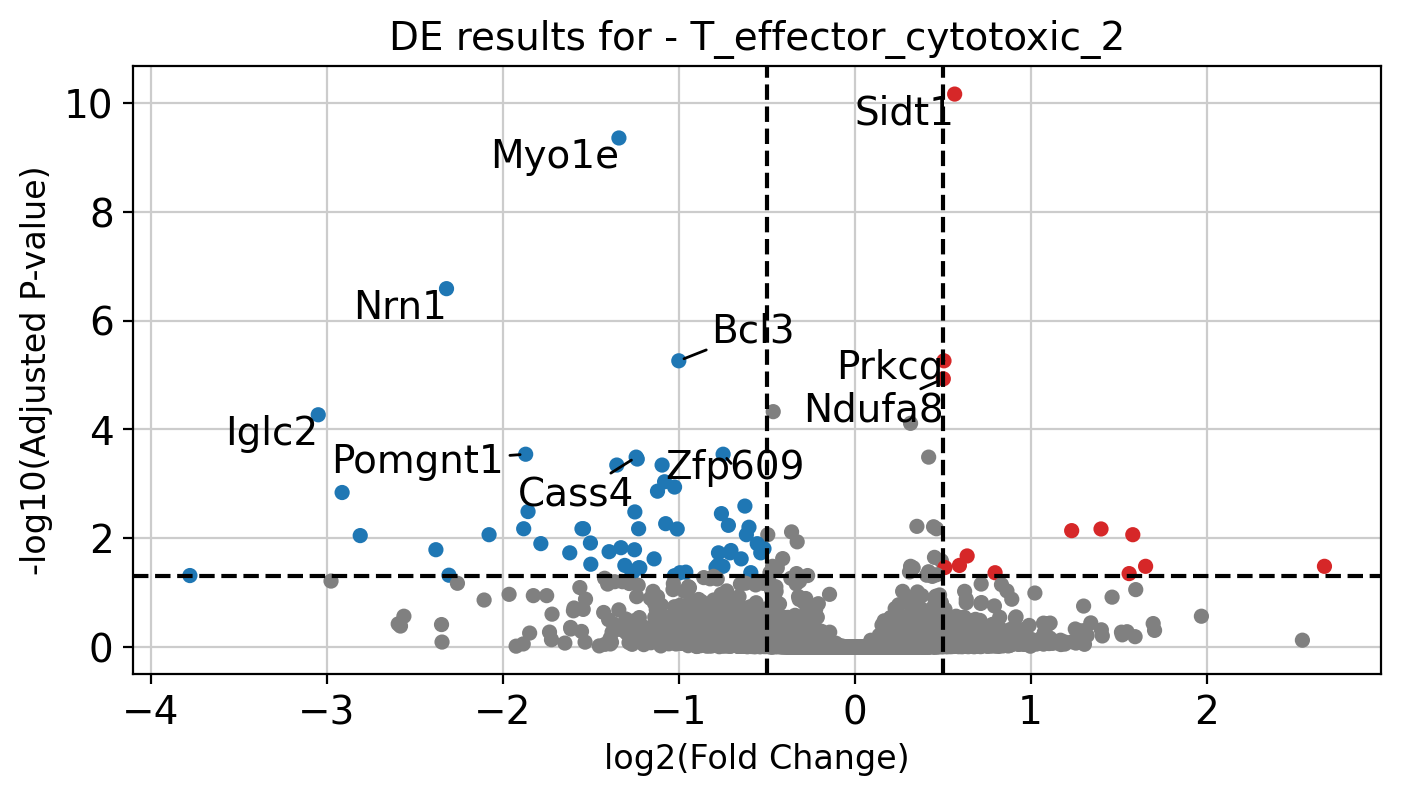

Fitting dispersions...
... done in 1.63 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.



<Figure size 960x640 with 0 Axes>

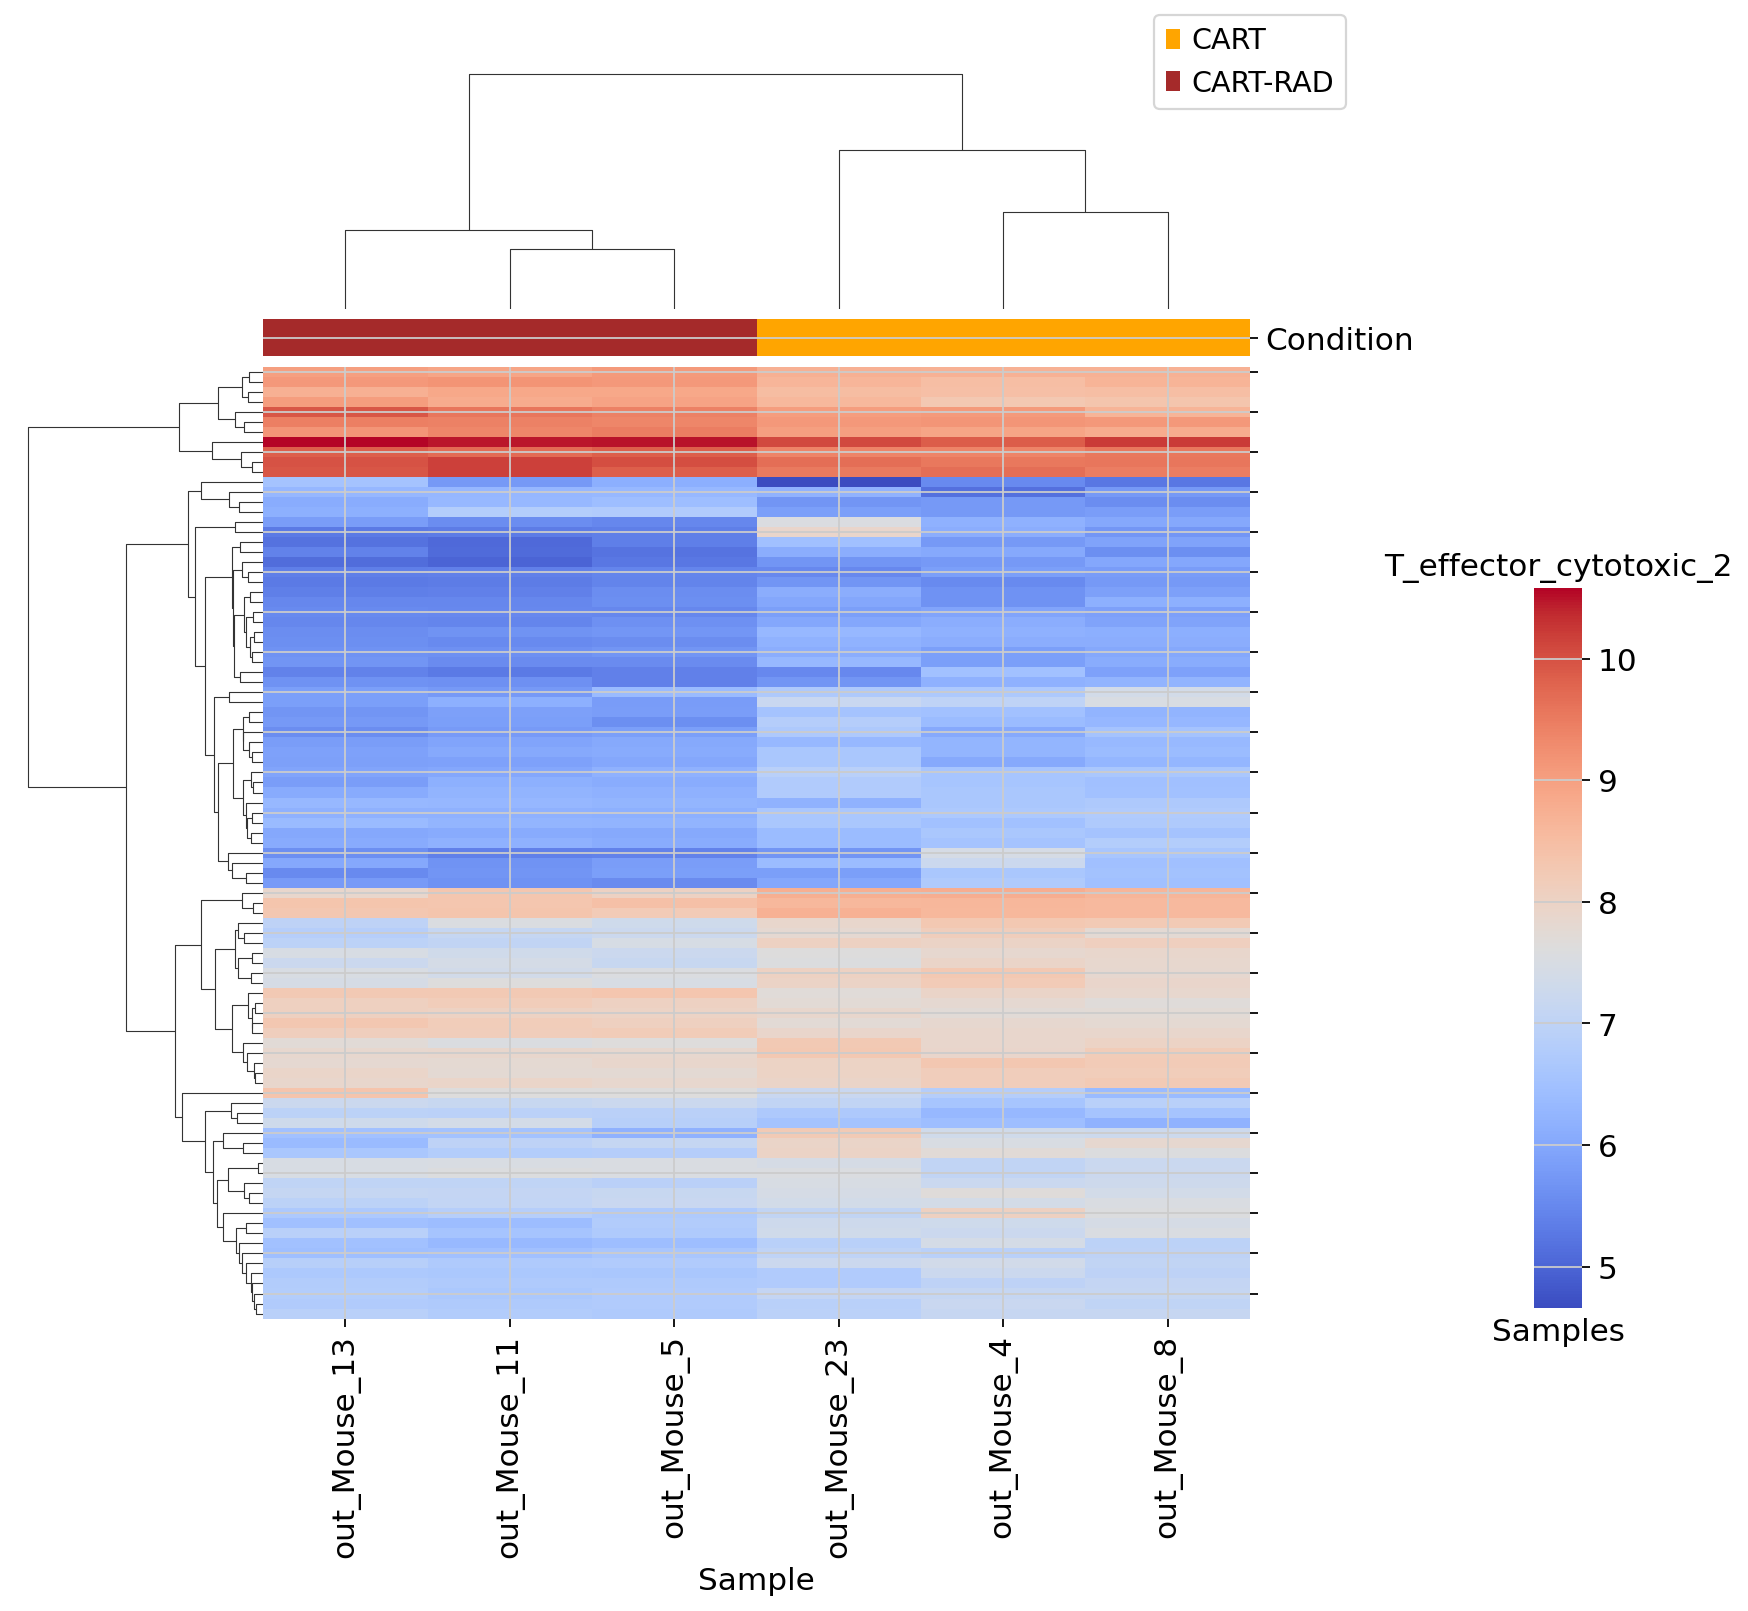

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.59 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 1.46 seconds.

Fitting LFCs...
... done in 1.07 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.89 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010K14Rik    71.425789       -0.069421  0.202611 -0.342629  0.731878   
0610012G03Rik    60.436890        0.161190  0.261204  0.617102  0.537168   
0610030E20Rik    16.098608        0.003955  0.369555  0.010703  0.991460   
0610040B10Rik    14.797618       -0.729007  0.432170 -1.686852  0.091632   
0610043K17Rik    11.329815       -0.017710  0.479832 -0.036909  0.970557   
...                    ...             ...       ...       ...       ...   
mt-Nd3          262.861908       -0.577755  0.354616 -1.629244  0.103261   
mt-Nd4         1597.102539       -0.122518  0.185858 -0.659202  0.509766   
mt-Nd4l         173.606735       -0.570517  0.262876 -2.170288  0.029985   
mt-Nd5          520.898499       -0.157417  0.180331 -0.872932  0.382700   
mt-Nd6           50.581646        0.175299  0.328625  0.533432  0.593735   

                   pad

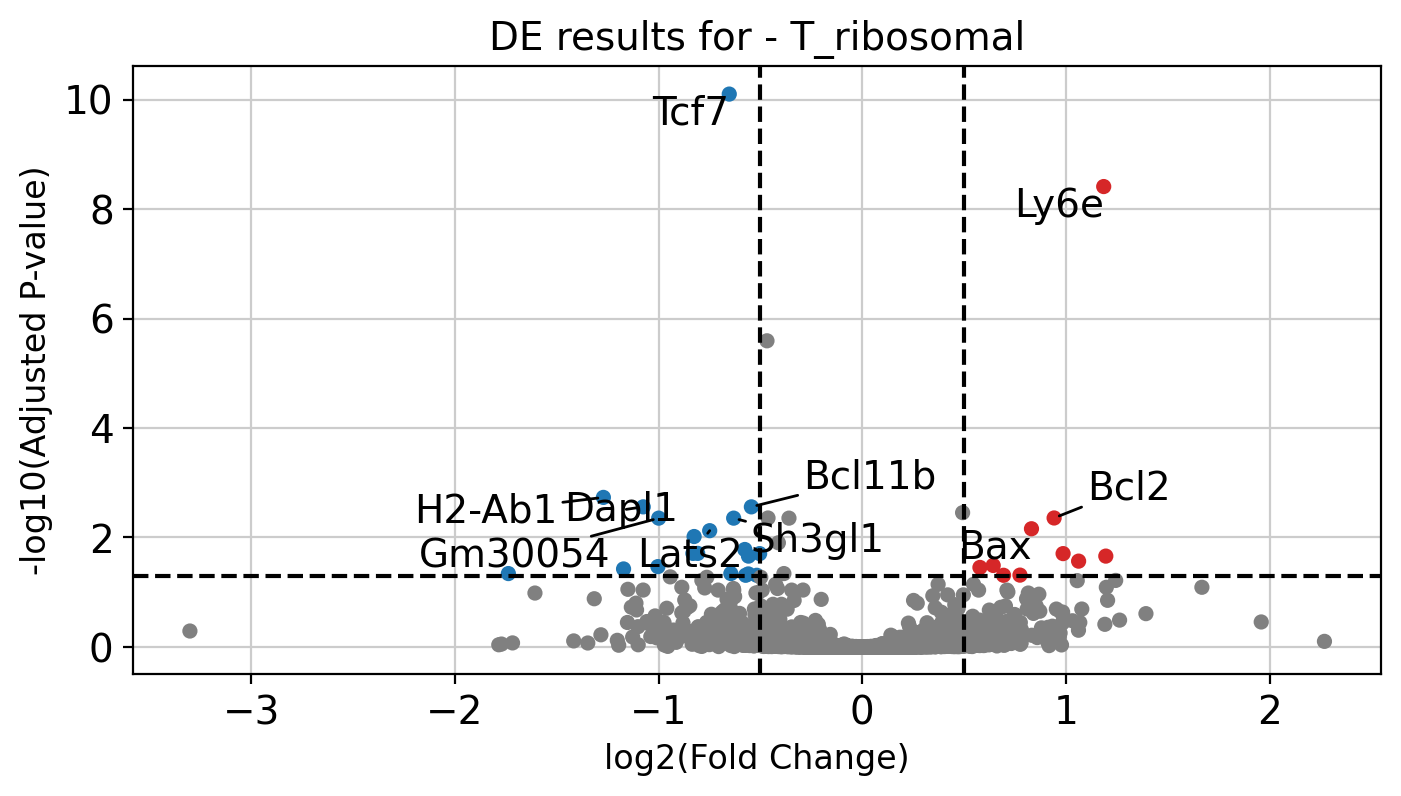

Fitting dispersions...
... done in 1.62 seconds.

Fitting dispersion trend curve...
... done in 0.17 seconds.



<Figure size 960x640 with 0 Axes>

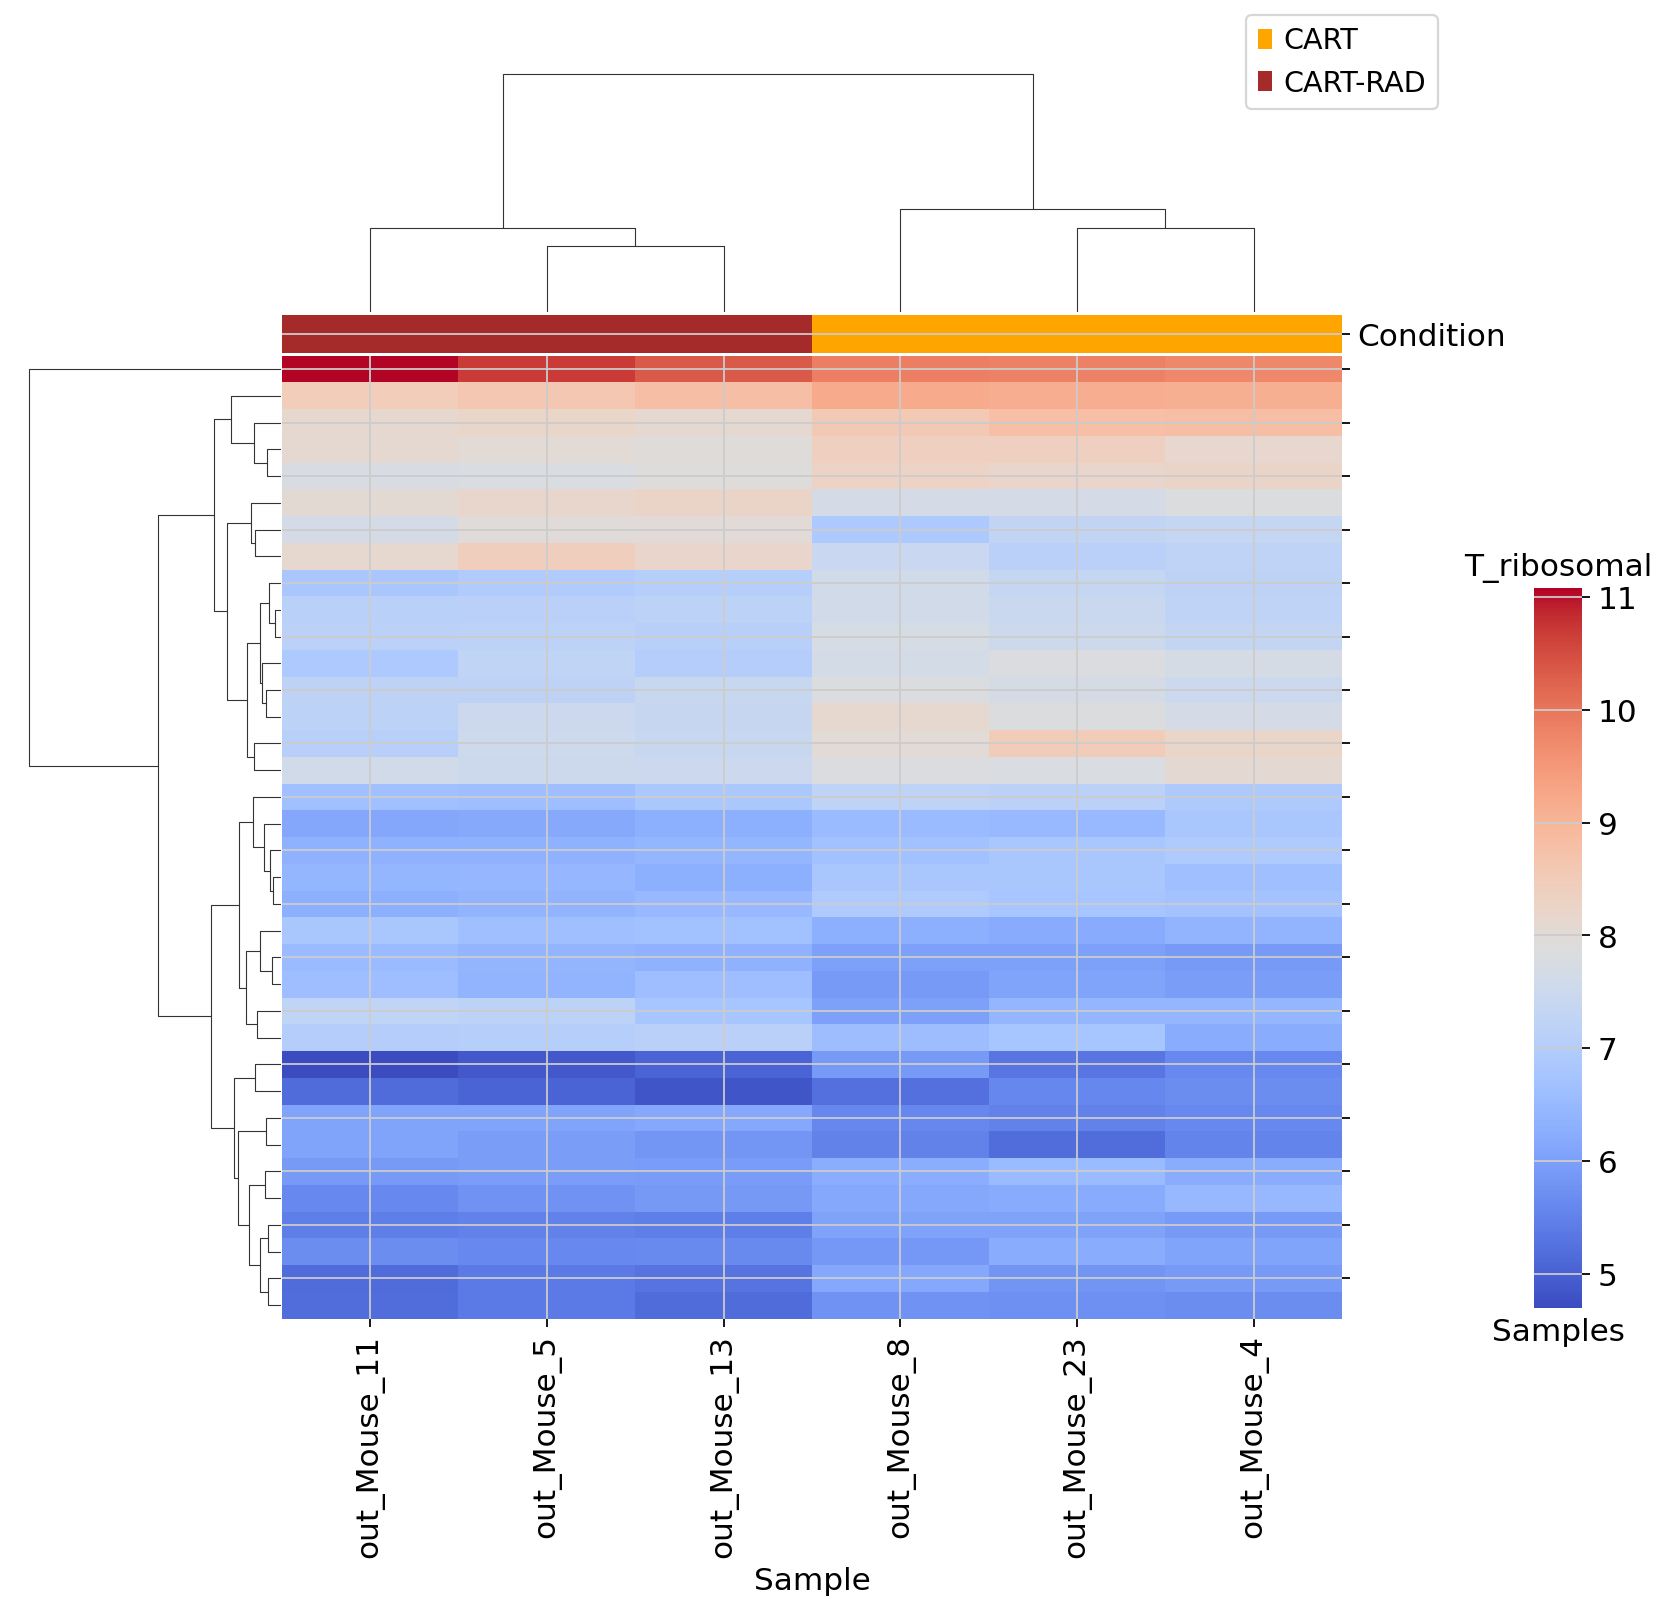

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.25 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 1.13 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.83 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010K14Rik   13.201184       -0.167471  0.446193 -0.375332  0.707413   
0610012G03Rik   10.494599        0.234906  0.361276  0.650212  0.515555   
1110004F10Rik   31.344023        0.058141  0.372577  0.156052  0.875992   
1110008P14Rik   10.902180        0.061785  0.535284  0.115424  0.908109   
1110038B12Rik    8.847753        0.512305  0.554590  0.923754  0.355614   
...                   ...             ...       ...       ...       ...   
mt-Nd3          73.278778       -0.411937  0.431474 -0.954721  0.339719   
mt-Nd4         517.050110       -0.268021  0.101085 -2.651432  0.008015   
mt-Nd4l         48.192142       -0.510374  0.348319 -1.465248  0.142853   
mt-Nd5         172.664017       -0.194800  0.118621 -1.642199  0.100549   
mt-Nd6          17.688377        0.738342  0.430382  1.715550  0.086245   

                   padj  
0610010K

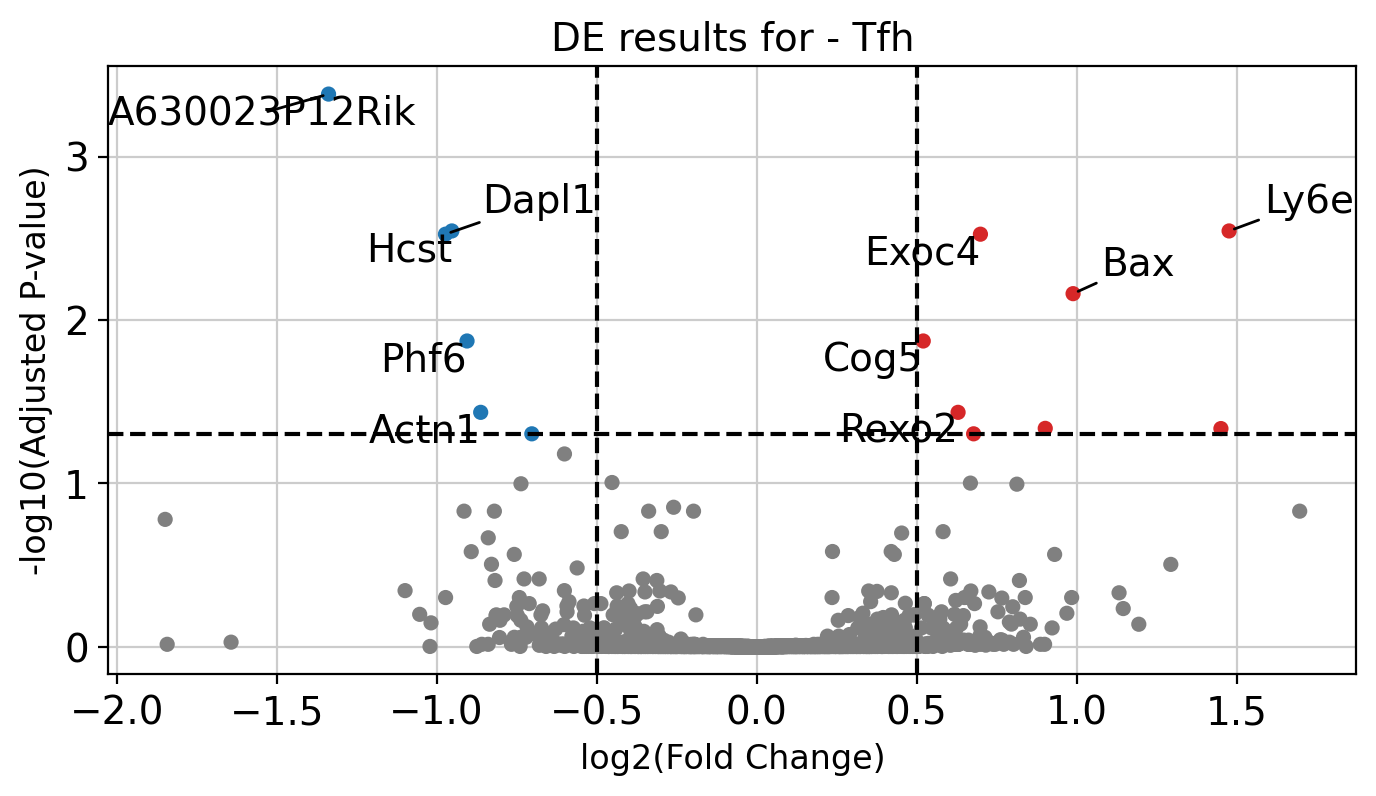

Fitting dispersions...
... done in 1.36 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.



<Figure size 960x640 with 0 Axes>

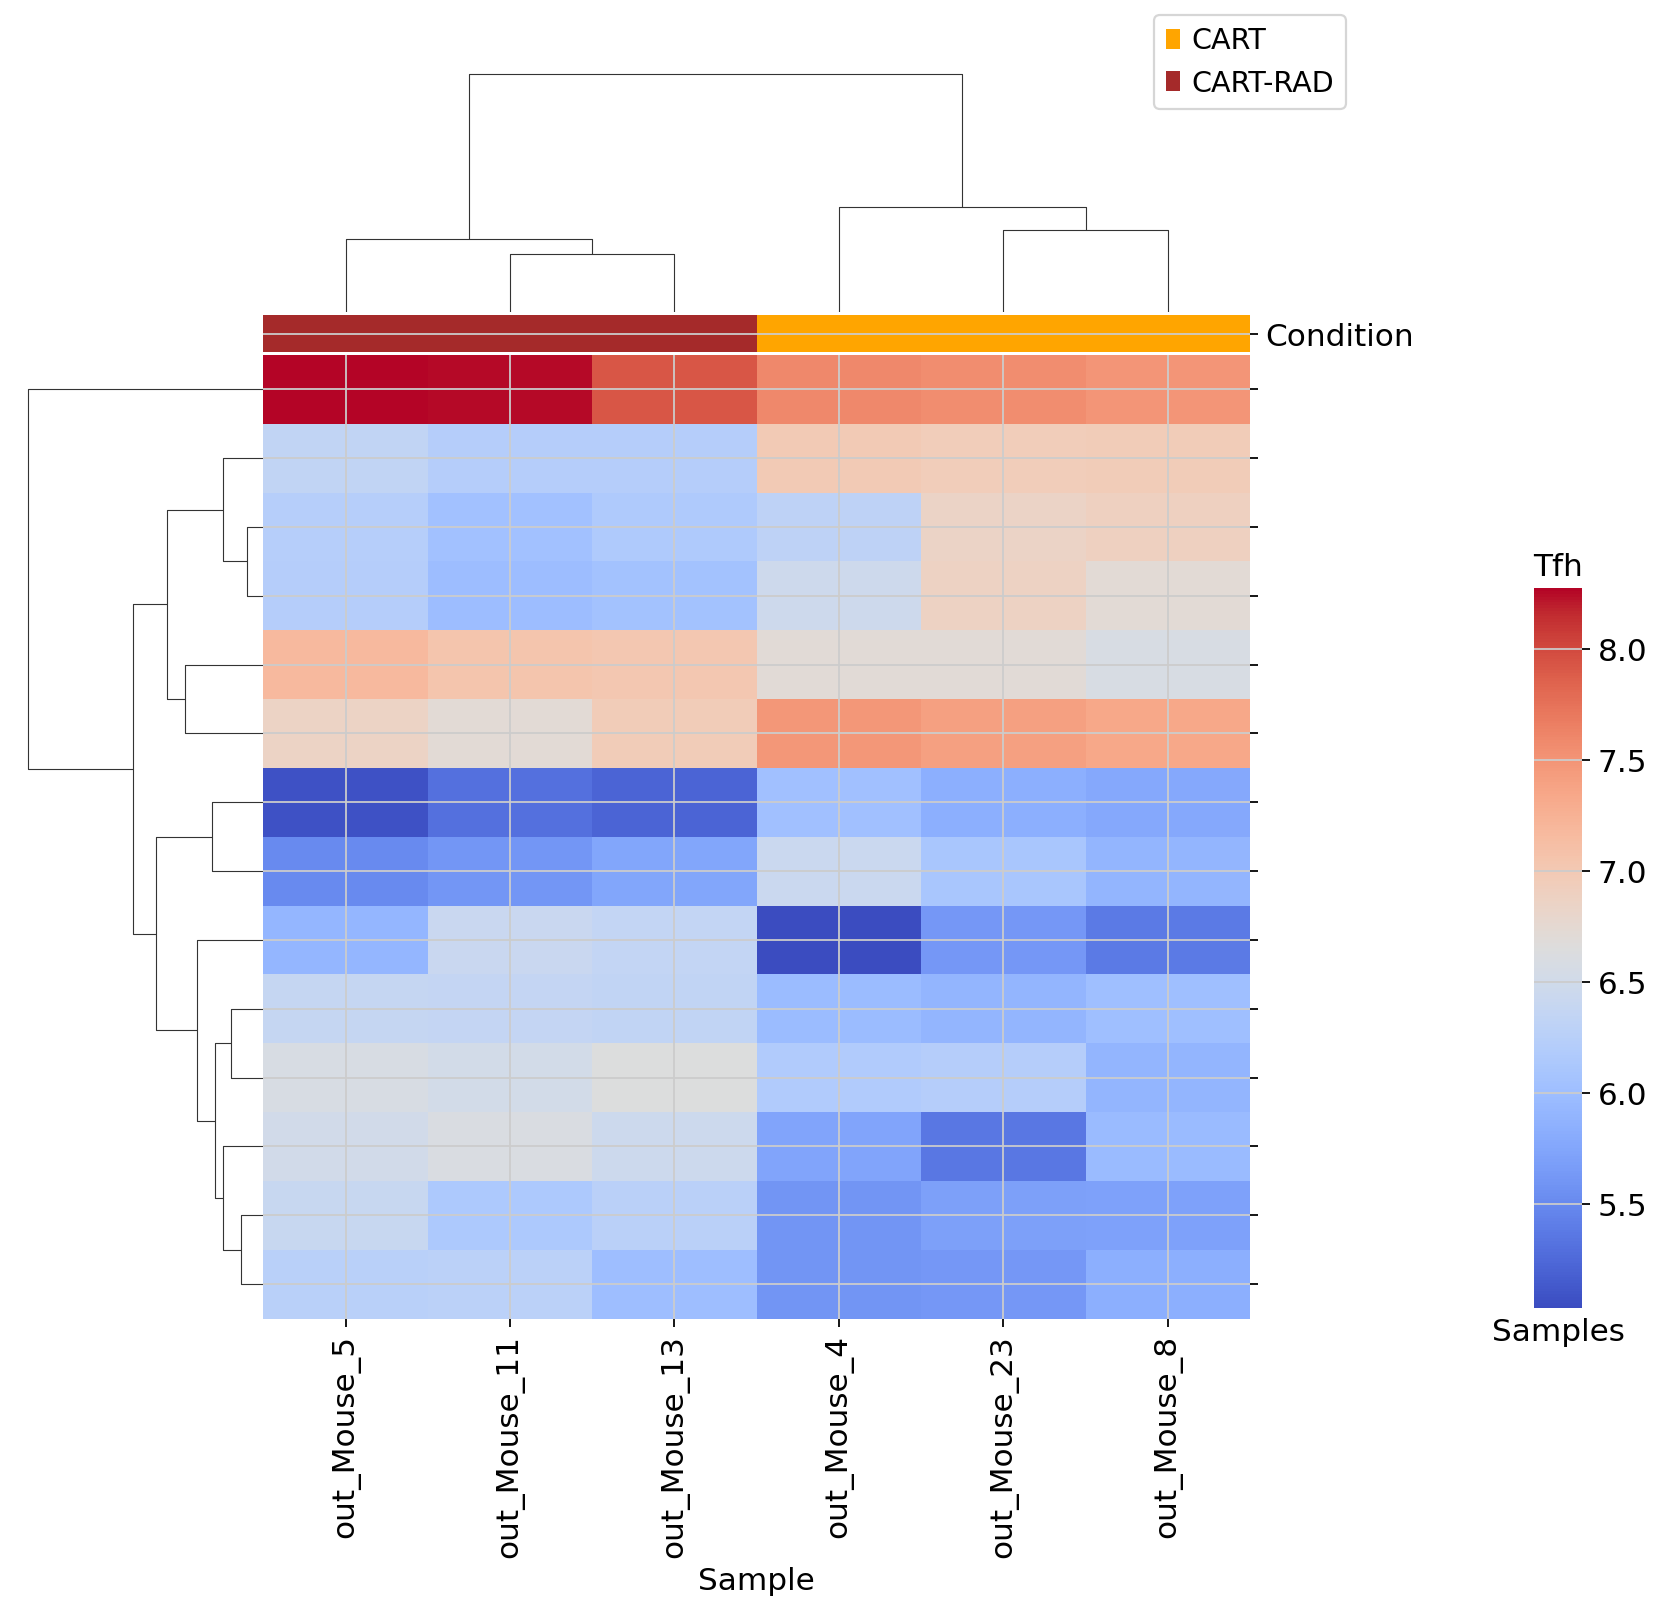

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.50 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 1.37 seconds.

Fitting LFCs...
... done in 1.17 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.96 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010K14Rik    31.338297        0.099830  0.339374  0.294160  0.768636   
0610012G03Rik    28.215956        0.055703  0.240995  0.231139  0.817207   
0610030E20Rik    11.369561        0.159307  0.451219  0.353059  0.724044   
0610040B10Rik     9.592381       -0.356756  0.536499 -0.664970  0.506070   
0610043K17Rik    10.994446       -0.508979  0.476251 -1.068720  0.285196   
...                    ...             ...       ...       ...       ...   
mt-Nd3          114.168175       -0.528906  0.364021 -1.452954  0.146236   
mt-Nd4         1017.602600       -0.050054  0.122649 -0.408108  0.683194   
mt-Nd4l          90.799248       -0.056084  0.279555 -0.200620  0.840996   
mt-Nd5          302.491364        0.088202  0.135143  0.652656  0.513978   
mt-Nd6           47.850628        0.391862  0.231694  1.691289  0.090782   

                   pad

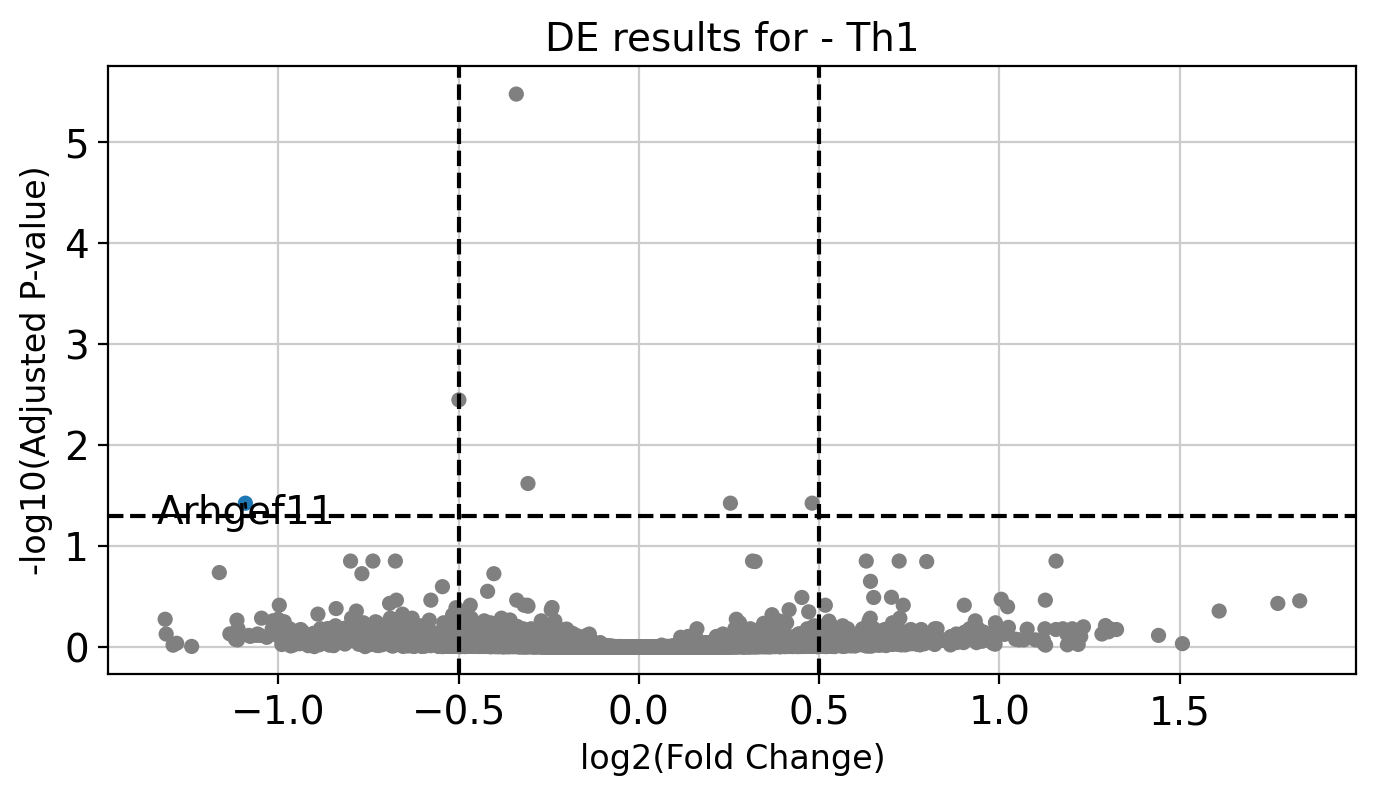

Fitting dispersions...
... done in 1.48 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.



<Figure size 960x640 with 0 Axes>

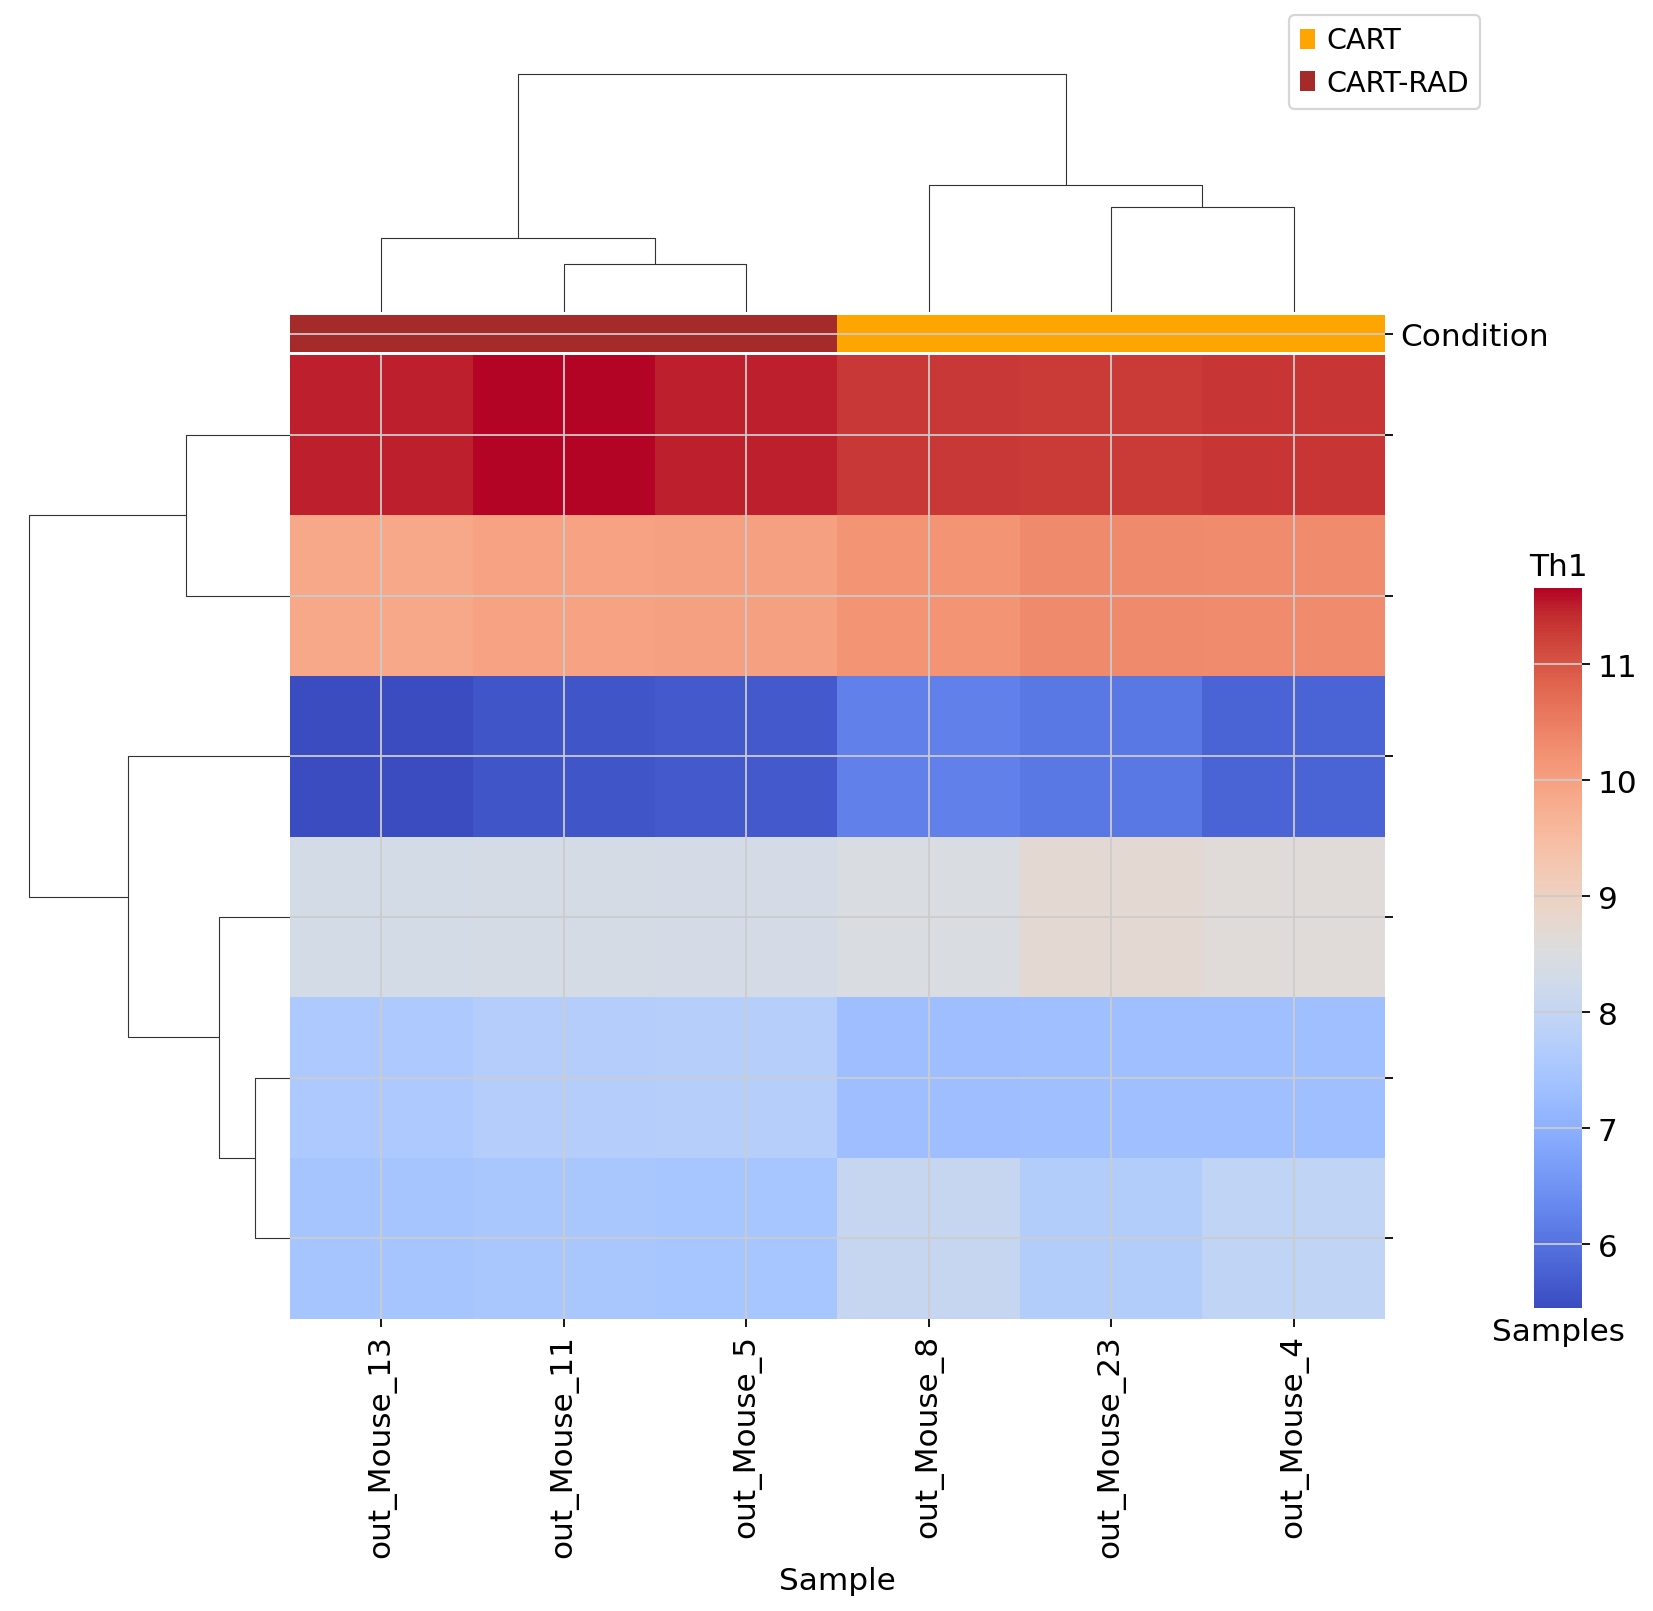

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.72 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 2.08 seconds.

Fitting LFCs...
... done in 1.20 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.04 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik     8.931867       -0.026033  0.465683 -0.055903  0.955419   
0610010F05Rik    14.044435       -0.428931  0.313265 -1.369230  0.170927   
0610010K14Rik   112.461067       -0.386805  0.178012 -2.172914  0.029787   
0610012G03Rik    87.570679       -0.061906  0.183507 -0.337351  0.735852   
0610030E20Rik    41.917572       -0.159912  0.292487 -0.546732  0.584563   
...                    ...             ...       ...       ...       ...   
mt-Nd3          540.154236       -0.431459  0.323672 -1.333013  0.182527   
mt-Nd4         3778.856201       -0.039437  0.083178 -0.474125  0.635411   
mt-Nd4l         371.152832       -0.509086  0.223092 -2.281953  0.022492   
mt-Nd5         1301.746948       -0.129277  0.091782 -1.408521  0.158977   
mt-Nd6          165.990372        0.482319  0.296784  1.625154  0.104130   

                   pad

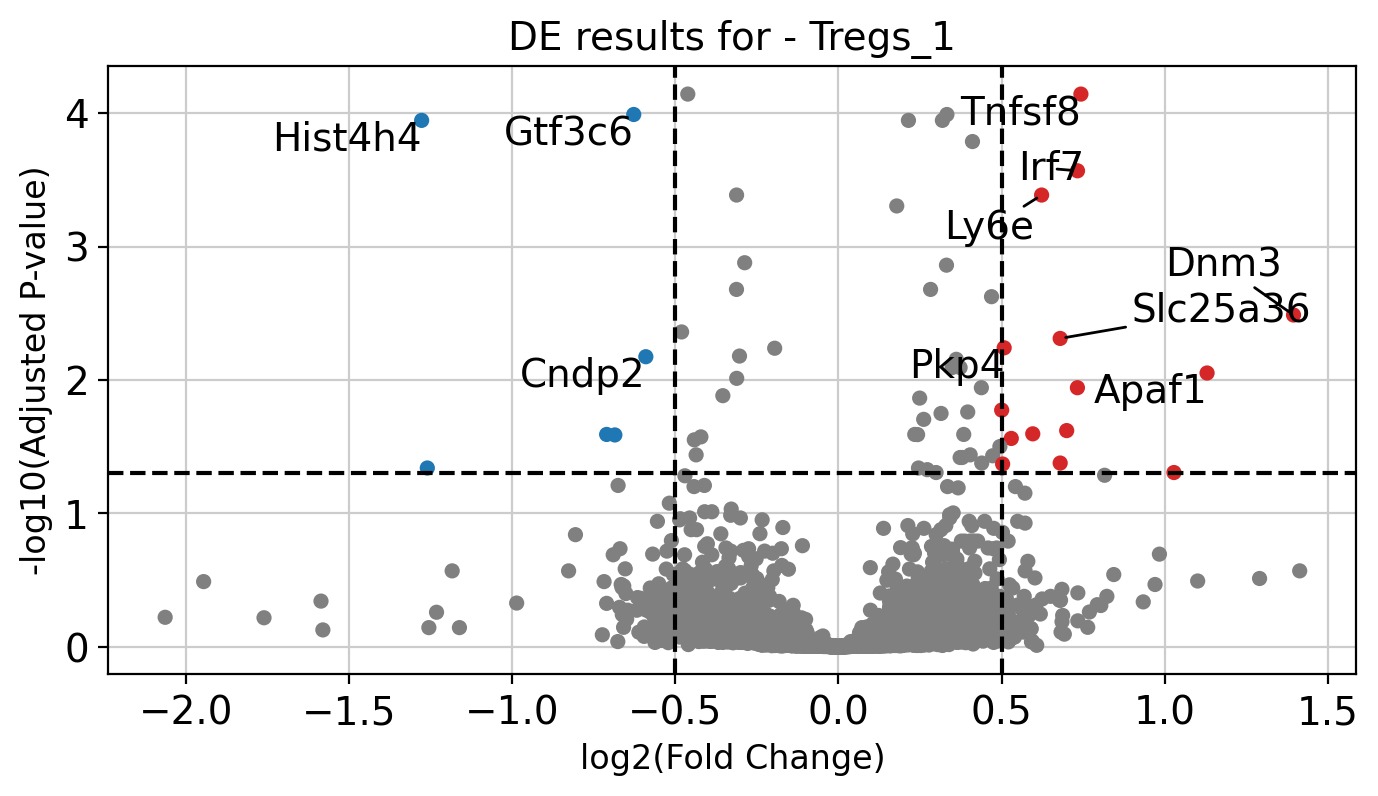

Fitting dispersions...
... done in 1.78 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.



<Figure size 960x640 with 0 Axes>

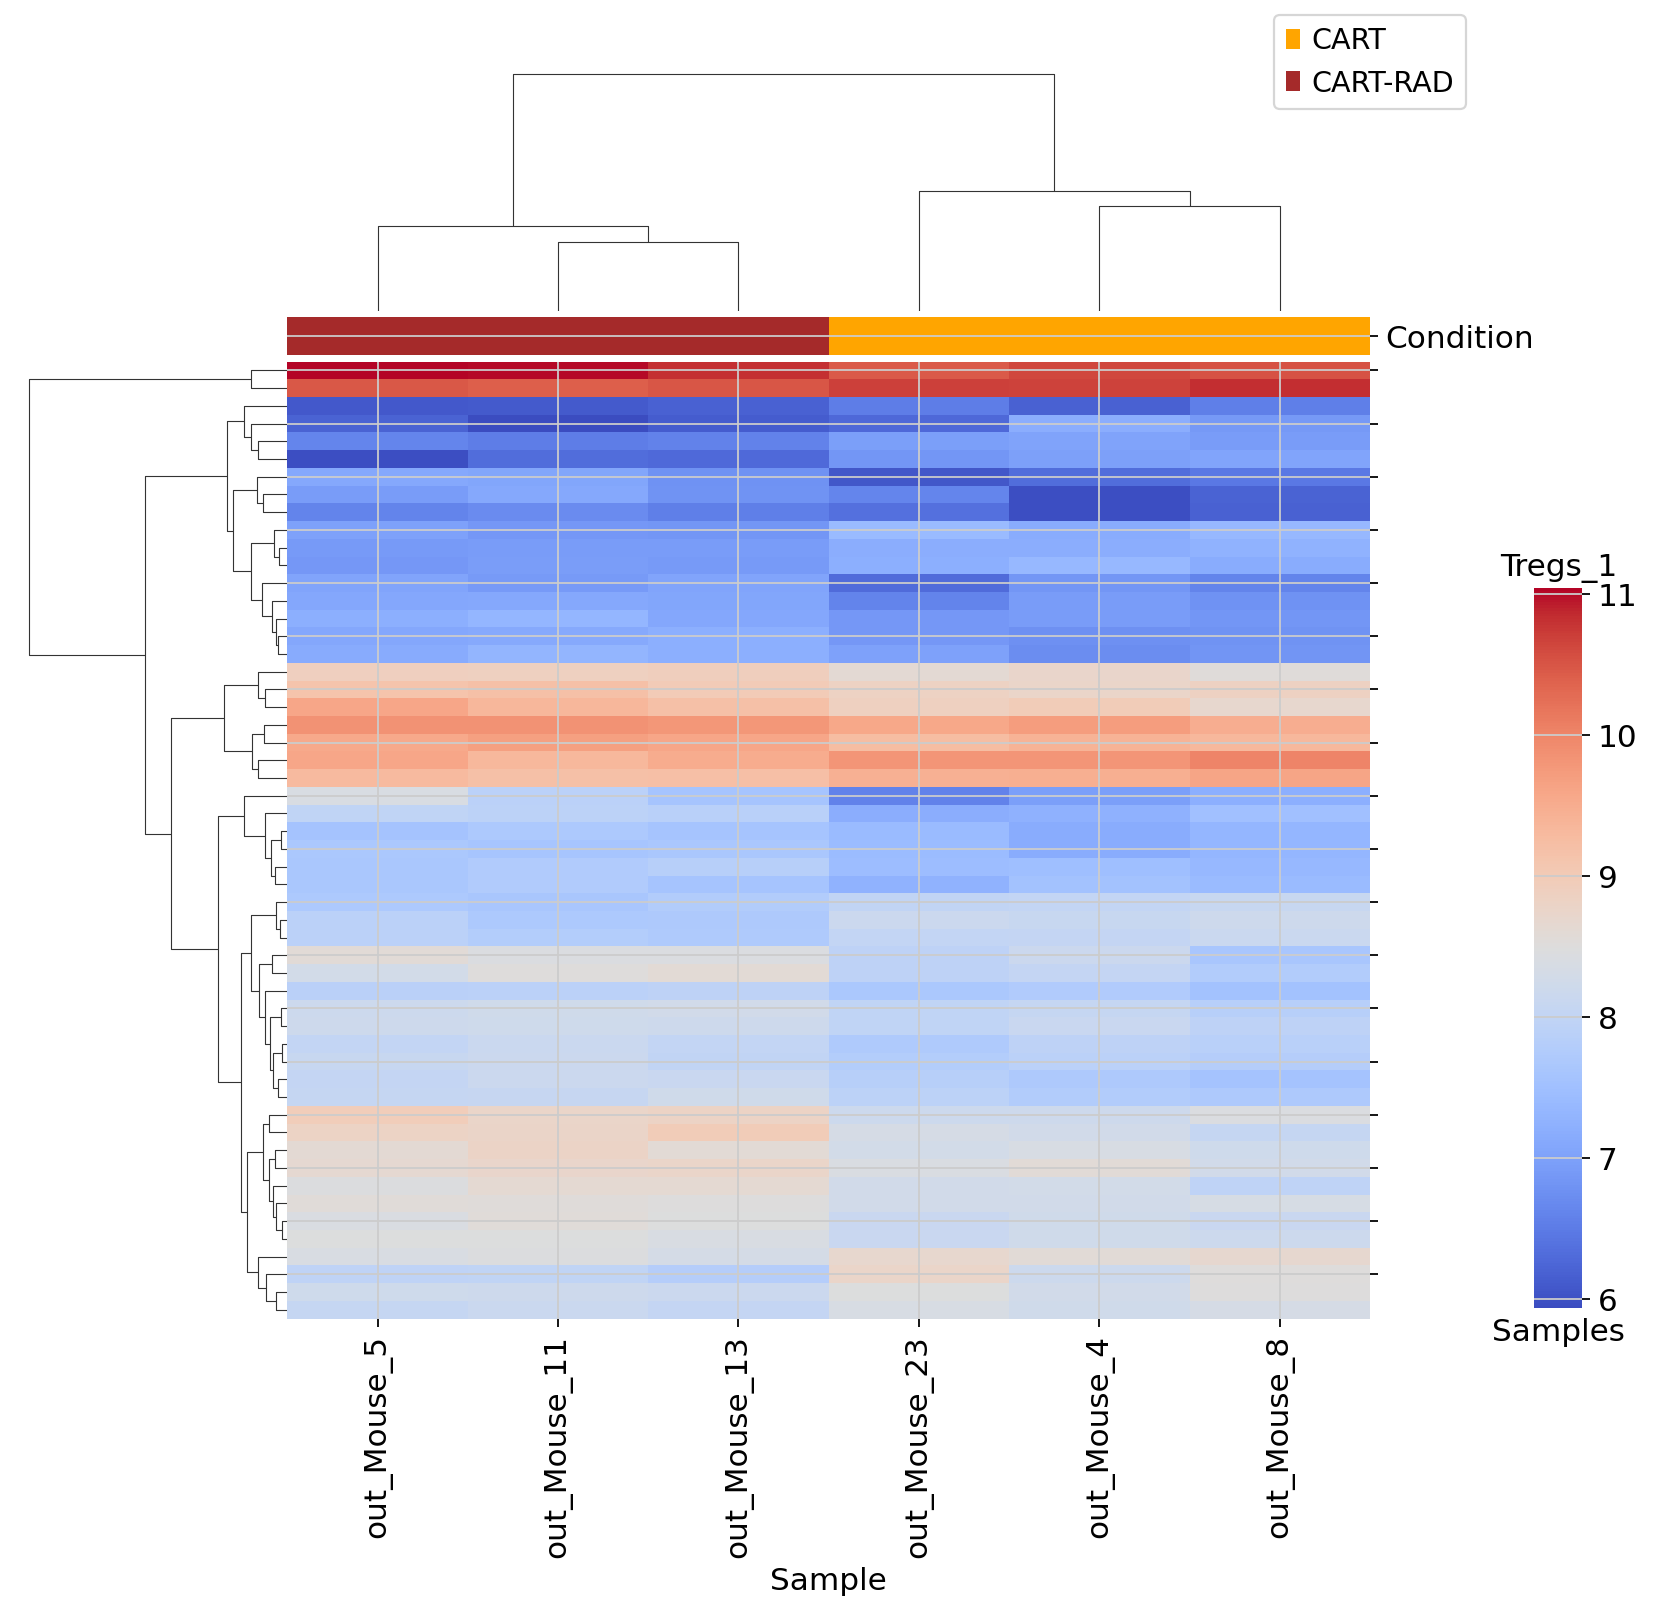

/home/maa7095/miniconda3/envs/deseq_python/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.02 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 1.76 seconds.

Fitting LFCs...
... done in 1.21 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.



Log2 fold change & Wald test p-value: Condition CART-RAD vs CART
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    19.290625        0.315684  0.264129  1.195192  0.232012   
0610010F05Rik    18.241137        0.224593  0.263492  0.852373  0.394007   
0610010K14Rik   121.011810       -0.075127  0.103014 -0.729296  0.465821   
0610012G03Rik    93.872490        0.332733  0.128065  2.598164  0.009372   
0610030E20Rik    46.696533        0.020907  0.247577  0.084445  0.932703   
...                    ...             ...       ...       ...       ...   
mt-Nd3          601.882874       -0.341493  0.298943 -1.142335  0.253315   
mt-Nd4         3976.806641        0.066336  0.127963  0.518405  0.604176   
mt-Nd4l         361.049164       -0.105488  0.239536 -0.440384  0.659659   
mt-Nd5         1258.580078        0.164905  0.144029  1.144947  0.252231   
mt-Nd6          208.913620        0.400989  0.249271  1.608647  0.107694   

                   pad

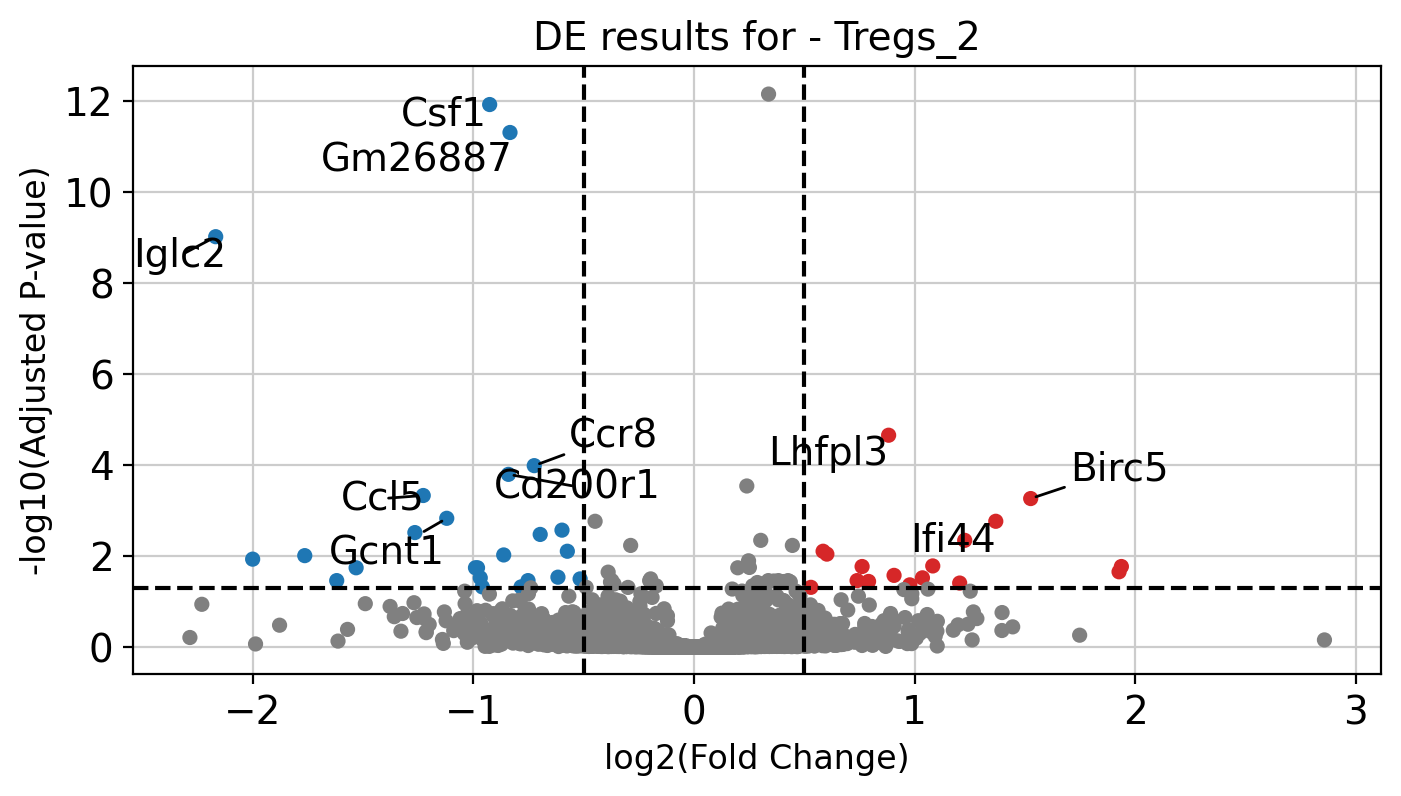

Fitting dispersions...
... done in 1.86 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.



<Figure size 960x640 with 0 Axes>

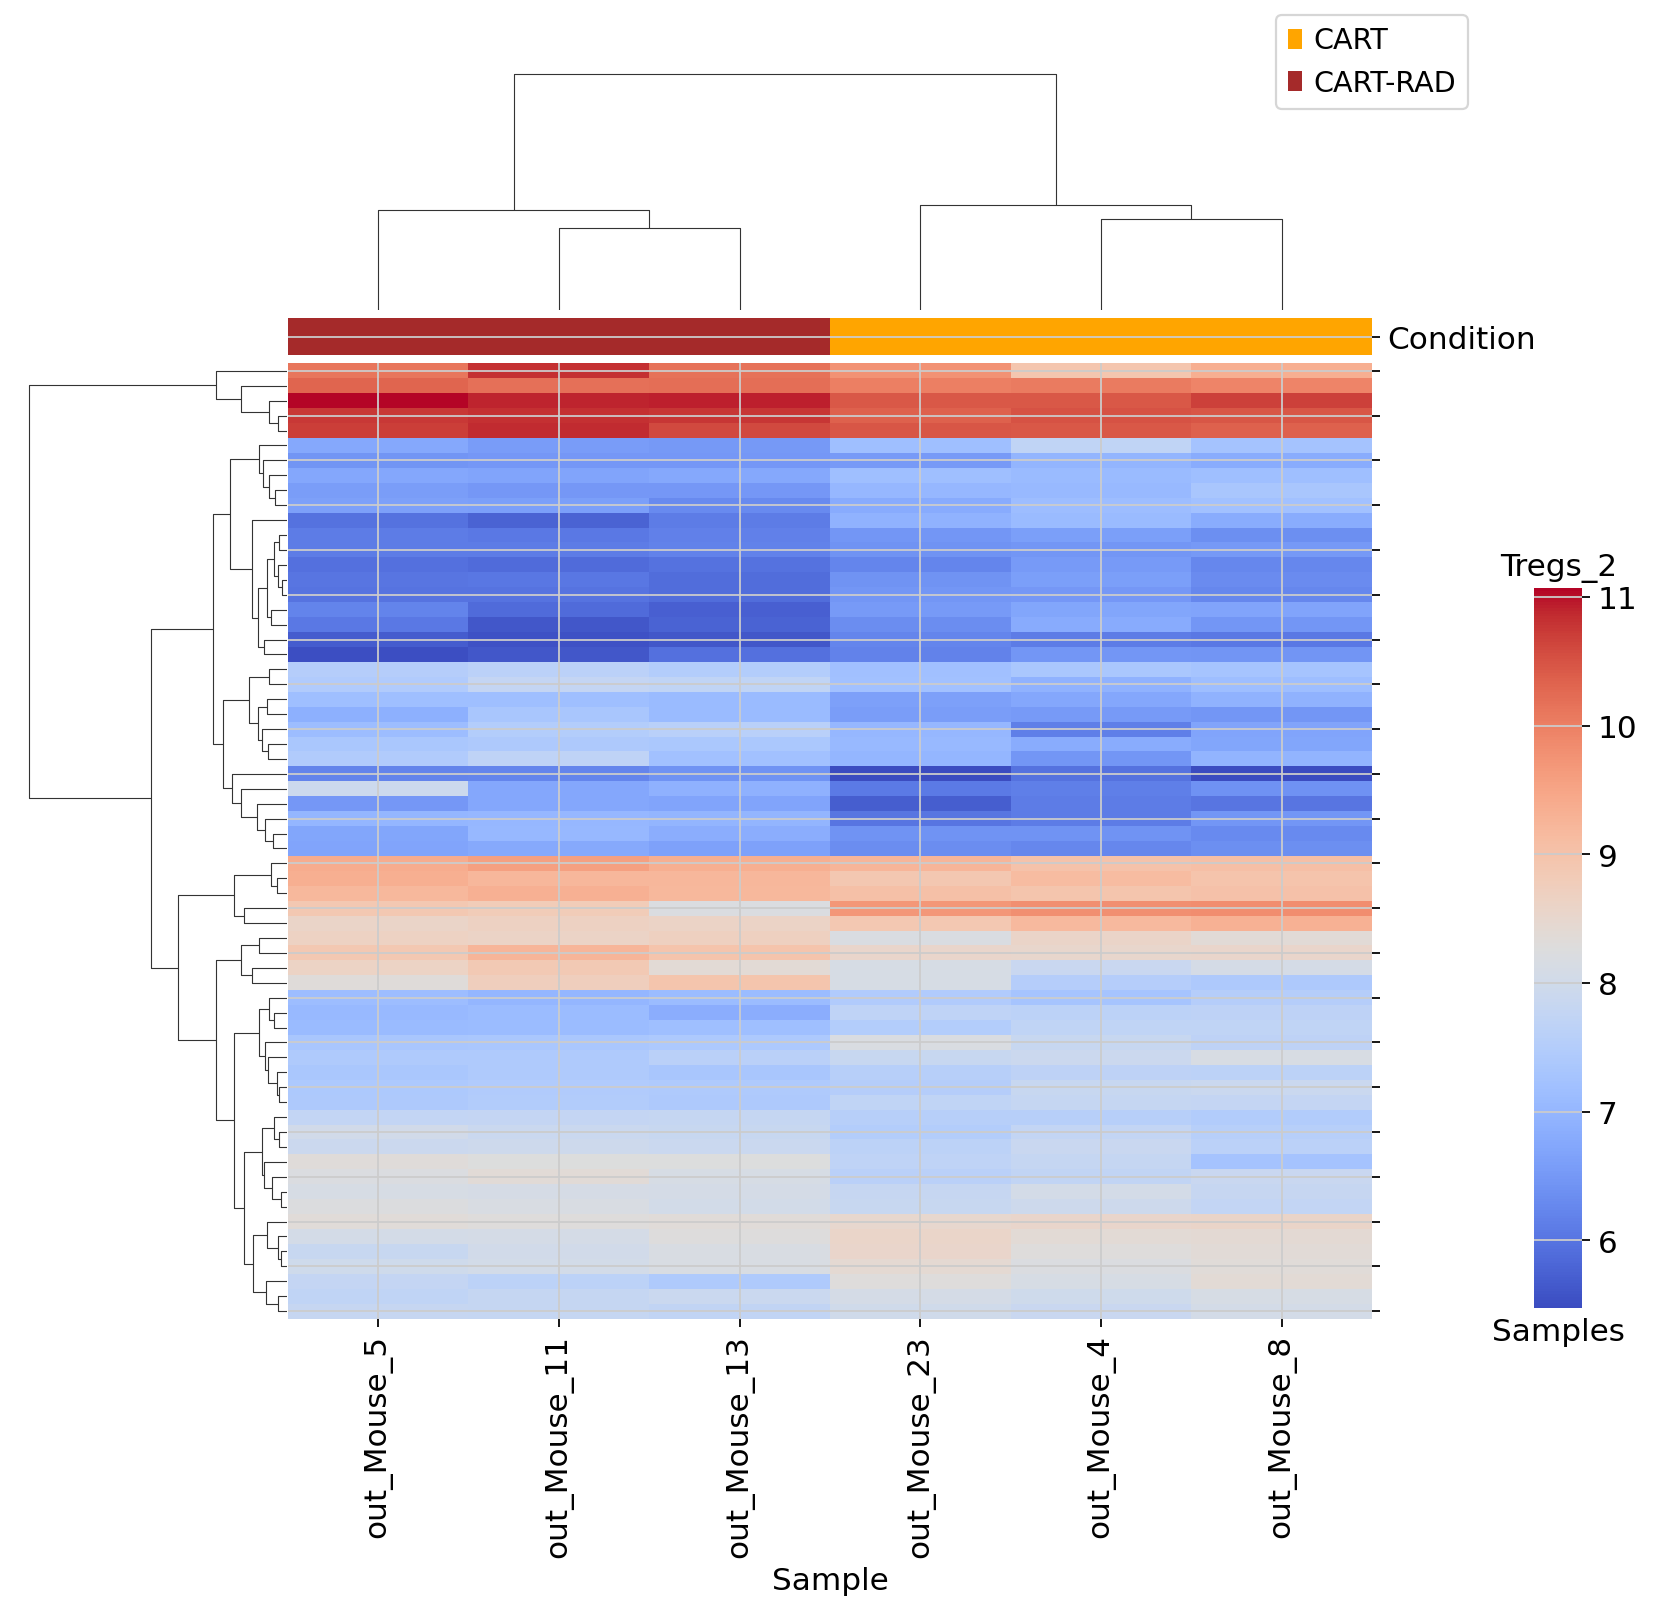

In [37]:
de_dataframe = {}
for cell_type in pdata.obs['T_cell_type_fine'].unique():
    #subset object
    tcells = pdata[pdata.obs['T_cell_type_fine'] == cell_type].copy()
    genes = dc.filter_by_expr(tcells, group='Condition', min_count=10, min_total_count=15)

    # Filter by these genes
    tcells = tcells[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        adata=tcells,
        design_factors='Condition',
        ref_level=['Condition', 'CART'],
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between CART-RAD vs CART
    stat_res = DeseqStats(
        dds,
        alpha=0.05,
        contrast=["Condition", 'CART-RAD', 'CART'],
        inference=inference, independent_filter=True
    )
    # Compute Wald test
    stat_res.summary()
    # Extract results
    results_df = stat_res.results_df
    results_df = results_df.sort_values(by='pvalue')

    #save results
    file_name="pseudobulk_DE/pseudo_DE_analysis_CARTRAD_vs_CART_" + cell_type + ".csv"
    
    results_df.to_csv(file_name, index=True)

    #print results
    print("Number of observations with padjusted < 0.05 and log2FoldChange positive for " + cell_type + " is: ", sum((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] > 0)))
    print("Number of observations with padjusted < 0.05 and log2FoldChange negative for " + cell_type + " is: ", sum((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] < 0)))

    print("Number of observations with padjusted < 0.05 and log2FoldChange > 0.25 for " + cell_type + " is: ", sum((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] > 0.25)))
    print("Number of observations with padjusted < 0.05 and log2FoldChange < -0.25 for " + cell_type + " is: ", sum((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] < -0.25)))


    print("Number of observations with p < 0.01 and log2FoldChange positive for " + cell_type + " is: ", sum((results_df['pvalue'] < 0.01) & (results_df['log2FoldChange'] > 0)))
    print("Number of observations with p < 0.01 and log2FoldChange negative for " + cell_type + " is: ", sum((results_df['pvalue'] < 0.01) & (results_df['log2FoldChange'] < 0)))
   
    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=10,
        figsize=(8, 4),
        sign_thr=0.05,  # Significance threshold for nominal p adjusted values
        lFCs_thr=0.50   # Log fold-change threshold
    )

    # Add a title to the plot
    plt.title(f'DE results for - {cell_type}')

    # Change the y-axis label
    plt.ylabel('-log10(Adjusted P-value)', fontsize=12)

    # Optionally change the x-axis label (if needed)
    plt.xlabel('log2(Fold Change)', fontsize=12)

    # Save the plot as a PDF
    plt.savefig(f'pseudobulk_DE/{cell_type}_volcano_plot.pdf', format='pdf', bbox_inches='tight')

    # Display the plot (optional)
    plt.show()

    de_dataframe[cell_type]=results_df
    
    #subset top DE genes and plot them in heatmap
    sub_res_de = results_df[(results_df['padj'] < 0.05) & ((results_df['log2FoldChange'] > 0.25) | (results_df['log2FoldChange'] < -0.25))]
    gene_list=sub_res_de.index
    DeseqDataSet.vst(dds, use_design=False, fit_type='parametric') 

    # Extract data for the selected genes and convert to a dense array
    selected_genes_data = dds[:, gene_list].layers['vst_counts'].toarray()
    # Convert data to DataFrame
    selected_genes_df = pd.DataFrame(selected_genes_data, index=dds.obs_names , columns=gene_list)
    selected_genes_df['Sample']=dds.obs['Sample']
    new_df = selected_genes_df.melt(id_vars=['Sample'], var_name='Gene', value_name='Value')
    new_df= pd.merge(dds.obs[['Sample','Condition']],new_df,on='Sample' )
    new_df = new_df.sort_values(by='Condition')

    glue = new_df.pivot(index="Gene", columns="Sample", values="Value")
    glue = glue[new_df['Sample'].unique()]
    # Prepare a vector of color mapped to the 'cyl' column
     # Get the unique sample names and their corresponding conditions
    sample_conditions = new_df[['Sample', 'Condition']].drop_duplicates().set_index('Sample')['Condition']

    # Prepare a vector of color mapped to the 'Condition' column
    my_palette = {'CART': 'orange', 'CART-RAD': 'brown'}
    col_colors = sample_conditions.map(my_palette)
    # Get the sorted order of 'Sample' column
    plt.figure(figsize=(12, 8))
    g=sns.clustermap(glue, cmap='coolwarm', col_colors=col_colors)

    # Define a dictionary mapping colors to labels
    color_labels = {
        'orange': 'CART',
        'brown': 'CART-RAD'
    }

    # Loop over unique conditions
    for condition in col_colors.unique():
        color = col_colors[col_colors == condition].values[0]  # Get the color corresponding to the condition
        label = color_labels.get(color, 'Unknown')  # Get the label corresponding to the color from the dictionary
        g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)

        # Place the legend outside the plot
        g.ax_col_dendrogram.legend(loc='center', bbox_to_anchor=(1, 1), ncol=1)

        # Adjust the position of the main colorbar for the heatmap
        g.cax.set_position([.97, .2, .03, .45])

        ax = g.ax_heatmap
        ax.set_ylabel("")
        # Remove y-axis labels
        ax.set_yticklabels([])


    # Customize the plot
    plt.title(f'{cell_type}')
    plt.xlabel('Samples')
    plt.show()
    

In [38]:
pdata.obs["predicted_doublet"]= pdata.obs["predicted_doublet"].astype('category')

In [39]:
# save object t cell pseudocounts
#save_pdata = 't_cell_pseudocounts.h5ad'
#pdata.write(save_pdata)

In [40]:
#pseudocounts_data = 't_cell_pseudocounts.h5ad'
#pdata = ad.read_h5ad(pseudocounts_data)

In [41]:
from pypath.inputs import msigdb
import pandas as pd

msigdb_mouse_raw = msigdb.msigdb_download_collections(organism = 'mouse')

msigdb_mouse_raw_df = pd.DataFrame(
    [
        (collname, collcode, gset, gene)
        for (collname, collcode), coll in msigdb_mouse_raw.items()
        for gset, genes in coll.items()
        for gene in genes
    ],
    columns = ['collection', 'code', 'geneset', 'genesymbol']
)



In [42]:
# Remove duplicated entries
sub_msigdb_mouse_raw_df = msigdb_mouse_raw_df[~msigdb_mouse_raw_df.duplicated(['geneset', 'genesymbol'])]


In [43]:
hallmark_df = sub_msigdb_mouse_raw_df[sub_msigdb_mouse_raw_df['collection']=='hallmark']

In [44]:
hallmark_df

collection    code                           geneset genesymbol
0      hallmark  mh.all  HALLMARK_TNFA_SIGNALING_VIA_NFKB       Sat1
1      hallmark  mh.all  HALLMARK_TNFA_SIGNALING_VIA_NFKB    Gadd45b
2      hallmark  mh.all  HALLMARK_TNFA_SIGNALING_VIA_NFKB       Eif1
3      hallmark  mh.all  HALLMARK_TNFA_SIGNALING_VIA_NFKB       Bmp2
4      hallmark  mh.all  HALLMARK_TNFA_SIGNALING_VIA_NFKB      Dusp2
...         ...     ...                               ...        ...
7184   hallmark  mh.all      HALLMARK_PANCREAS_BETA_CELLS       Akt3
7185   hallmark  mh.all      HALLMARK_PANCREAS_BETA_CELLS       Dpp4
7186   hallmark  mh.all      HALLMARK_PANCREAS_BETA_CELLS       Scgn
7187   hallmark  mh.all      HALLMARK_PANCREAS_BETA_CELLS       Ins2
7188   hallmark  mh.all      HALLMARK_PANCREAS_BETA_CELLS        Sst

[7189 rows x 4 columns]

In [45]:
#we want to add custom pathways.
#custom_pathways= pd.read_csv('../t_cell_analysis/pseudobulk_DE/custom_pathways_MF.csv')
#hallmark_df_custom= pd.concat([hallmark_df,custom_pathways], axis=0)

To run GSEA analysis we use the obtained gene level statistics. Any statistic can be used, but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value. We will transform the obtained t-values stored in stats to a wide matrix so that it can be used by decoupler.

Gene Set Enrichment Analysis (GSEA).

GSEA (Aravind et al., 2005) starts by transforming the input molecular readouts in mat to ranks for each sample. Then, an enrichment score gsea_estimate is calculated by walking down the list of features, increasing a running-sum statistic when a feature in the target feature set is encountered and decreasing it when it is not. The final score is the maximum deviation from zero encountered in the random walk. Finally, a normalized score gsea_norm, can be obtained by computing the z-score of the estimate compared to a null distribution obtained from N random permutations.

Aravind S. et al. (2005) Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. PNAS. 102, 43.

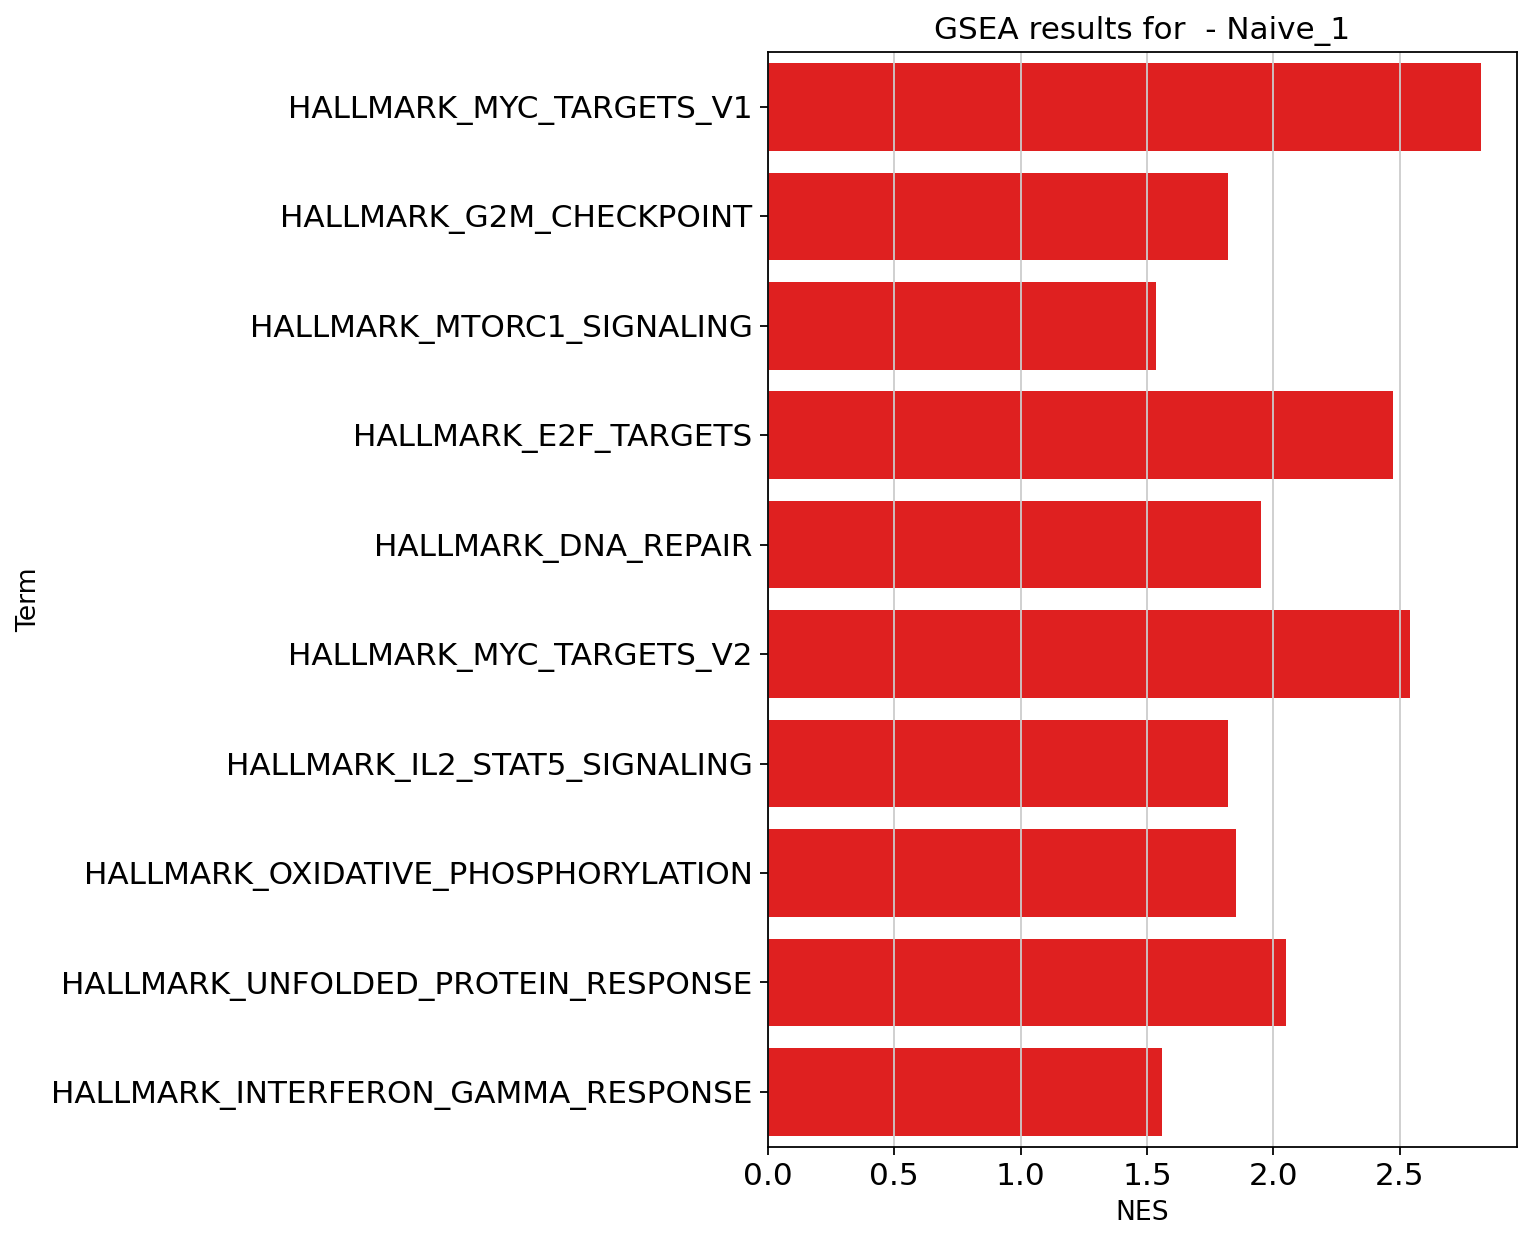

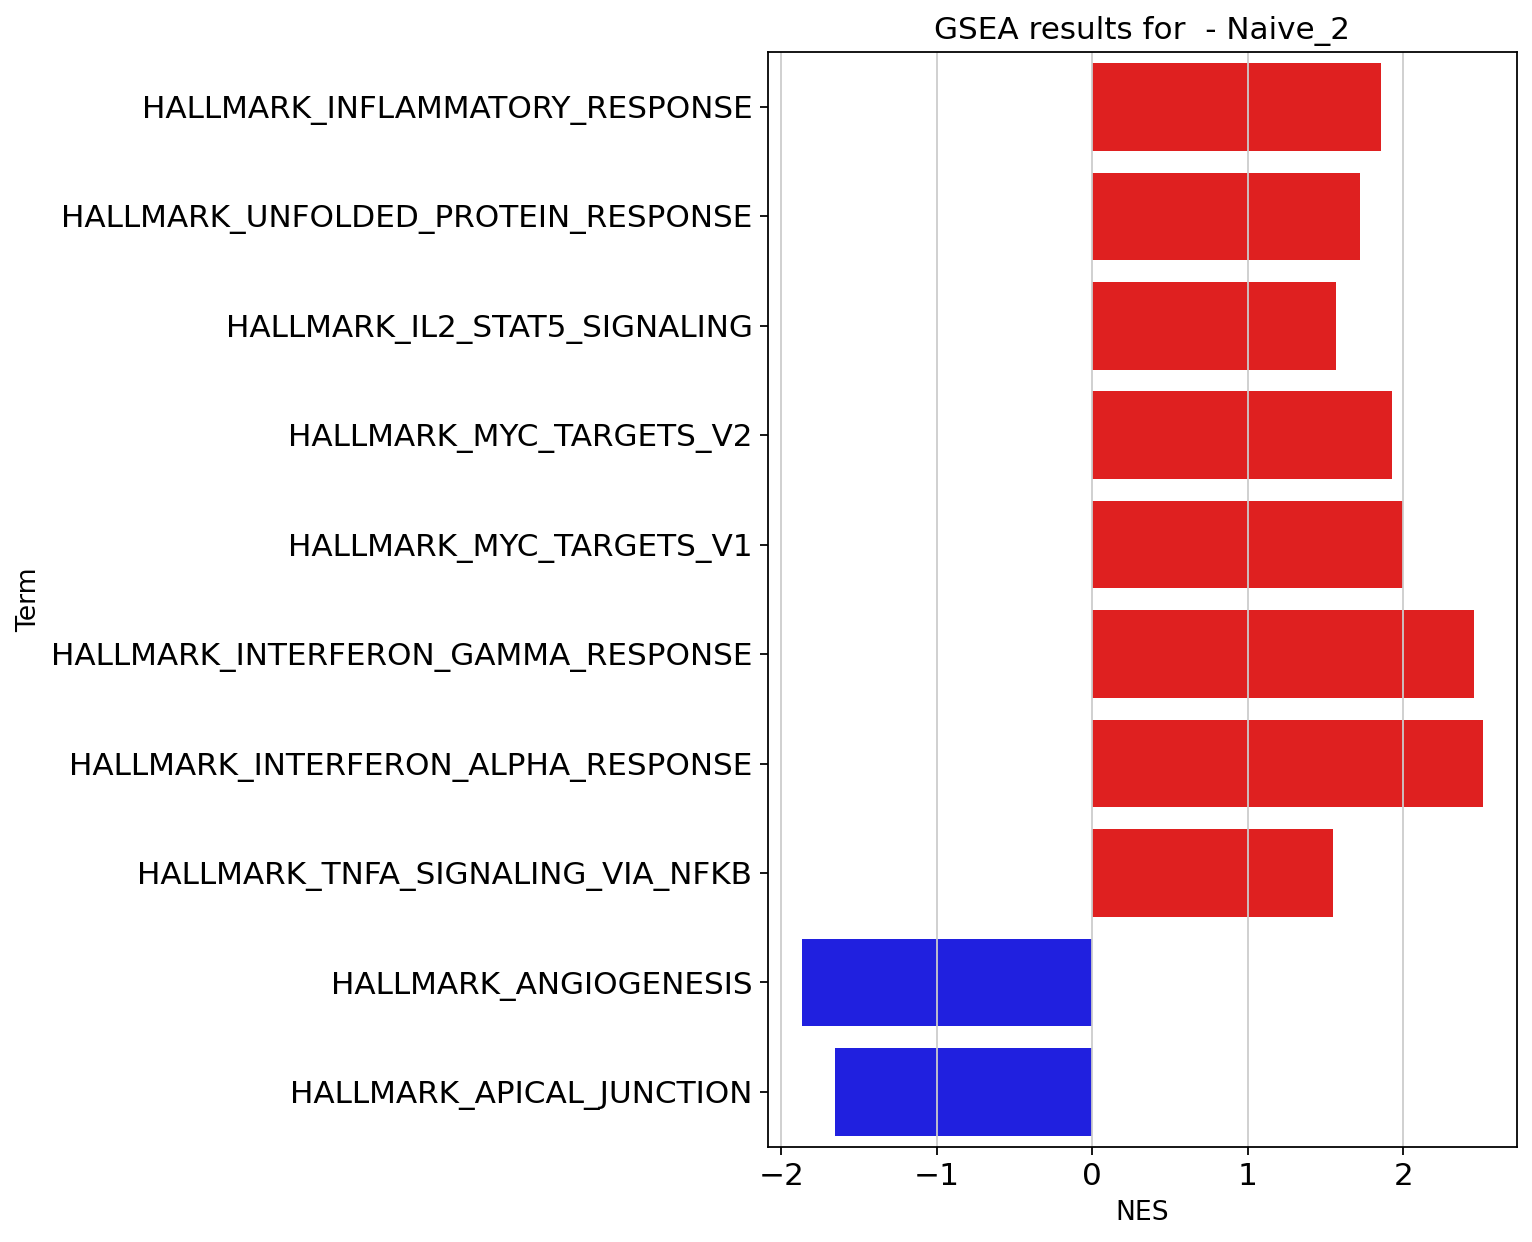

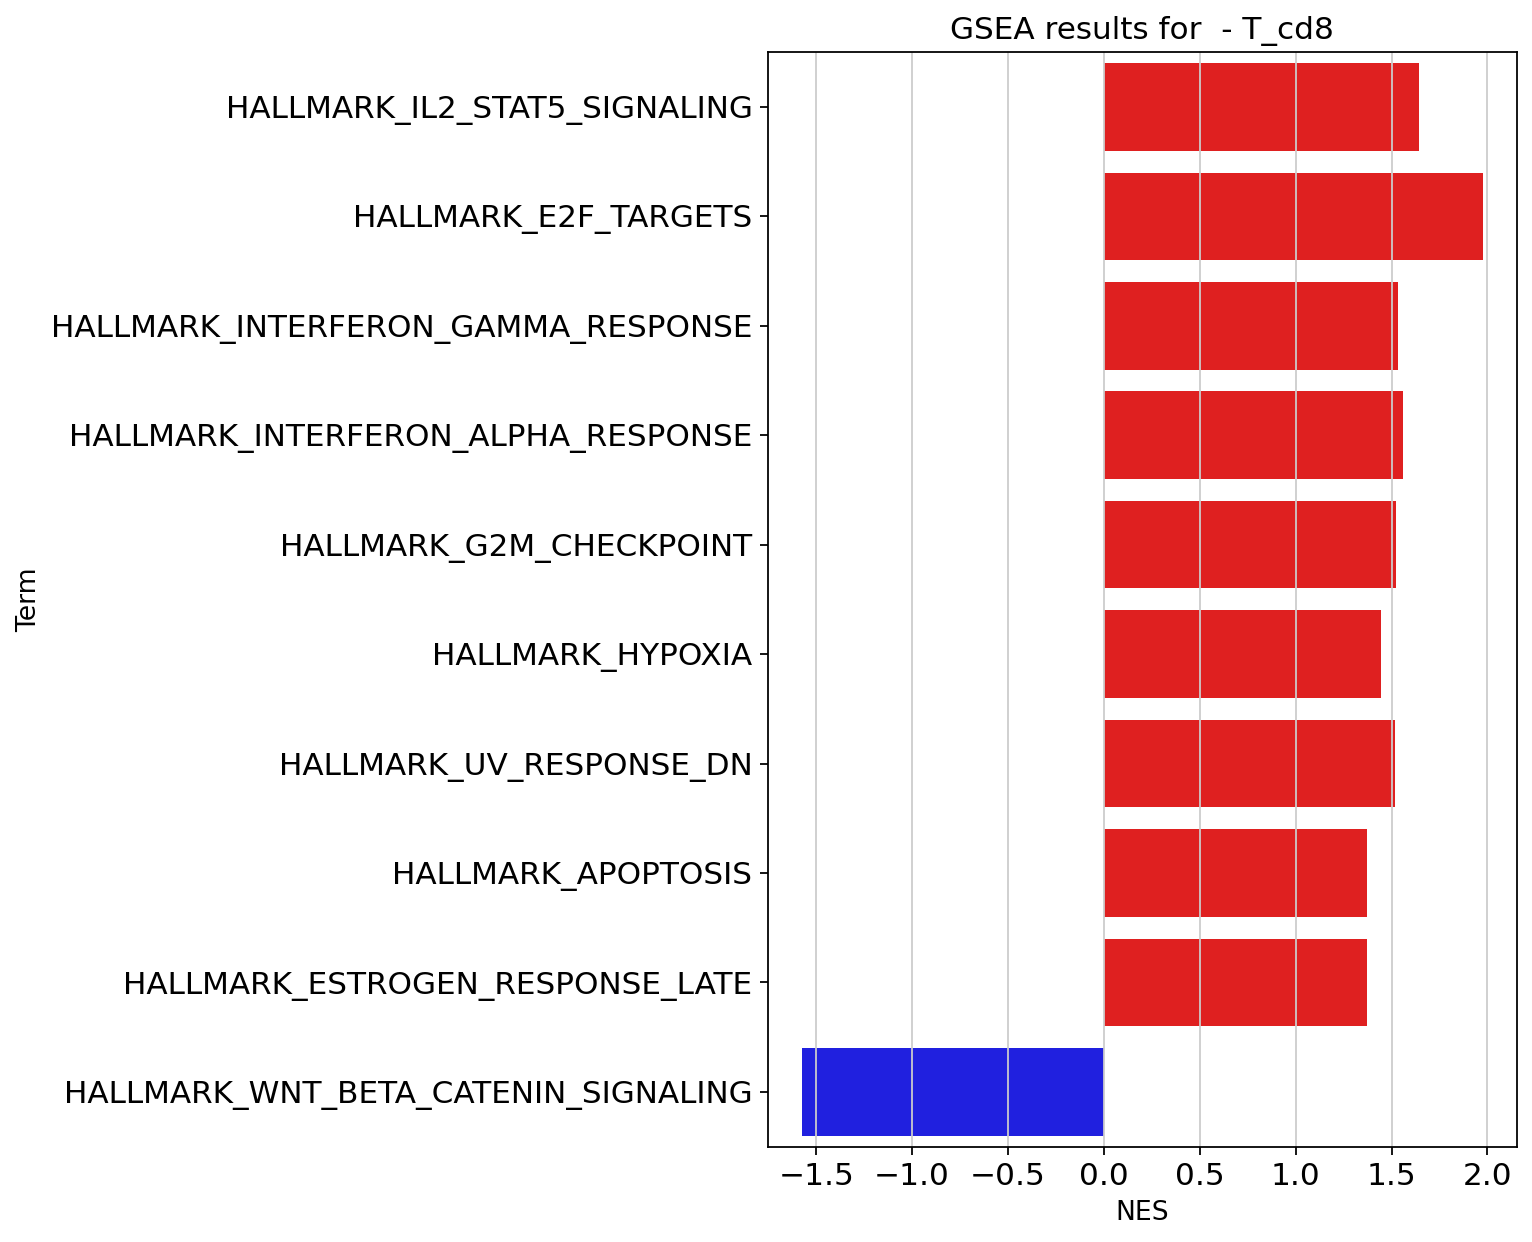

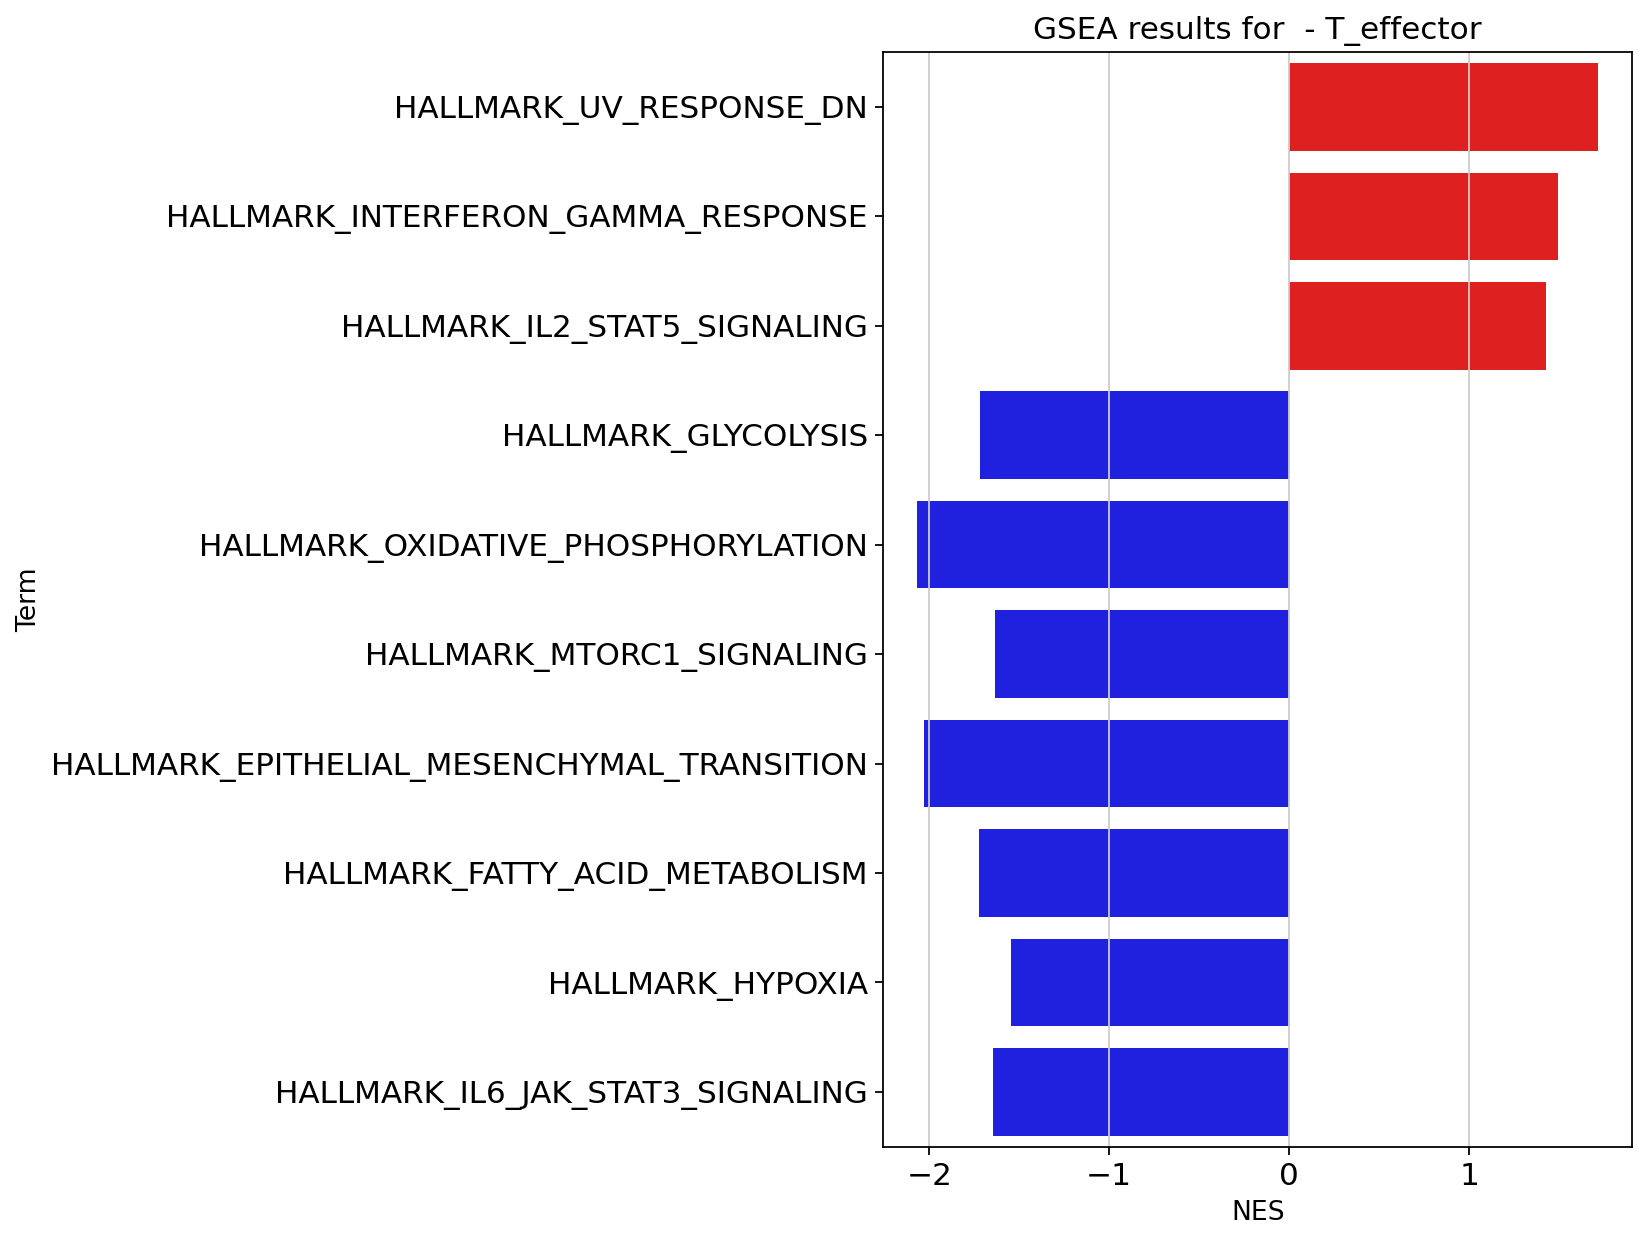

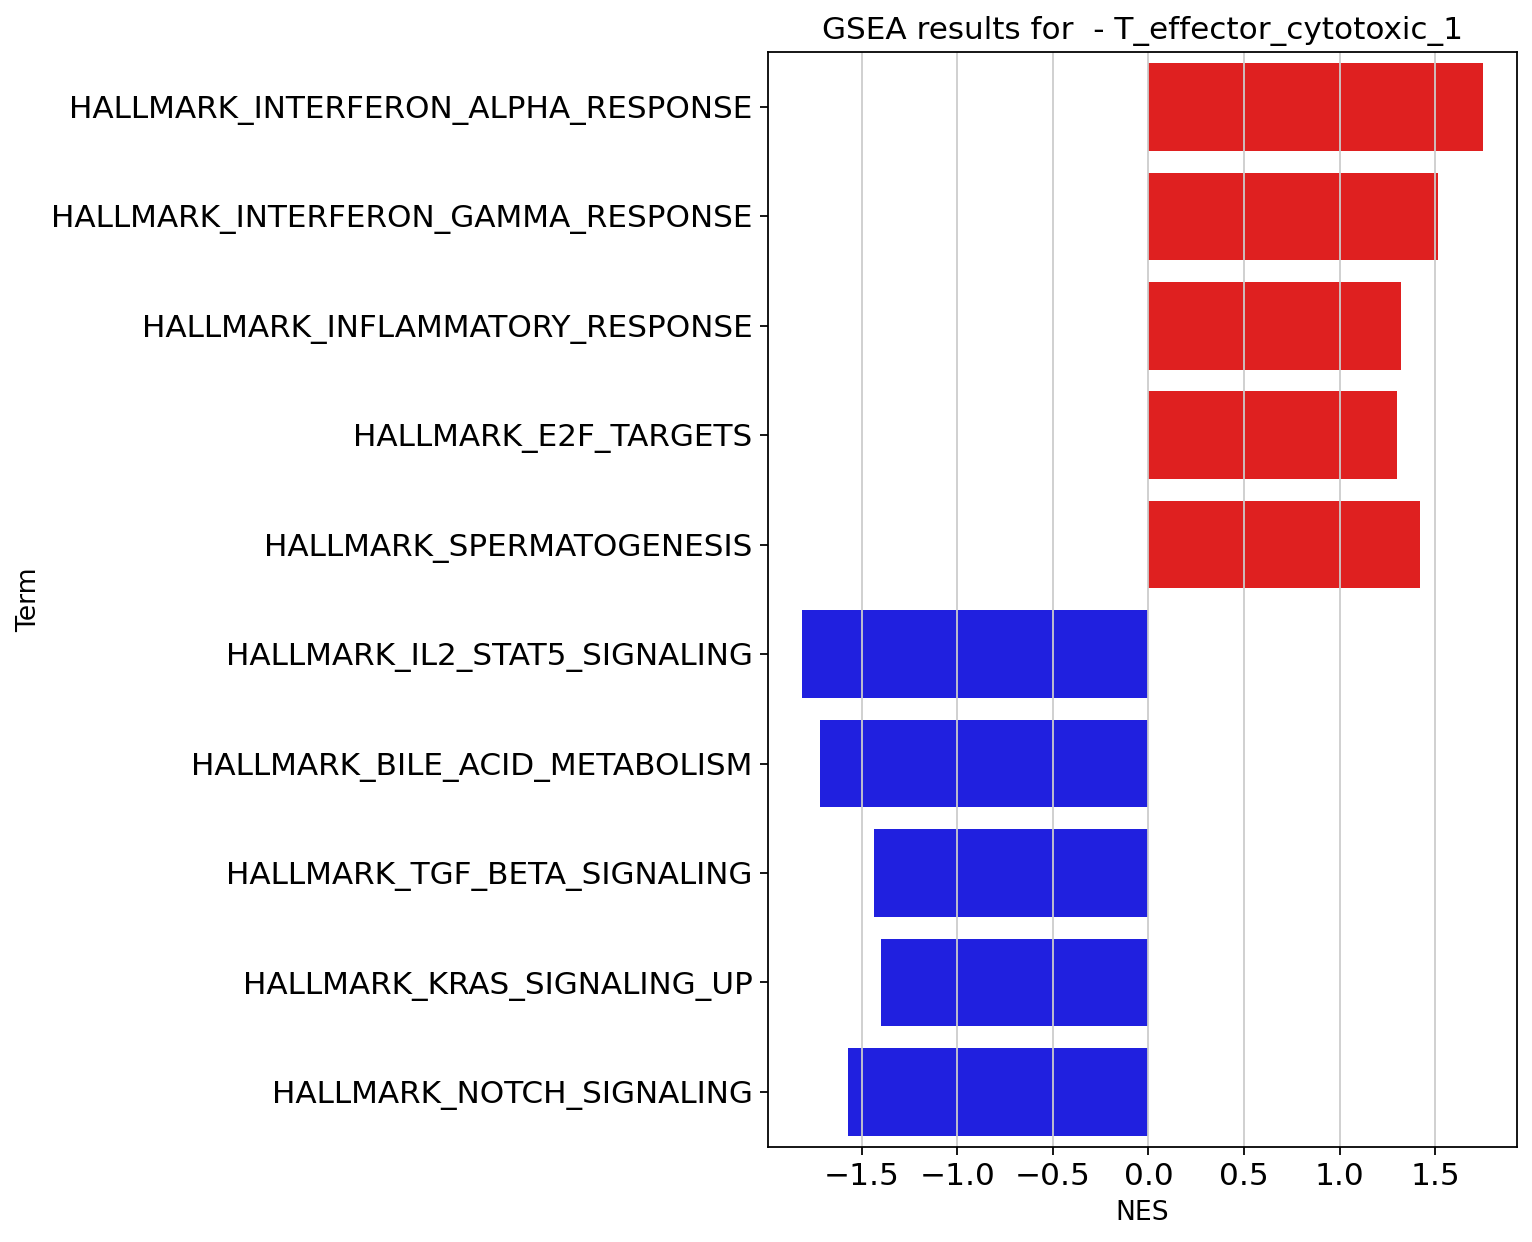

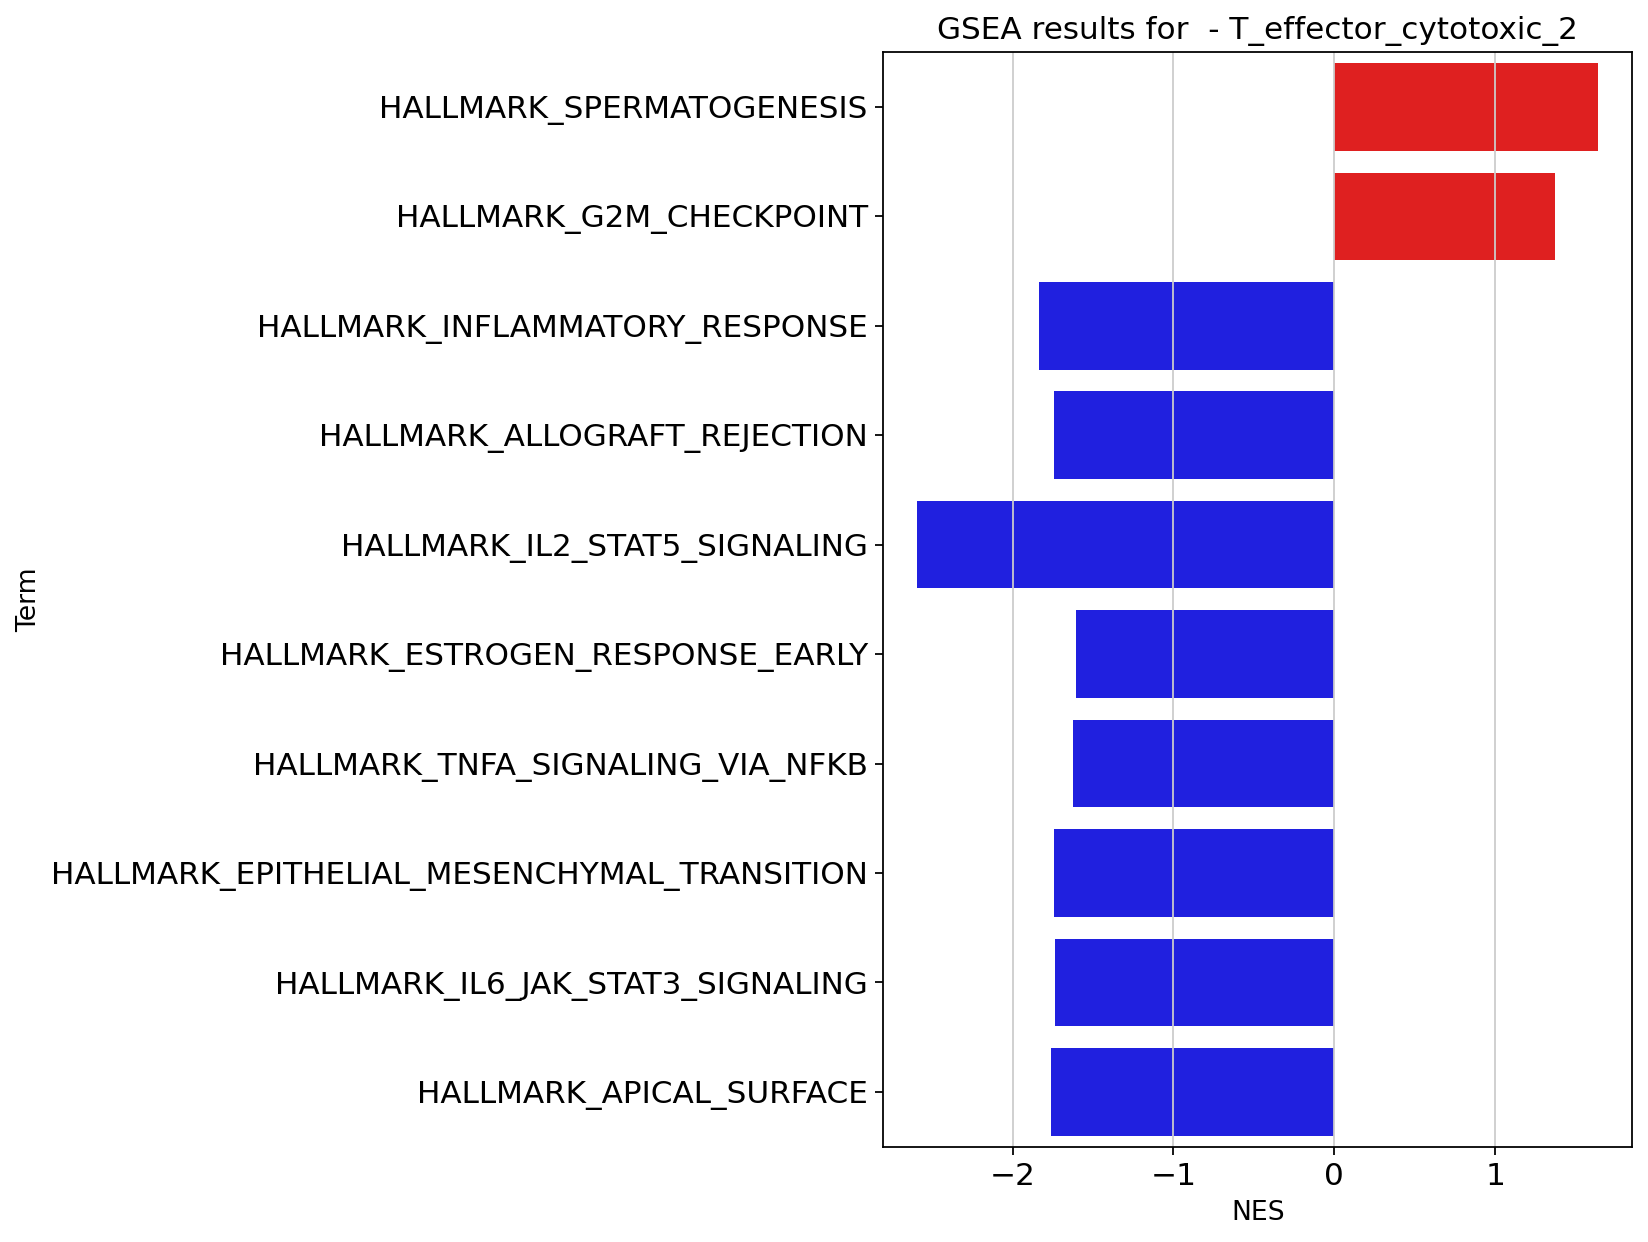

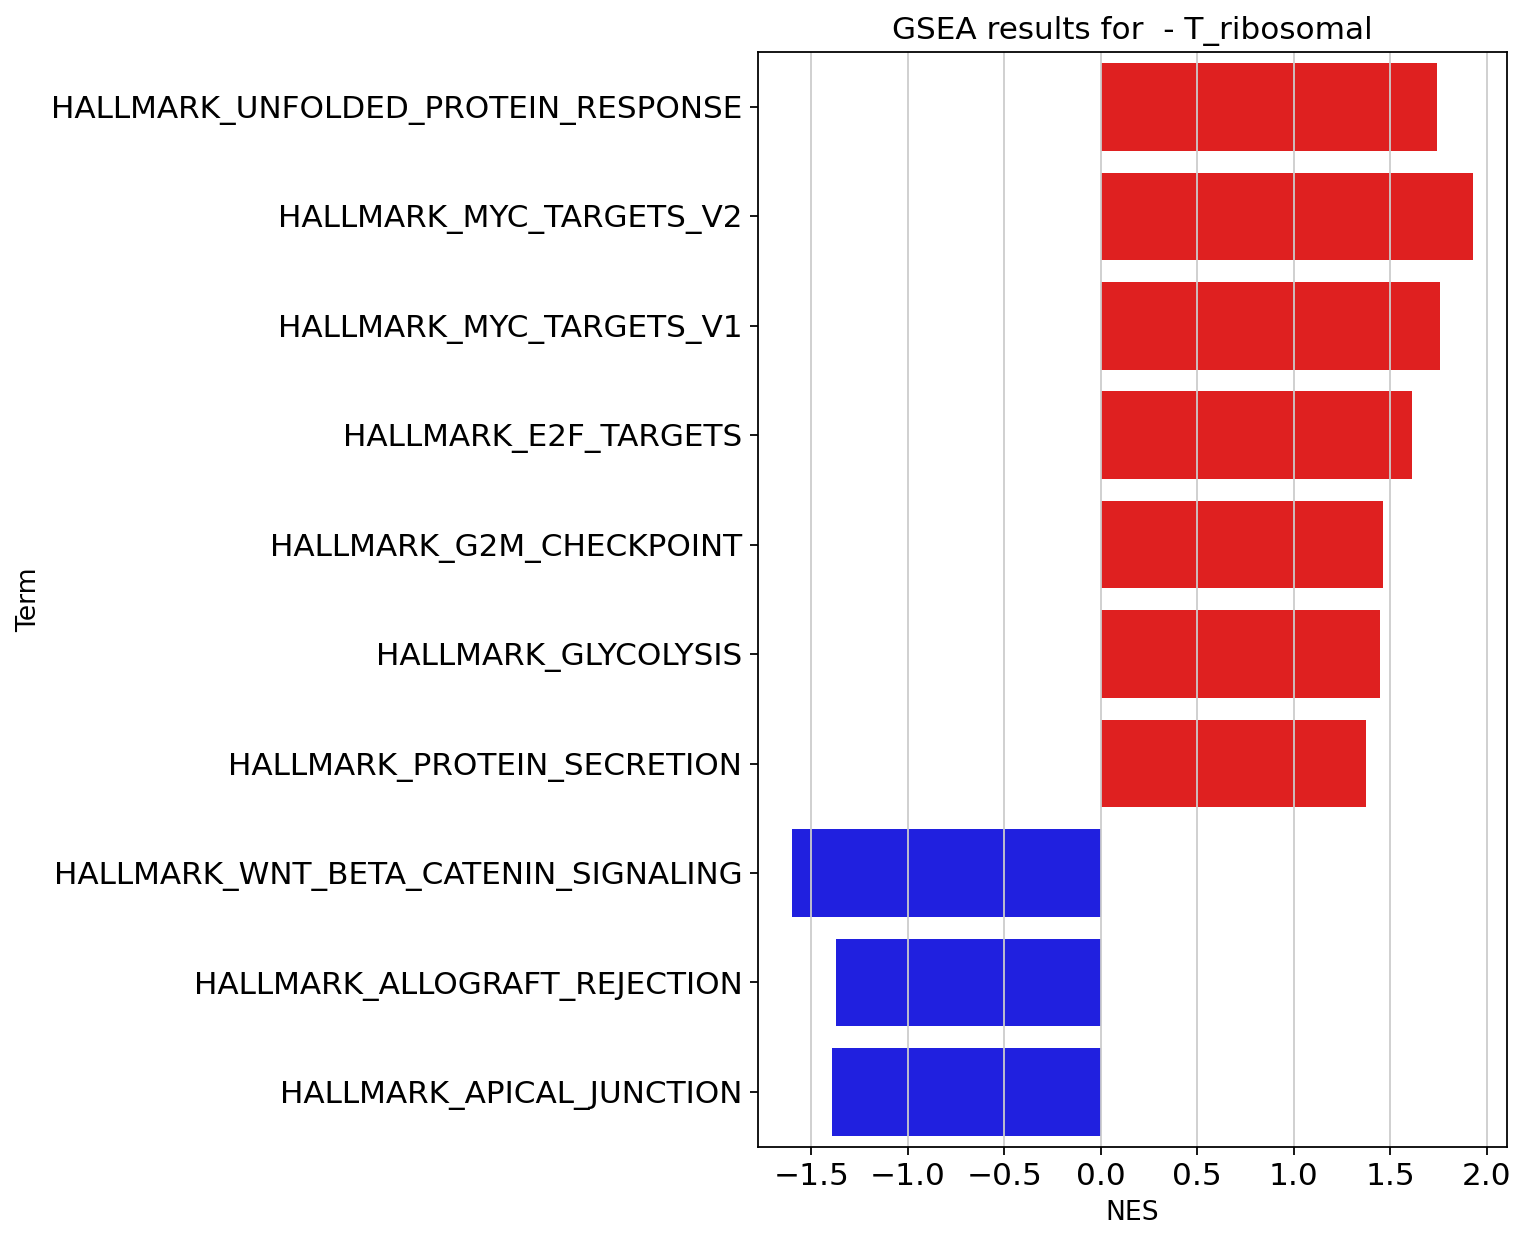

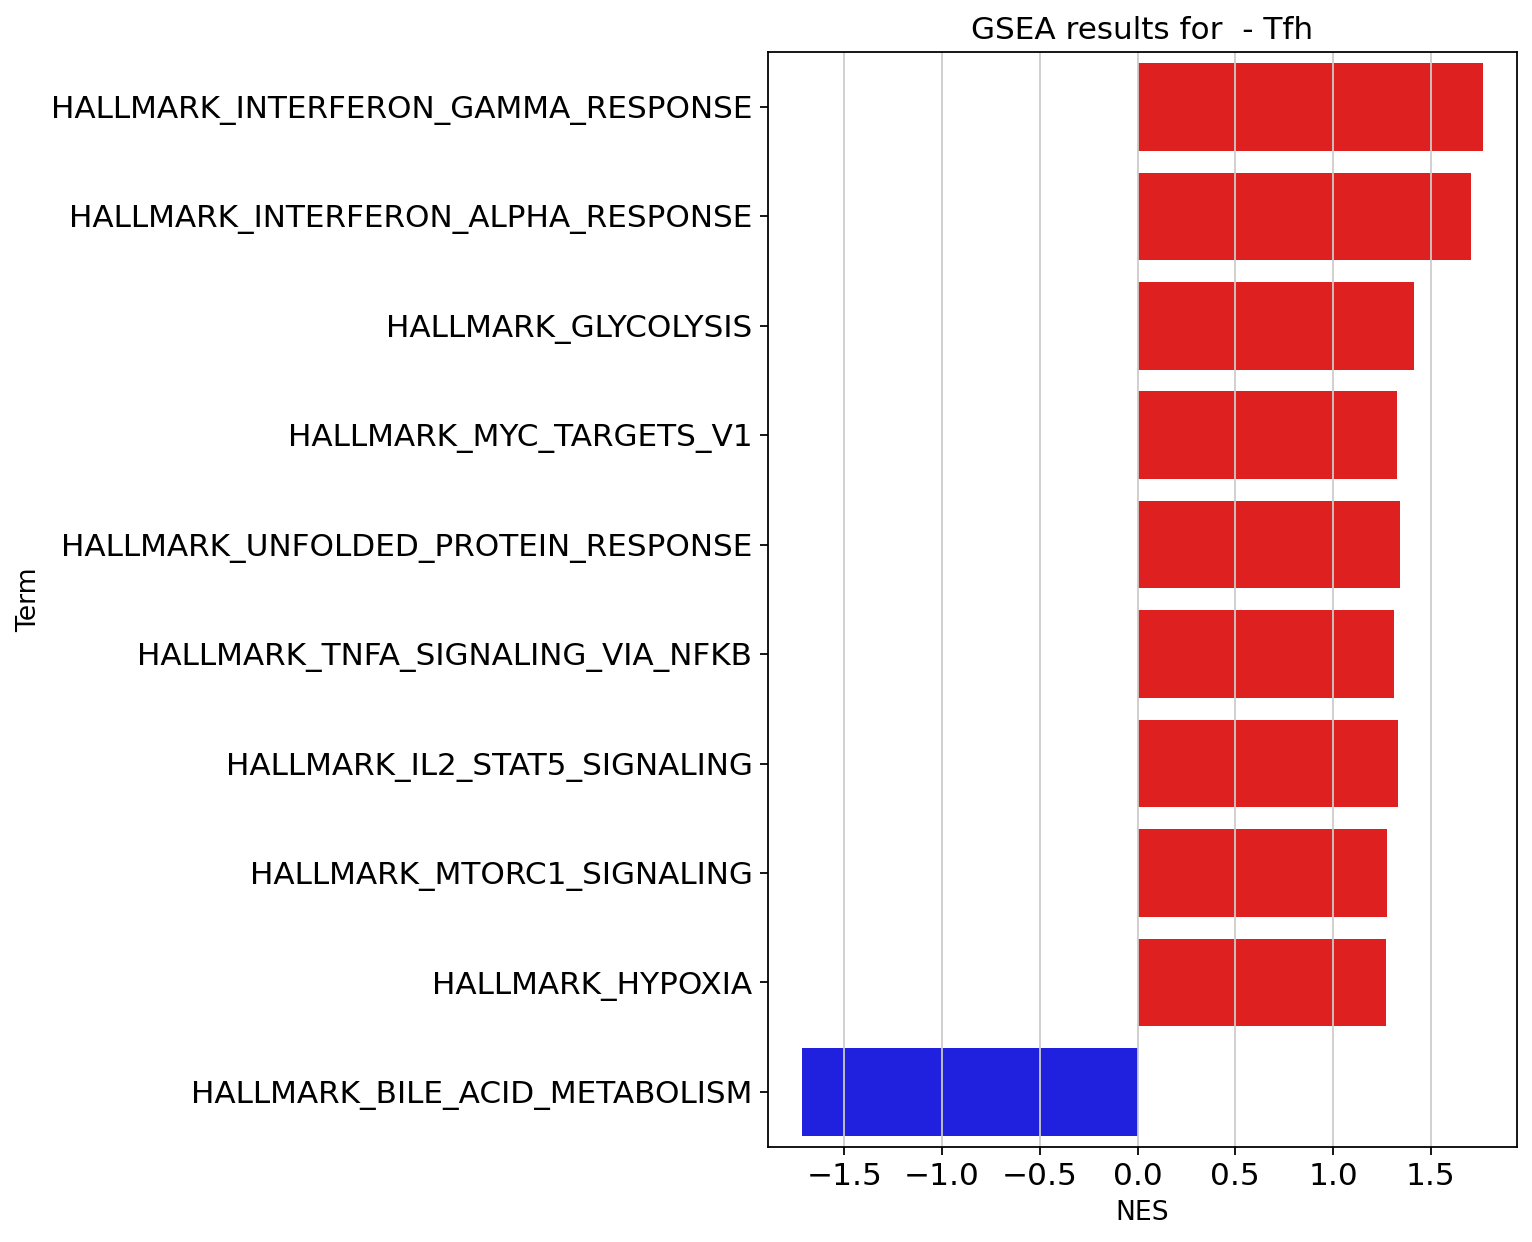

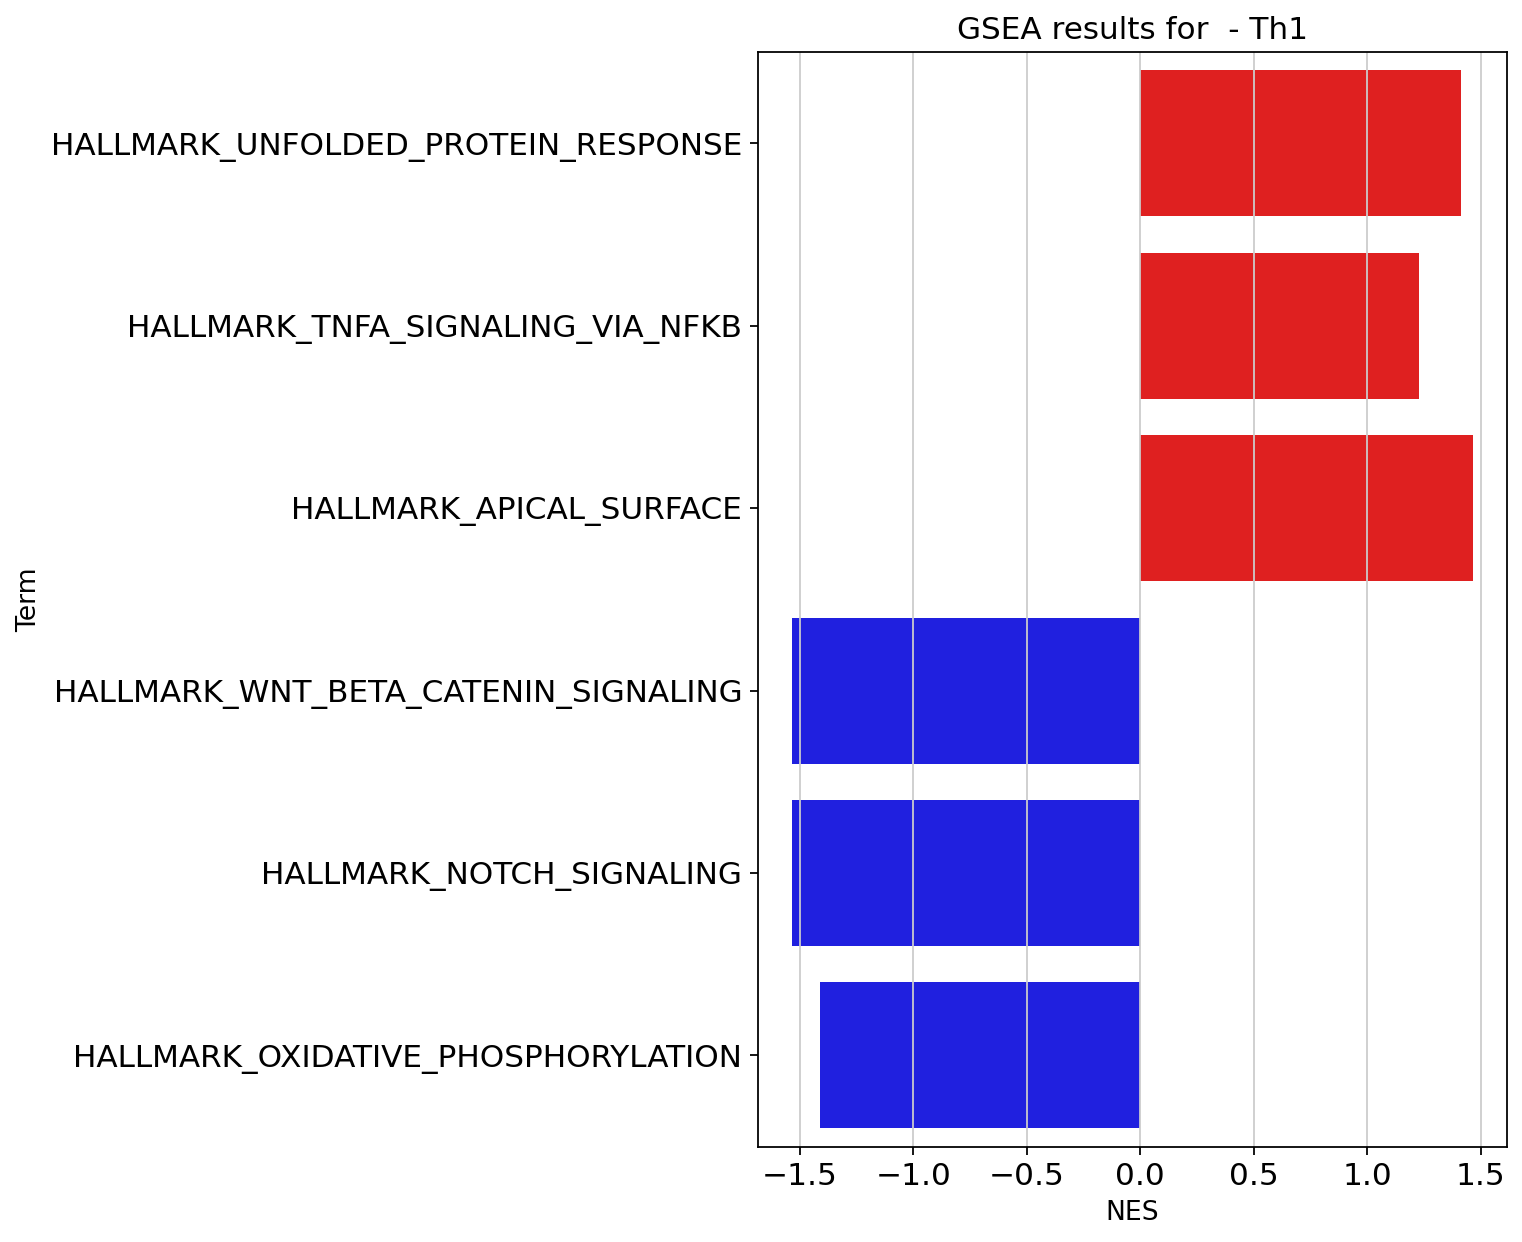

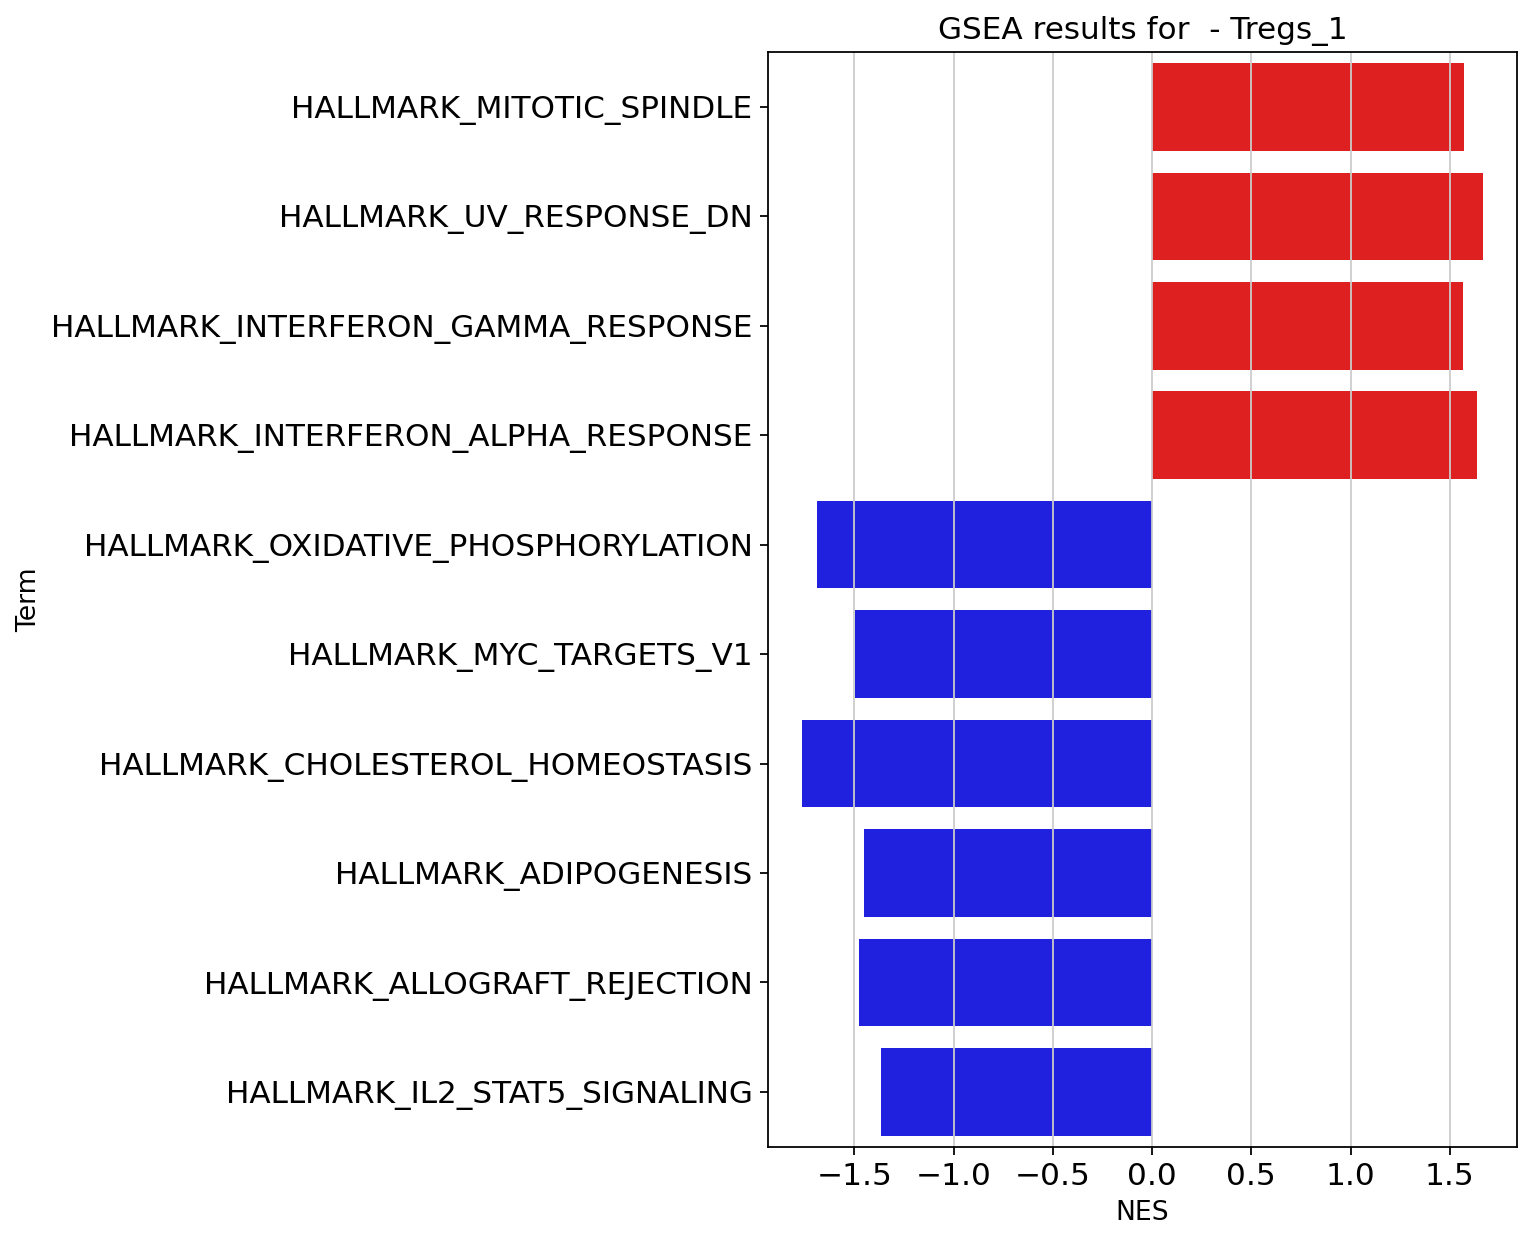

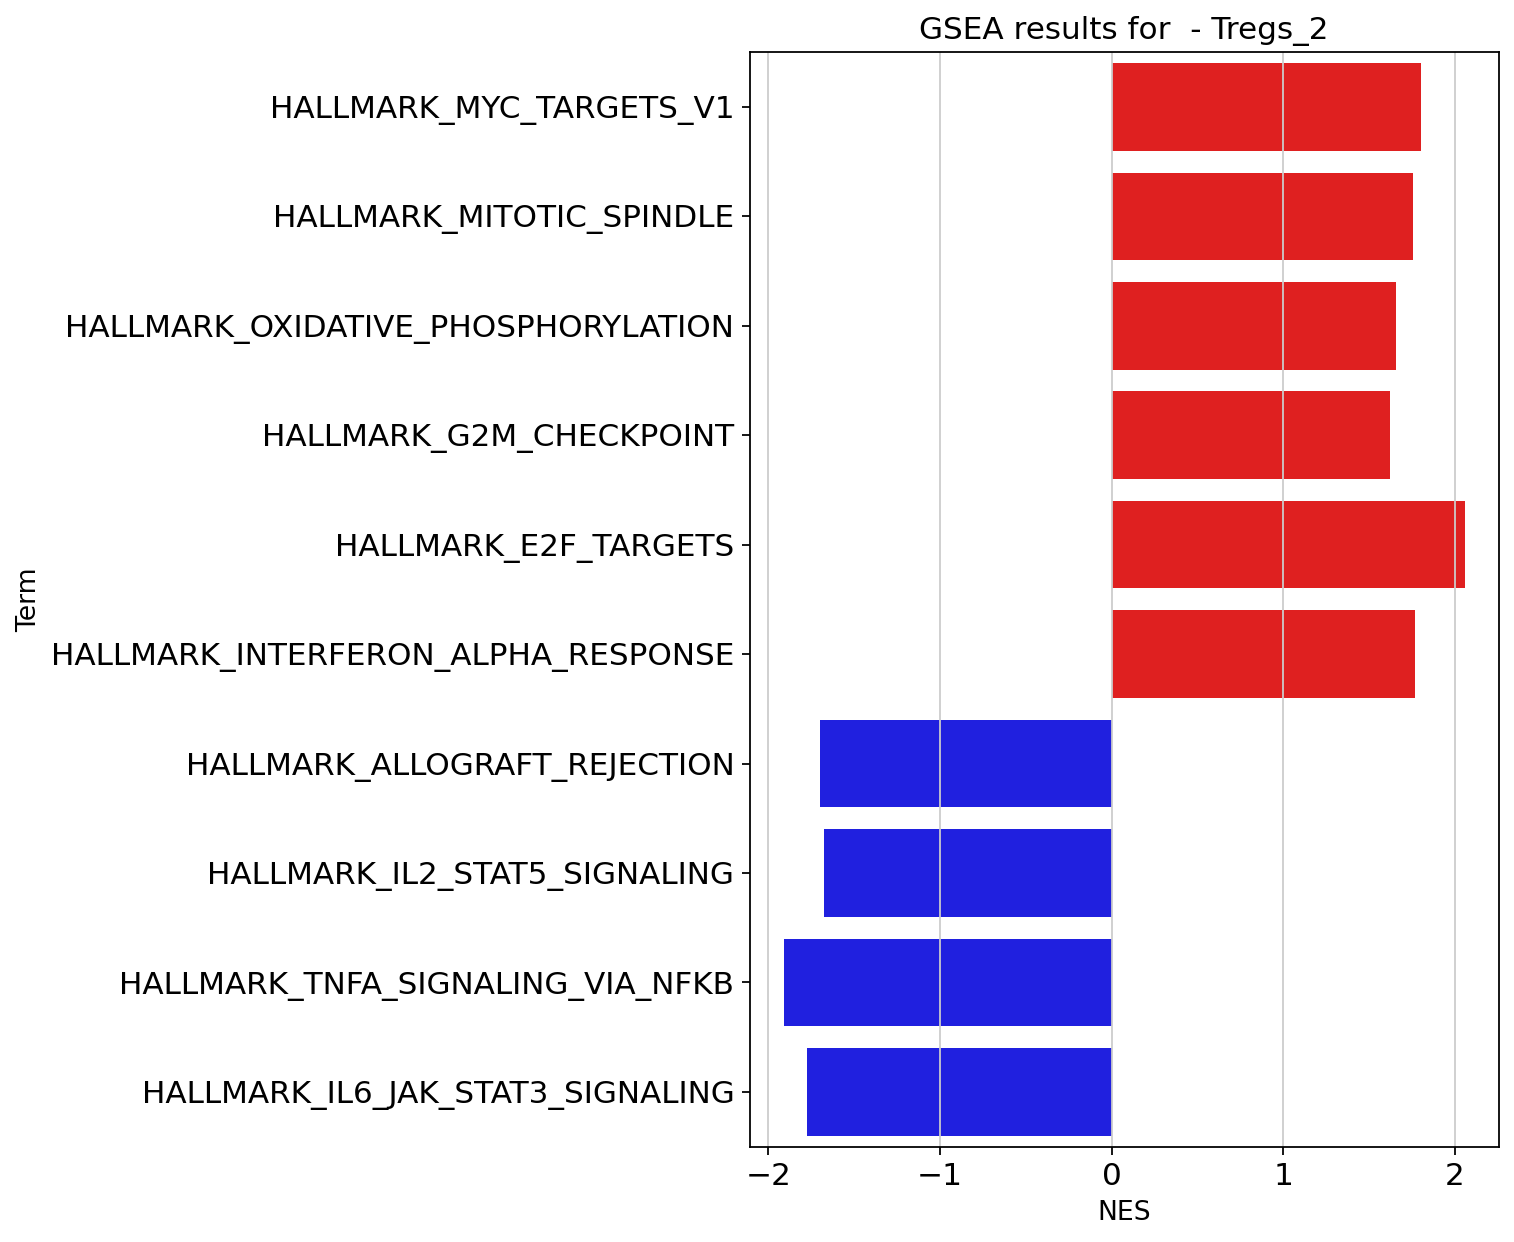

In [46]:
from matplotlib.colors import LinearSegmentedColormap

for cell_types in de_dataframe:
    mat_cell = de_dataframe[cell_types][['stat']].T.rename(index={'stat': cell_types})
    df_mat_cell=mat_cell.T
    sorted_df = df_mat_cell.sort_values(by=cell_types, ascending=False)
    res_gsea= dc.get_gsea_df(sorted_df, cell_types, hallmark_df, source='geneset', target='genesymbol', times=1000, min_n=5, seed=42, verbose=False)
    #save results
    gsea_file_name="pseudobulk_DE/GSEA_res/GSEA_DF_for_" + cell_types + ".csv"
    sorted_res_gsea = res_gsea.sort_values('FDR p-value', ascending=True)
    sub_res_ges = sorted_res_gsea[sorted_res_gsea['NOM p-value'] < 0.1].head(10)

    # Split the data into positive and negative NES values
    positive_nes_data = sub_res_ges[sub_res_ges['NES'] > 0]
    negative_nes_data = sub_res_ges[sub_res_ges['NES'] < 0]

    # Create the bar plots
    plt.figure(figsize=(6, 9))

    if not positive_nes_data.empty:
        sns.barplot(data=positive_nes_data, x='NES', y='Term', color='red', dodge=False)

    if not negative_nes_data.empty:
        sns.barplot(data=negative_nes_data, x='NES', y='Term', color='blue', dodge=False)

    # Customize the plot
    plt.xlabel('NES', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.title(f'GSEA results for  - {cell_types}', fontsize=14)
    plt.savefig(f'pseudobulk_DE/{cell_types}_GSEA_barplot.pdf', format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()
